<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/Accor/Accor_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "ACFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 16:24:08,708 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 16:24:08,710 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for ACFREUR
2019-08-26 16:27:37,477 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 16:33:42,615 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 16:37:11,810 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 16:40:47,618 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 16:44:32,032 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 16:48:07,898 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-26 16:51:51,602 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-26 16:55:35,358 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-26 17:05:31,206 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_ACFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-ACFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-ACFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.43217  0.43217  0.42827  0.43167  6.026800
2018-01-02 09:00:00  0.43158  0.43158  0.42908  0.42968  3.741200
2018-01-02 10:00:00  0.42968  0.43118  0.42927  0.43068  4.539700
2018-01-02 11:00:00  0.43068  0.43168  0.43048  0.43067  3.708700
2018-01-02 12:00:00  0.43078  0.43228  0.43077  0.43228  3.749100
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.36708  0.36737  0.36567  0.36638  1.299448
2018-12-31 09:00:00  0.36637  0.36738  0.36587  0.36678  1.158142
2018-12-31 10:00:00  0.36688  0.36818  0.36667  0.36807  0.833073
2018-12-31 11:00:00  0.36807  0.36928  0.36768  0.36927  0.694507
2018-12-31 12:00:00  0.36928  0.37037  0.36858  0.36940  1.440760

[2275 rows x 5 columns]

Open         High          Low        Close       Volume
count  2275.000000  2275.000000  2275.000000  2275.000000  2275.000000
mean      0.434773     0.435904     0.433707     0.434808     2.527511
std       0.027606     0.027578     0.027698     0.027644     1.199283
min       0.354470     0.356280     0.353070     0.354770     0.000190
25%       0.421825     0.422980     0.420625     0.421820     1.706770
50%       0.437680     0.438880     0.436670     0.437770     2.259646
75%       0.454845     0.455980     0.453570     0.454970     3.037897
max       0.488480     0.489380     0.487670     0.488470    13.472698

25

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.44957  0.45068  0.44937  0.45067  1.921497    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.449033  0.440768  0.444502  0.450796  0.448531  0.446962    0.446875    0.447175  0.444722  0.448225  0.450901  0.448861  0.449409  0.448225  0.450003  0.444104                0.454057                 0.448225                0.442393                0.456974                 0.448225                0.439476                0.459890                 0.448225                0.436560                0.462806                 0.448225                0.433644  0.448531  0.450075  0.444686                0.454363                 0.448531                0.442698                0.457279                 0.448531                0.439782                0.460196                 0.448531                0.436866                0.463112                 0.448531   
2018-01-09 14:00:00  0.45068  0.45069  0.44918  0.44938  4.386767    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.449050  0.440975  0.445200  0.450628  0.448719  0.447400    0.447025    0.447225  0.445263  0.449013  0.450432  0.449535  0.449666  0.449013  0.450025  0.444705                0.453368                 0.449013                0.444657                0.455545                 0.449013                0.442480                0.457723                 0.449013                0.440302                0.459901                 0.449013                0.438124  0.448719  0.449689  0.445299                0.453075                 0.448719                0.444364                0.455252                 0.448719                0.442187                0.457430                 0.448719                0.440009                0.459608                 0.448719   
2018-01-09 15:00:00  0.44938  0.45078  0.44937  0.45067 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000    2225.000000  2225.000000   2225.000000     2225.000000     2225.000000       2225.000000  2225.000000  2225.000000  2225.000000  2225.000000   2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000  2225.000000  2225.000000  2225.000000             2225.000000              2225.000000             2225.000000             2225.000000              2225.000000             2225.000000             2225.000000   
mean      0.434700     0.435831     0.433626     0.434730     2.522679    16.015281     2.020225   185.529888      30.424270    11.373034      0.034157        0.023820        0.002247          0.004045     6.600000     2.534831    26.955955     2.020225      2.004494    26.955955     0.434967     0.435376     0.007300     0.434729     0.434857     0.434441     0.434821     0.434799     0.434933     0.434857     0.434729     0.434857     0.434815     0.434857     0.434757     0.435115                0.438258                 0.434857                0.431457                0.439958                 0.434857                0.429757                0.441658                 0.434857                0.428057                0.443358                 0.434857                0.426357     0.434857     0.434756     0.435076                0.438258                 0.434857                0.431457                0.439958                 0.434857                0.429757                0.441658   
std       0.027898     0.027869     0.027990     0.027936     1.171116     8.585255     1.412637   101.934398       0.854392     2.621369      0.181674        0.152523        0.047362          0.063485     3.354236     1.103369    14.562870     1.412637      1.403995    14.562870     0.027592     0.026968     0.435762     0.027980     0.027696     0.027654     0.027753     0.027767     0.027720     0.027739     0.027958     0.027758     0.027793     0.027739     0.027904     0.027304                0.027693                 0.027739                0.027973                0.027741                 0.027739                0.028159                0.027836                 0.027739                0.028391                0.027978                 0.027739                0.028666     0.027696     0.027884     0.027372                0.027645                 0.027696                0.027937                0.027690                 0.027696                0.028126                0.027782   
min       0.354470     0.356280     0.3530

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  0.709648  0.709241  0.715453  0.717278  0.142609    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.710464  0.648230  0.959048  0.722511  0.708749  0.702721    0.693413    0.696457  0.672379  0.704675  0.723182  0.709004  0.714144  0.704675  0.714054  0.676884                0.714210                 0.704675                0.684275                0.670914                 0.704675                0.677776                0.629639                 0.704675                0.671817                0.594582                 0.704675                0.666150  0.708749  0.717456  0.680923                0.727088                 0.708749                0.691275                0.694083                 0.708749                0.684832                0.649362                 0.708749                0.678711                0.611602                 0.708749   
2018-01-09 14:00:00  0.717931  0.709316  0.714042  0.707629  0.325595    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.710597  0.649884  0.959764  0.721245  0.710196  0.706151    0.694560    0.696839  0.676345  0.710695  0.719674  0.714134  0.716099  0.710695  0.714216  0.681586                0.709088                 0.710695                0.701163                0.661165                 0.710695                0.699673                0.616054                 0.710695                0.698416                0.577739                 0.710695                0.697221  0.710196  0.714550  0.685706                0.717318                 0.710196                0.703711                0.679702                 0.710196                0.702322                0.631397                 0.710196                0.701002                0.590611                 0.710196   
2018-01-09 15:00:00  0.708231  0.709993  

140192

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 19 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_cqyd7n
H2O cluster total nodes:    1
H2O cluster free memory:    8.43 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.579630  0.692628              0.453019  0.499740  0.249740
1  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.523913  0.924814              0.478543  0.572223  0.327439
2              DeepLearning_1_AutoML_20190826_171335  0.512560  0.693036              0.491304  0.499944  0.249944
3  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.505354  4.345355              0.500000  0.706979  0.499819
4  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.500000  0.692723              0.500000  0.499788  0.249788
5  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.500000  0.693070              0.500000  0.499961  0.249961
6  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.500000  0.695094              0.500000  0.500965  0.250966
7  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.496055  0.693436              0.500000  0.500143  0.250143
8  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.495008  0.738655              0.469847  0.520612  0.271037
9  DeepLearning_grid_1_AutoML_20190826_171335_mod...  0.484783  1.017395              0.500000  0.587247  0.344859

variable  relative_importance  scaled_importance  percentage
0                days_in_month             1.000000           1.000000    0.001238
1                    CORREL_14             0.988250           0.988250    0.001224
2                      BETA_12             0.961274           0.961274    0.001190
3                          BOP             0.960141           0.960141    0.001189
4                        DX_30             0.953479           0.953479    0.001181
...                        ...                  ...                ...         ...
1034    BBANDS_upperband_8_4_5             0.694617           0.694617    0.000860
1035    BBANDS_upperband_8_0_4             0.693935           0.693935    0.000859
1036                    SMA_20             0.686575           0.686575    0.000850
1037  BBANDS_middleband_12_3_2             0.686069           0.686069    0.000849
1038            CDL3LINESTRIKE             0.671830           0.671830    0.000832

[1039 rows x 4 columns]

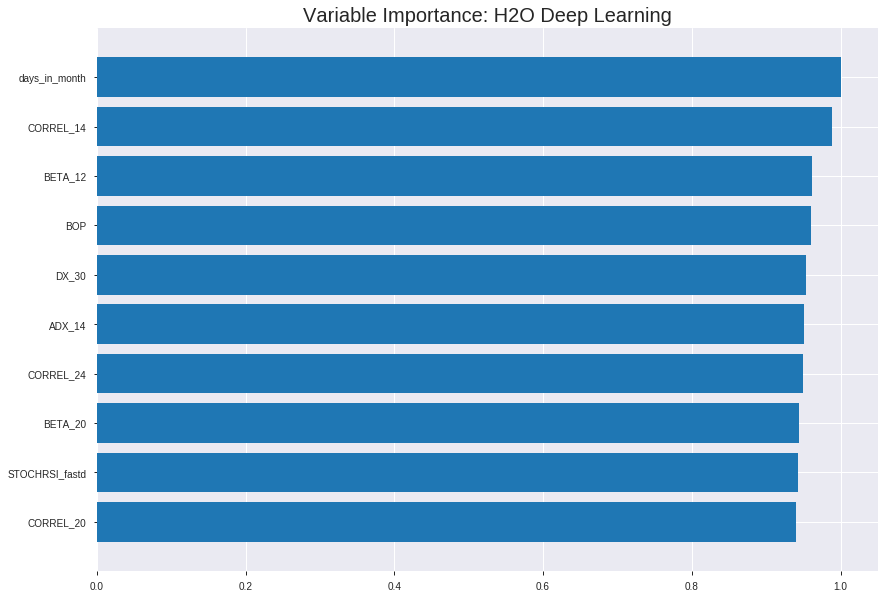

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_171335_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2501639065418592
RMSE: 0.500163879685308
LogLoss: 0.6934753223389541
Mean Per-Class Error: 0.48613396781335716
AUC: 0.5047602524701761
pr_auc: 0.5062934548661163
Gini: 0.00952050494035217
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4808866118157653: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    786   1        (786.0/786.0)
1      0    770   0        (0.0/770.0)
Total  0    1556  0.5051   (786.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.480887     0.662081   399
max f2                       0.480887     0.830457   399
max f0point5                 0.480887     0.550472   399
max accuracy                 0.481064     0.515424   304
max precision                0.481362     1          0
max recall                   0.480887     1          399
max specificity              0.481362     1          0
max absolute_mcc             0.481332     0.0733696  10
max min_per_class_accuracy   0.480889     0.435065   398
max mean_per_class_accuracy  0.481064     0.513866   304

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 48.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.481331           1.64188   1.64188            0.8125           0.481342  0.8125                      0.481342            0.0168831       0.0168831                  64.1883   64.1883
    2        0.0205656                   0.481315           0.757792  1.19984            0.375            0.481324  0.59375                     0.481333            0.00779221      0.0246753                  -24.2208  19.9838
    3        0.0302057                   0.481298           1.07775   1.16087            0.533333         0.481306  0.574468                    0.481325            0.0103896       0.0350649                  7.77489   16.0873
    4        0.0404884                   0.481283           0.505195  0.994352           0.25             0.48129   0.492063                    0.481316            0.00519481      0.0402597                  -49.4805  -0.564832
    5        0.0501285                   0.48127            1.21247   1.0363             0.6              0.481276  0.512821                    0.481308            0.0116883       0.0519481                  21.2468   3.6297
    6        0.100257                    0.481214           0.932667  0.984482           0.461538         0.481237  0.487179                    0.481273            0.0467532       0.0987013                  -6.73327  -1.55178
    7        0.150386                    0.481184           1.01039   0.993118           0.5              0.481201  0.491453                    0.481249            0.0506494       0.149351                   1.03896   -0.688201
    8        0.200514                    0.481158           0.958575  0.984482           0.474359         0.481169  0.487179                    0.481229            0.0480519       0.197403                   -4.14252  -1.55178
    9        0.300129                    0.481103           1.10817   1.02553            0.548387         0.481136  0.507495                    0.481198            0.11039         0.307792                   10.8169   2.55346
    10       0.400386                    0.480995           0.984482  1.01526            0.487179         0.481057  0.502408                    0.481163            0.0987013       0.406494                   -1.55178  1.5255
    11       1                           0.480887           0.989814  1                  0.489818         0.48089   0.494859                    0.480999            0.593506        1                          -1.01864  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2494680445774472
RMSE: 0.4994677612994128
LogLoss: 0.6920829380847052
Mean Per-Class Error: 0.4734796339784598
AUC: 0.4990080168434691
pr_auc: 0.49950767009300684
Gini: -0.001983966313061747
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.481001352542669: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   222  0.9528   (222.0/233.0)
1      4    208  0.0189   (4.0/212.0)
Total  15   430  0.5079   (226.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481001     0.647975  388
max f2                       0.480887     0.819799  399
max f0point5                 0.481001     0.538302  388
max accuracy                 0.481575     0.541573  66
max precision                0.481724     1         0
max recall                   0.480887     1         399
max specificity              0.481724     1         0
max absolute_mcc             0.481685     0.118659  8
max min_per_class_accuracy   0.4814       0.495283  200
max mean_per_class_accuracy  0.48156      0.52652   73

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 48.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.481703           2.09906   2.09906            1                0.481716  1                           0.481716            0.0235849       0.0235849                  109.906   109.906
    2        0.0202247                   0.481684           1.57429   1.86583            0.75             0.481692  0.888889                    0.481705            0.0141509       0.0377358                  57.4292   86.5828
    3        0.0314607                   0.481655           0         1.19946            0                0.481672  0.571429                    0.481694            0               0.0377358                  -100      19.9461
    4        0.0404494                   0.481637           1.04953   1.16614            0.5              0.481646  0.555556                    0.481683            0.00943396      0.0471698                  4.95283   16.6143
    5        0.0516854                   0.481628           0.839623  1.09516            0.4              0.481633  0.521739                    0.481672            0.00943396      0.0566038                  -16.0377  9.516
    6        0.101124                    0.481595           1.14494   1.1195             0.545455         0.481608  0.533333                    0.481641            0.0566038       0.113208                   14.494    11.9497
    7        0.150562                    0.481579           1.14494   1.12785            0.545455         0.481586  0.537313                    0.481623            0.0566038       0.169811                   14.494    12.7851
    8        0.2                         0.481553           1.04953   1.10849            0.5              0.481565  0.52809                     0.481608            0.0518868       0.221698                   4.95283   10.8491
    9        0.301124                    0.481509           0.792977  1.00253            0.377778         0.481531  0.477612                    0.481582            0.0801887       0.301887                   -20.7023  0.25345
    10       0.4                         0.481447           1.04953   1.01415            0.5              0.481486  0.483146                    0.481559            0.103774        0.40566                    4.95283   1.41509
    11       0.501124                    0.481399           0.886268  0.988345           0.422222         0.481427  0.470852                    0.481532            0.0896226       0.495283                   -11.3732  -1.1655
    12       0.6                         0.481329           0.763293  0.951258           0.363636         0.481365  0.453184                    0.481505            0.0754717       0.570755                   -23.6707  -4.87421
    13       0.698876                    0.481279           1.14494   0.97866            0.545455         0.481302  0.466238                    0.481476            0.113208        0.683962                   14.494    -2.13402
    14       0.8                         0.481171           1.1195    0.996462           0.533333         0.48124   0.474719                    0.481446            0.113208        0.79717                    11.9497   -0.353774
    15       0.898876                    0.481074           1.00182   0.997052           0.477273         0.481128  0.475                       0.481411            0.0990566       0.896226                   0.182247  -0.294811
    16       1                           0.480887           1.02621   1                  0.488889         0.48101   0.476404                    0.48137      


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:35:23  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:35:25  3 min 45.135 sec  243 obs/sec       0.341902  1             532        0.619765         1.54177             -0.536597      0.518868        0.507641           1.51558          0.502571                         0.717587           3.91786               -1.06432         0.504596          0.503855             1.67925            0.507865
    2019-08-26 17:36:00  4 min 19.383 sec  295 obs/sec       6.28599   18            9781       0.500813         0.694779            -0.00336082    0.504783        0.0334426          1.00549          0.505141                         0.499539           0.692227              -0.000386087     0.505608          0.0338643            1.00612            0.521348
    2019-08-26 17:36:34  4 min 53.644 sec  369 obs/sec       15.1774   43            23616      0.500164         0.693475            -0.000761442   0.50476         0.506293           1.64188          0.505141                         0.499468           0.692083              -9.93912e-05     0.499008          0.499508             2.09906            0.507865
    2019-08-26 17:37:08  5 min 27.929 sec  448 obs/sec       27.3368   77            42536      0.499994         0.693135            -8.04373e-05   0.5             0                  1                0.505141                         0.499969           0.693086              -0.00210935      0.5               0                    1                  0.523596
    2019-08-26 17:37:42  6 min  1.868 sec  504 obs/sec       40.7153   115           63353      0.500531         0.69421             -0.00223077    0.5             0                  1                0.505141                         0.501212           0.695574              -0.0070948       0.5               0                    1                  0.523596
    2019-08-26 17:38:17  6 min 36.381 sec  552 obs/sec       55.563    157           86456      0.502981         0.699174            -0.0120665     0.5             0                  1                0.505141                         0.500772           0.694718              -0.00533121      0.5               0                    1                  0.523596
    2019-08-26 17:38:51  7 min 10.789 sec  592 obs/sec       71.4569   202           111187     0.500043         0.693234            -0.000279244   0.5             0                  1                0.505141                         0.500162           0.693471              -0.0028813       0.5               0                    1                  0.523596
    2019-08-26 17:38:54  7 min 14.153 sec  592 obs/sec       71.4569   202           111187     0.500164         0.693475            -0.000761442   0.50476         0.506293           1.64188          0.505141                         0.499468           0.692083              -9.93912e-05     0.499008          0.499508             2.09906            0.507865

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
days_in_month             1.0                    1.0                  0.0012381342164441561
CORREL_14                 0.9882498383522034     0.9882498383522034   0.0012235859392592692
BETA_12                   0.9612739682197571     0.9612739682197571   0.0011901861914299335
BOP                       0.9601407647132874     0.9601407647132874   0.0011887831333943788
DX_30                     0.9534787535667419     0.9534787535667419   0.0011805346694435087
---                       ---                    ---                  ---
BBANDS_upperband_8_4_5    0.6946172118186951     0.6946172118186951   0.0008600293372837644
BBANDS_upperband_8_0_4    0.6939345002174377     0.6939345002174377   0.0008591840486902844
SMA_20                    0.6865745782852173     0.6865745782852173   0.0008500714775156444
BBANDS_middleband_12_3_2  0.6860694885253906     0.6860694885253906   0.0008494461086016275
CDL3LINESTRIKE            0.671829879283905      0.671829879283905    0.0008318155611709497


See the whole table with table.as_data_frame()


('accuracy', 0.57847533632287)

('F1', 0.6687898089171974)

('auc', 0.5796296296296296)

('logloss', 0.6926280259379912)

('mean_per_class_error', 0.4254428341384864)

('rmse', 0.4997404142110692)

('mse', 0.24974048159585102)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


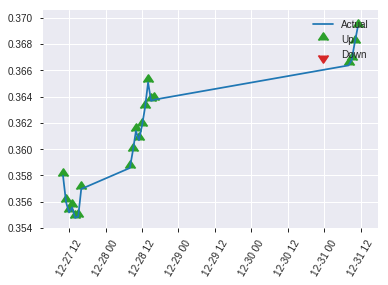


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24974048159585102
RMSE: 0.4997404142110692
LogLoss: 0.6926280259379912
Mean Per-Class Error: 0.4254428341384864
AUC: 0.5796296296296296
pr_auc: 0.556736041421518
Gini: 0.1592592592592592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48151863382532967: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   101  0.8783   (101.0/115.0)
1      3    105  0.0278   (3.0/108.0)
Total  17   206  0.4664   (104.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481519     0.66879   203
max f2                       0.481452     0.824427  220
max f0point5                 0.481535     0.566667  195
max accuracy                 0.481796     0.578475  74
max precision                0.48202      1         0
max recall                   0.481452     1         220
max specificity              0.48202      1         0
max absolute_mcc             0.481519     0.176951  203
max min_per_class_accuracy   0.481747     0.556522  109
max mean_per_class_accuracy  0.481741     0.574557  112

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 48.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.482016           2.06481   2.06481            1                0.482018  1                           0.482018            0.0277778       0.0277778                  106.481   106.481
    2        0.0224215                   0.482013           1.03241   1.65185            0.5              0.482016  0.8                         0.482017            0.00925926      0.037037                   3.24074   65.1852
    3        0.0313901                   0.482008           1.03241   1.47487            0.5              0.48201   0.714286                    0.482015            0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.482004           1.03241   1.37654            0.5              0.482007  0.666667                    0.482013            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.481992           1.37654   1.37654            0.666667         0.481999  0.666667                    0.48201             0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.481922           1.31397   1.34662            0.636364         0.481965  0.652174                    0.481988            0.0648148       0.138889                   31.3973   34.6618
    7        0.152466                    0.481885           0.750842  1.15387            0.363636         0.481897  0.558824                    0.481959            0.037037        0.175926                   -24.9158  15.3867
    8        0.201794                    0.481851           0.938552  1.10123            0.454545         0.481869  0.533333                    0.481937            0.0462963       0.222222                   -6.14478  10.1235
    9        0.300448                    0.481805           1.40783   1.20191            0.681818         0.481817  0.58209                     0.481898            0.138889        0.361111                   40.7828   20.1907
    10       0.399103                    0.481782           1.03241   1.16001            0.5              0.481794  0.561798                    0.481872            0.101852        0.462963                   3.24074   16.0008
    11       0.502242                    0.481747           0.98752   1.12459            0.478261         0.481767  0.544643                    0.48185             0.101852        0.564815                   -1.24799  12.4587
    12       0.600897                    0.481713           0.750842  1.06323            0.363636         0.48173   0.514925                    0.481831            0.0740741       0.638889                   -24.9158  6.32255
    13       0.699552                    0.481662           1.03241   1.05888            0.5              0.481693  0.512821                    0.481811            0.101852        0.740741                   3.24074   5.88794
    14       0.798206                    0.481569           1.03241   1.05561            0.5              0.481618  0.511236                    0.481787            0.101852        0.842593                   3.24074   5.56076
    15       0.896861                    0.481529           1.03241   1.05306            0.5              0.481549  0.51                        0.481761            0.101852        0.944444                   3.24074   5.30556
    16       1                           0.481452           0.538647  1                  0.26087          0.481502  0.484305                    0.481734         

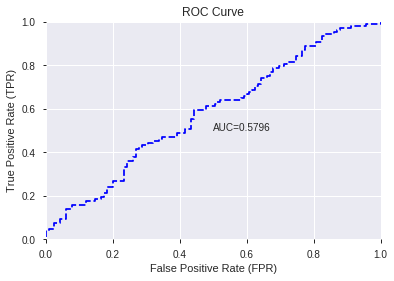

This function is available for GLM models only


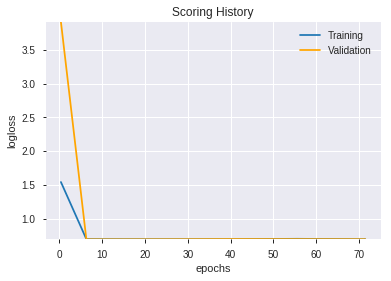

--2019-08-26 17:45:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.104.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.104.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_171335_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_171335_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_174515_model_5  0.523953  0.703832              0.500000  0.504071  0.254087
1  DeepLearning_grid_1_AutoML_20190826_174515_model_6  0.506441  0.701107              0.453583  0.503603  0.253616
2  DeepLearning_grid_1_AutoML_20190826_174515_model_7  0.505314  0.776301              0.500000  0.532035  0.283062
3  DeepLearning_grid_1_AutoML_20190826_174515_model_9  0.502657  0.692882              0.495652  0.499868  0.249868
4  DeepLearning_grid_1_AutoML_20190826_174515_model_3  0.502496  0.895398              0.491304  0.561803  0.315623
5  DeepLearning_grid_1_AutoML_20190826_174515_model_2  0.501932  1.257193              0.486957  0.611767  0.374258
6               DeepLearning_1_AutoML_20190826_174515  0.501449  0.829036              0.482890  0.539635  0.291206
7  DeepLearning_grid_1_AutoML_20190826_174515_model_8  0.500000  0.692915              0.500000  0.499884  0.249884
8  DeepLearning_grid_1_AutoML_20190826_174515_model_4  0.492834  0.958872              0.500000  0.578921  0.335149
9  DeepLearning_grid_1_AutoML_20190826_174515_model_1  0.484300  1.524623              0.500000  0.627926  0.394291

variable  relative_importance  scaled_importance  percentage
0           HT_TRENDMODE             1.000000           1.000000    0.031444
1              CORREL_20             0.835144           0.835144    0.026261
2                   hour             0.789131           0.789131    0.024814
3                    day             0.770878           0.770878    0.024240
4                weekday             0.750774           0.750774    0.023608
5              CORREL_14             0.747503           0.747503    0.023505
6              CORREL_24             0.746455           0.746455    0.023472
7                    BOP             0.745635           0.745635    0.023446
8                quarter             0.745034           0.745034    0.023427
9              dayofweek             0.730158           0.730158    0.022959
10          aroondown_12             0.716756           0.716756    0.022538
11        STOCHRSI_fastk             0.704611           0.704611    0.022156
12            weekofyear             0.702475           0.702475    0.022089
13         days_in_month             0.692799           0.692799    0.021785
14  HT_PHASOR_quadrature             0.679691           0.679691    0.021373
15                 MFI_8             0.677411           0.677411    0.021301
16            aroonup_24             0.674830           0.674830    0.021220
17                 ADX_8             0.674110           0.674110    0.021197
18                   DIV             0.673685           0.673685    0.021184
19               BETA_12             0.640110           0.640110    0.020128
20          aroondown_14             0.635986           0.635986    0.019998
21          aroondown_24             0.625447           0.625447    0.019667
22             aroonup_8             0.618267           0.618267    0.019441
23           AROONOSC_24             0.616911           0.616911    0.019398
24        STOCHRSI_fastd             0.613356           0.613356    0.019287
25                  DX_8             0.607367           0.607367    0.019098
26               NATR_24             0.596766           0.596766    0.018765
27              STDDEV_8             0.595075           0.595075    0.018712
28                ULTOSC             0.590958           0.590958    0.018582
29               ROCR_20             0.589290           0.589290    0.018530
30                ROC_30             0.588301           0.588301    0.018499
31           STOCH_slowk             0.585380           0.585380    0.018407
32               BETA_24             0.585339           0.585339    0.018406
33            PLUS_DM_12             0.581929           0.581929    0.018298
34                ADX_24             0.578443           0.578443    0.018189
35           AROONOSC_20             0.577857           0.577857    0.018170
36                 DX_30             0.576092           0.576092    0.018115
37                 DX_12             0.568773           0.568773    0.017885
38                 DX_14             0.555236           0.555236    0.017459
39                ADX_20             0.551959           0.551959    0.017356
40                ADX_14             0.551708           0.551708    0.017348
41                 DX_24             0.549345           0.549345    0.017274
42                ATR_20             0.549058           0.549058    0.017265
43      MACDFIX_signal_8             0.546128           0.546128    0.017173
44          STOCHF_fastd             0.530287           0.530287    0.016675
45               BETA_20             0.528444           0.528444    0.016617
46           MINUS_DI_20             0.507608           0.507608    0.015961
47           MINUS_DI_30             0.506889           0.506889    0.015939
48               WILLR_8             0.502862           0.502862    0.015812
49            MINUS_DM_8             0.493871           0.493871    0.015529

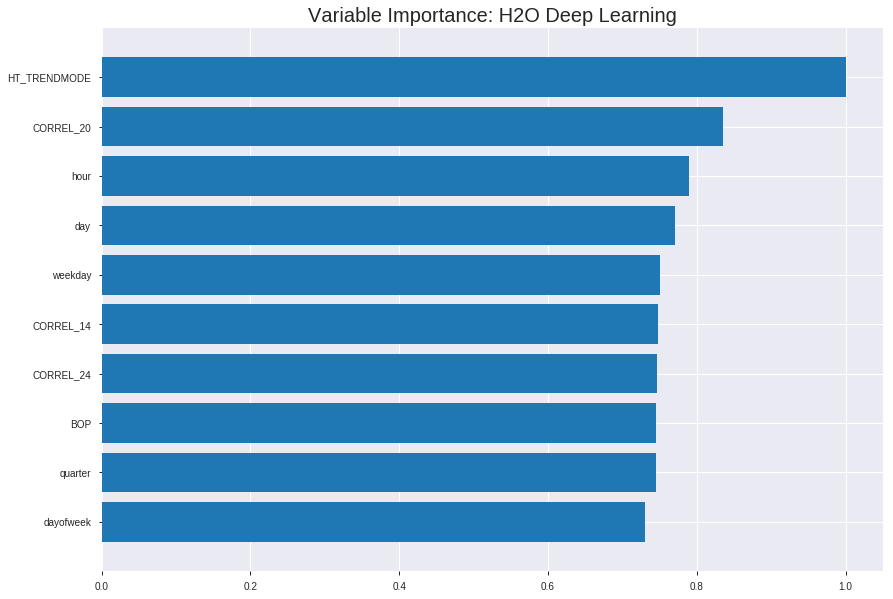

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_174515_model_5


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21828686309429665
RMSE: 0.4672117968269815
LogLoss: 0.6215540716246515
Mean Per-Class Error: 0.3452397475298239
AUC: 0.7125871583886851
pr_auc: 0.7080205253495954
Gini: 0.4251743167773703
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3752247940713178: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      277  509   0.6476   (509.0/786.0)
1      83   687   0.1078   (83.0/770.0)
Total  360  1196  0.3805   (592.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.375225     0.698881  260
max f2                       0.240021     0.841463  334
max f0point5                 0.444745     0.648591  201
max accuracy                 0.444745     0.654242  201
max precision                0.976653     1         0
max recall                   0.14773      1         368
max specificity              0.976653     1         0
max absolute_mcc             0.432533     0.313559  213
max min_per_class_accuracy   0.455756     0.642494  190
max mean_per_class_accuracy  0.444745     0.65476   201

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 44.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.877905           2.02078   2.02078            1                0.932522  1                           0.932522            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.826198           2.02078   2.02078            1                0.851153  1                           0.891837            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.785643           2.02078   2.02078            1                0.806513  1                           0.864606            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.742636           1.76818   1.95663            0.875            0.76168   0.968254                    0.838466            0.0181818       0.0792208                  76.8182   95.6627
    5        0.0501285                   0.70169            1.75134   1.91715            0.866667         0.72504   0.948718                    0.816653            0.0168831       0.0961039                  75.1342   91.715
    6        0.100257                    0.597335           1.399     1.65808            0.692308         0.647056  0.820513                    0.731855            0.0701299       0.166234                   39.9001   65.8075
    7        0.150386                    0.541916           1.37309   1.56308            0.679487         0.566846  0.773504                    0.676852            0.0688312       0.235065                   37.3094   56.3081
    8        0.200514                    0.505788           1.37309   1.51558            0.679487         0.522603  0.75                        0.63829             0.0688312       0.303896                   37.3094   51.5584
    9        0.300129                    0.475008           1.2255    1.41931            0.606452         0.489889  0.702355                    0.589035            0.122078        0.425974                   22.5505   41.9305
    10       0.411954                    0.467142           1.08007   1.32722            0.534483         0.468795  0.656786                    0.556396            0.120779        0.546753                   8.00717   32.722
    11       0.5                         0.455406           1.12102   1.29091            0.554745         0.462734  0.638817                    0.539902            0.0987013       0.645455                   12.1016   29.0909
    12       0.600257                    0.432631           1.08811   1.25704            0.538462         0.444182  0.622056                    0.523915            0.109091        0.754545                   8.81119   25.7037
    13       0.699871                    0.403569           0.808312  1.19317            0.4              0.418852  0.59045                     0.508961            0.0805195       0.835065                   -19.1688  19.3169
    14       0.800129                    0.352707           0.738362  1.13618            0.365385         0.381825  0.562249                    0.493031            0.074026        0.909091                   -26.1638  13.6181
    15       0.899743                    0.259683           0.677939  1.08545            0.335484         0.310206  0.537143                    0.472789            0.0675325       0.976623                   -32.2061  8.54471
    16       1                           0.0205223          0.233167  1                  0.115385         0.17357   0.494859                    0.442791           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26098723147758796
RMSE: 0.5108690942673945
LogLoss: 0.7182476800938502
Mean Per-Class Error: 0.4733784112073852
AUC: 0.5080472103004292
pr_auc: 0.479069664923643
Gini: 0.016094420600858417
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2755018487528984: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      19   214  0.9185   (214.0/233.0)
1      6    206  0.0283   (6.0/212.0)
Total  25   420  0.4944   (220.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275502     0.651899  374
max f2                       0.152766     0.821069  397
max f0point5                 0.275502     0.544397  374
max accuracy                 0.655962     0.52809   35
max precision                0.789957     0.571429  6
max recall                   0.152766     1         397
max specificity              0.880756     0.995708  0
max absolute_mcc             0.275502     0.115482  374
max min_per_class_accuracy   0.469654     0.506438  212
max mean_per_class_accuracy  0.275502     0.526622  374

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 47.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.796793           0.839623  0.839623           0.4              0.846376  0.4                         0.846376            0.00943396      0.00943396                 -16.0377  -16.0377
    2        0.0202247                   0.772574           1.57429   1.16614            0.75             0.788181  0.555556                    0.820511            0.0141509       0.0235849                  57.4292   16.6143
    3        0.0314607                   0.744123           0.839623  1.04953            0.4              0.757031  0.5                         0.79784             0.00943396      0.0330189                  -16.0377  4.95283
    4        0.0404494                   0.715137           1.04953   1.04953            0.5              0.723963  0.5                         0.781423            0.00943396      0.0424528                  4.95283   4.95283
    5        0.0516854                   0.696898           0.419811  0.912633           0.2              0.708762  0.434783                    0.765627            0.00471698      0.0471698                  -58.0189  -8.73667
    6        0.101124                    0.632274           1.04953   0.97956            0.5              0.662758  0.466667                    0.715335            0.0518868       0.0990566                  4.95283   -2.04403
    7        0.150562                    0.585683           0.954117  0.971205           0.454545         0.60351   0.462687                    0.678617            0.0471698       0.146226                   -4.58834  -2.87947
    8        0.2                         0.549189           1.14494   1.01415            0.545455         0.565321  0.483146                    0.650611            0.0566038       0.20283                    14.494    1.41509
    9        0.301124                    0.512369           1.07285   1.03386            0.511111         0.529398  0.492537                    0.609905            0.108491        0.311321                   7.28512   3.38637
    10       0.4                         0.487269           1.00182   1.02594            0.477273         0.498572  0.488764                    0.582385            0.0990566       0.410377                   0.182247  2.59434
    11       0.501124                    0.469638           0.97956   1.01658            0.466667         0.477212  0.484305                    0.561161            0.0990566       0.509434                   -2.04403  1.65835
    12       0.6                         0.467093           1.04953   1.02201            0.5              0.467708  0.486891                    0.545761            0.103774        0.613208                   4.95283   2.20126
    13       0.698876                    0.449014           0.810999  0.992159           0.386364         0.460939  0.472669                    0.53376             0.0801887       0.693396                   -18.9001  -0.784141
    14       0.8                         0.411138           0.932914  0.98467            0.444444         0.431933  0.469101                    0.520889            0.0943396       0.787736                   -6.7086   -1.53302
    15       0.898876                    0.329372           1.28806   1.01804            0.613636         0.378184  0.485                       0.505191            0.127358        0.915094                   28.8057   1.80425
    16       1                           0.090439           0.839623  1                  0.4              0.252034  0.476404                    0.479591  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:48:34  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 17:48:36  1 min 20.989 sec  1162 obs/sec      1.4081    1             2191       0.505375         0.704577            -0.0217249     0.539734        0.531757           1.01039          0.504499                         0.520946           0.738951              -0.0879621       0.530772          0.513414             1.25943            0.510112
    2019-08-26 17:48:44  1 min 28.477 sec  2024 obs/sec      11.286    8             17561      0.492568         0.6777              0.0294051      0.59914         0.583168           1.51558          0.458226                         0.515523           0.727563              -0.0654267       0.459825          0.451011             0.419811           0.51236
    2019-08-26 17:48:51  1 min 35.785 sec  2291 obs/sec      22.5193   16            35040      0.467212         0.621554            0.12676        0.712587        0.708021           2.02078          0.380463                         0.510869           0.718248              -0.046279        0.508047          0.47907              0.839623           0.494382
    2019-08-26 17:48:59  1 min 43.530 sec  2452 obs/sec      35.2153   25            54795      0.448297         0.586984            0.196035       0.758574        0.765558           2.02078          0.344473                         0.534224           0.788824              -0.144128        0.491163          0.461956             0.419811           0.516854
    2019-08-26 17:49:06  1 min 51.113 sec  2543 obs/sec      47.8413   34            74441      0.430335         0.53772             0.259168       0.815564        0.821089           2.02078          0.296915                         0.546998           0.848528              -0.1995          0.506073          0.473002             0                  0.51236
    2019-08-26 17:49:13  1 min 57.923 sec  2594 obs/sec      59.0392   42            91865      0.392541         0.462224            0.383582       0.869835        0.867607           2.02078          0.244216                         0.556927           0.9068                -0.243441        0.513058          0.480682             0.839623           0.516854
    2019-08-26 17:49:14  1 min 58.615 sec  2592 obs/sec      59.0392   42            91865      0.467212         0.621554            0.12676        0.712587        0.708021           2.02078          0.380463                         0.510869           0.718248              -0.046279        0.508047          0.47907              0.839623           0.494382

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
HT_TRENDMODE  1.0                    1.0                  0.031444443523257995
CORREL_20     0.8351439237594604     0.8351439237594604   0.02626063594444644
hour          0.7891308665275574     0.7891308665275574   0.024813780964985422
day           0.7708775997161865     0.7708775997161865   0.024239817147620312
weekday       0.7507742643356323     0.7507742643356323   0.023607678953617362
---           ---                    ---                  ---
BETA_20       0.5284437537193298     0.5284437537193298   0.016616619769045927
MINUS_DI_20   0.5076075792312622     0.5076075792312622   0.015961437857115134
MINUS_DI_30   0.5068888664245605     0.5068888664245605   0.01593883833285536
WILLR_8       0.5028620958328247     0.5028620958328247   0.01581221877240241
MINUS_DM_8    0.4938710033893585     0.4938710033893585   0.015529498873851444


See the whole table with table.as_data_frame()


('accuracy', 0.547085201793722)

('F1', 0.6525679758308157)

('auc', 0.5239533011272142)

('logloss', 0.7038324638105466)

('mean_per_class_error', 0.45205314009661834)

('rmse', 0.5040707828115404)

('mse', 0.2540873540842391)

deeplearning prediction progress: |███████████████████████████████████████| 100%


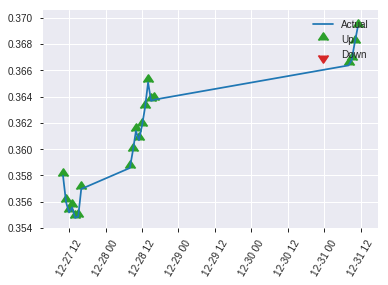


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2540873540842391
RMSE: 0.5040707828115404
LogLoss: 0.7038324638105466
Mean Per-Class Error: 0.45205314009661834
AUC: 0.5239533011272142
pr_auc: 0.49328913490426274
Gini: 0.04790660225442833
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0994663537263566: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    108  0        (0.0/108.0)
Total  0    223  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0994664    0.652568  187
max f2                       0.0994664    0.824427  187
max f0point5                 0.420182     0.558894  145
max accuracy                 0.48437      0.547085  44
max precision                0.747275     1         0
max recall                   0.0994664    1         187
max specificity              0.747275     1         0
max absolute_mcc             0.420182     0.122571  145
max min_per_class_accuracy   0.467142     0.434783  85
max mean_per_class_accuracy  0.420182     0.547947  145

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 45.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.715191           0.688272  0.688272           0.333333         0.728766  0.333333                    0.728766            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.697159           1.03241   0.825926           0.5              0.709131  0.4                         0.720912            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.649485           1.03241   0.884921           0.5              0.66779   0.428571                    0.705734            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.615769           1.03241   0.917695           0.5              0.643697  0.444444                    0.691948            0.00925926      0.037037                   3.24074   -8.23045
    5        0.0538117                   0.581586           0         0.688272           0                0.59799   0.333333                    0.668459            0               0.037037                   -100      -31.1728
    6        0.103139                    0.512277           1.50168   1.07729            0.727273         0.540794  0.521739                    0.607402            0.0740741       0.111111                   50.1684   7.72947
    7        0.152466                    0.495424           1.50168   1.2146             0.727273         0.50084   0.588235                    0.572926            0.0740741       0.185185                   50.1684   21.4597
    8        0.201794                    0.483384           1.12626   1.193              0.545455         0.490371  0.577778                    0.552746            0.0555556       0.240741                   12.6263   19.3004
    9        0.300448                    0.470831           0.750842  1.04782            0.363636         0.47459   0.507463                    0.527083            0.0740741       0.314815                   -24.9158  4.78165
    10       0.542601                    0.467142           0.841221  0.955617           0.407407         0.467786  0.46281                     0.50062             0.203704        0.518519                   -15.8779  -4.43832
    11       0.600897                    0.461192           1.42949   1.00159            0.692308         0.464769  0.485075                    0.497142            0.0833333       0.601852                   42.9487   0.158928
    12       0.699552                    0.442271           1.12626   1.01917            0.545455         0.451948  0.49359                     0.490768            0.111111        0.712963                   12.6263   1.91714
    13       0.798206                    0.423158           1.31397   1.05561            0.636364         0.433389  0.511236                    0.483676            0.12963         0.842593                   31.3973   5.56076
    14       0.896861                    0.398327           0.656987  1.01176            0.318182         0.409793  0.49                        0.475549            0.0648148       0.907407                   -34.3013  1.17593
    15       1                           0.0994664          0.897746  1                  0.434783         0.322183  0.484305                    0.459731            0.0925926       1                          -10.2254  0

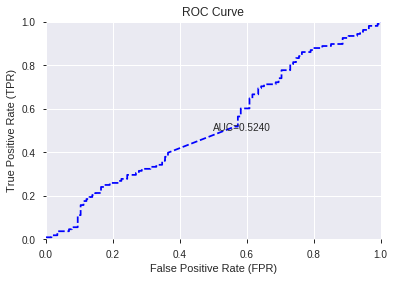

This function is available for GLM models only


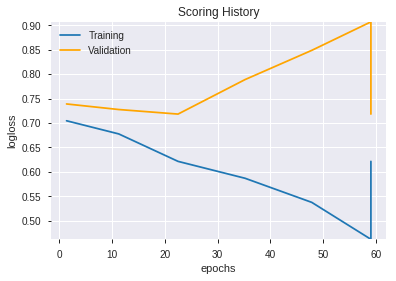

--2019-08-26 17:53:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_174515_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_174515_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'CORREL_20',
 'hour',
 'day',
 'weekday',
 'CORREL_14',
 'CORREL_24',
 'BOP',
 'quarter',
 'dayofweek',
 'aroondown_12',
 'STOCHRSI_fastk',
 'weekofyear',
 'days_in_month',
 'HT_PHASOR_quadrature',
 'MFI_8',
 'aroonup_24',
 'ADX_8',
 'DIV',
 'BETA_12',
 'aroondown_14',
 'aroondown_24',
 'aroonup_8',
 'AROONOSC_24',
 'STOCHRSI_fastd',
 'DX_8',
 'NATR_24',
 'STDDEV_8',
 'ULTOSC',
 'ROCR_20',
 'ROC_30',
 'STOCH_slowk',
 'BETA_24',
 'PLUS_DM_12',
 'ADX_24',
 'AROONOSC_20',
 'DX_30',
 'DX_12',
 'DX_14',
 'ADX_20',
 'ADX_14',
 'DX_24',
 'ATR_20',
 'MACDFIX_signal_8',
 'STOCHF_fastd',
 'BETA_20',
 'MINUS_DI_20',
 'MINUS_DI_30',
 'WILLR_8',
 'MINUS_DM_8']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_175353_model_1  0.494847  0.692953              0.479106  0.499903  0.249903

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature             0.007732           1.000000    0.052361
1                   DX_8             0.007432           0.961091    0.050324
2                    DIV             0.006958           0.899836    0.047117
3                  DX_12             0.006537           0.845437    0.044268
4                  DX_14             0.006399           0.827575    0.043333
5           STOCHF_fastd             0.006214           0.803681    0.042082
6            STOCH_slowk             0.006201           0.801945    0.041991
7              aroonup_8             0.006109           0.790017    0.041366
8                 ADX_24             0.005953           0.769862    0.040311
9              CORREL_24             0.004722           0.610628    0.031973
10          aroondown_12             0.004594           0.594128    0.031109
11                ADX_20             0.004347           0.562134    0.029434
12                 MFI_8             0.004139           0.535287    0.028028
13              STDDEV_8             0.003591           0.464378    0.024316
14               quarter             0.003440           0.444911    0.023296
15                 ADX_8             0.003395           0.439066    0.022990
16                 DX_24             0.003385           0.437825    0.022925
17            aroonup_24             0.002999           0.387881    0.020310
18                   day             0.002885           0.373079    0.019535
19            weekofyear             0.002835           0.366654    0.019199
20                   BOP             0.002832           0.366206    0.019175
21          aroondown_14             0.002680           0.346572    0.018147
22               NATR_24             0.002579           0.333572    0.017466
23        STOCHRSI_fastk             0.002522           0.326112    0.017076
24               weekday             0.002468           0.319232    0.016715
25             dayofweek             0.002462           0.318386    0.016671
26             CORREL_20             0.002339           0.302504    0.015840
27                ADX_14             0.002189           0.283110    0.014824
28               WILLR_8             0.002144           0.277224    0.014516
29                ROC_30             0.002036           0.263266    0.013785
30            PLUS_DM_12             0.001846           0.238796    0.012504
31        STOCHRSI_fastd             0.001755           0.226967    0.011884
32               ROCR_20             0.001696           0.219321    0.011484
33      MACDFIX_signal_8             0.001635           0.211436    0.011071
34           MINUS_DI_20             0.001462           0.189121    0.009903
35          HT_TRENDMODE             0.001455           0.188195    0.009854
36                  hour             0.001336           0.172829    0.009050
37           MINUS_DI_30             0.001310           0.169472    0.008874
38           AROONOSC_20             0.001236           0.159859    0.008370
39               BETA_24             0.001200           0.155198    0.008126
40             CORREL_14             0.001198           0.154948    0.008113
41           AROONOSC_24             0.001147           0.148350    0.007768
42                ULTOSC             0.001118           0.144560    0.007569
43                 DX_30             0.001088           0.140687    0.007367
44          aroondown_24             0.000987           0.127638    0.006683
45               BETA_12             0.000930           0.120332    0.006301
46               BETA_20             0.000826           0.106852    0.005595
47                ATR_20             0.000717           0.092690    0.004853
48            MINUS_DM_8             0.000562           0.072666    0.003805
49         days_in_month             0.000050           0.006497    0.000340

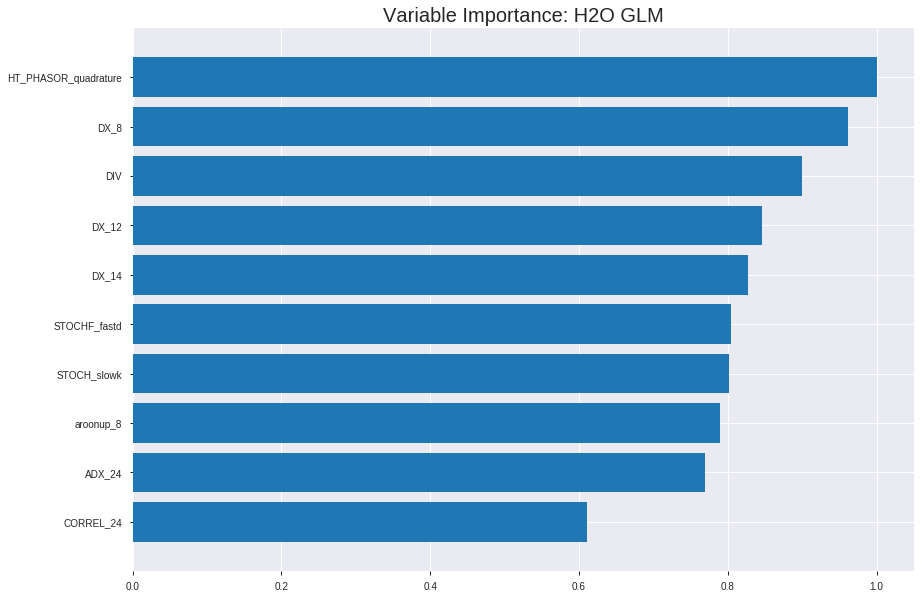

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_175353_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24929745185811525
RMSE: 0.4992969575894843
LogLoss: 0.6917415633400902
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.909498581488
Residual deviance: 2152.6997451143607
AIC: 2254.6997451143607
AUC: 0.5516208981857836
pr_auc: 0.5415477791869824
Gini: 0.10324179637156727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47481768925370116: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   775   0.986    (775.0/786.0)
1      2    768   0.0026   (2.0/770.0)
Total  13   1543  0.4994   (777.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474818     0.664073  389
max f2                       0.472336     0.831533  393
max f0point5                 0.489911     0.554303  258
max accuracy                 0.499643     0.544987  128
max precision                0.517768     1         0
max recall                   0.472336     1         393
max specificity              0.517768     1         0
max absolute_mcc             0.502396     0.10429   93
max min_per_class_accuracy   0.495291     0.535065  185
max mean_per_class_accuracy  0.49939      0.542956  130

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.510994           1.26299   1.26299            0.625            0.513291  0.625                       0.513291            0.012987        0.012987                   26.2987   26.2987
    2        0.0205656                   0.509364           1.01039   1.13669            0.5              0.509976  0.5625                      0.511633            0.0103896       0.0233766                  1.03896   13.6688
    3        0.0302057                   0.508612           1.07775   1.11788            0.533333         0.508896  0.553191                    0.51076             0.0103896       0.0337662                  7.77489   11.7878
    4        0.0404884                   0.507902           1.26299   1.15473            0.625            0.508188  0.571429                    0.510107            0.012987        0.0467532                  26.2987   15.4731
    5        0.0501285                   0.507375           1.21247   1.16583            0.6              0.507618  0.576923                    0.509628            0.0116883       0.0584416                  21.2468   16.5834
    6        0.100257                    0.50536            1.16583   1.16583            0.576923         0.506513  0.576923                    0.50807             0.0584416       0.116883                   16.5834   16.5834
    7        0.150386                    0.50362            1.13993   1.1572             0.564103         0.504597  0.57265                     0.506913            0.0571429       0.174026                   13.9927   15.7198
    8        0.200514                    0.502204           1.34719   1.2047             0.666667         0.502859  0.596154                    0.505899            0.0675325       0.241558                   34.7186   20.4695
    9        0.300129                    0.499409           1.01691   1.14237            0.503226         0.500834  0.56531                     0.504218            0.101299        0.342857                   1.69083   14.2368
    10       0.400386                    0.497164           0.893806  1.08013            0.442308         0.498314  0.53451                     0.50274             0.0896104       0.432468                   -10.6194  8.01276
    11       0.5                         0.495227           1.02995   1.07013            0.509677         0.496229  0.529563                    0.501443            0.102597        0.535065                   2.99455   7.01299
    12       0.600257                    0.493143           1.02334   1.06232            0.50641          0.494276  0.525696                    0.500246            0.102597        0.637662                   2.33433   6.23154
    13       0.699871                    0.490534           0.977796  1.05029            0.483871         0.491862  0.519743                    0.499052            0.0974026       0.735065                   -2.22036  5.02856
    14       0.800129                    0.487999           0.880852  1.02906            0.435897         0.489361  0.509237                    0.497838            0.0883117       0.823377                   -11.9148  2.90554
    15       0.899743                    0.483923           0.808312  1.00462            0.4              0.486123  0.497143                    0.496541            0.0805195       0.903896                   -19.1688  0.461596
    16       1                           0.461948           0.958575  1                  0.474359         0.479759  0.494859                    0.494859        



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24966287083079933
RMSE: 0.4996627570980244
LogLoss: 0.6924725188333427
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.5161536496719
Residual deviance: 616.300541761675
AIC: 718.300541761675
AUC: 0.5104461899748968
pr_auc: 0.481717104256582
Gini: 0.020892379949793538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781021637806703: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    228  0.9785   (228.0/233.0)
1      0    212  0        (0.0/212.0)
Total  5    440  0.5124   (228.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478102     0.650307  394
max f2                       0.478102     0.822981  394
max f0point5                 0.478102     0.537525  394
max accuracy                 0.509637     0.532584  7
max precision                0.511681     0.8       4
max recall                   0.478102     1         394
max specificity              0.515588     0.995708  0
max absolute_mcc             0.478102     0.101683  394
max min_per_class_accuracy   0.49613      0.518868  198
max mean_per_class_accuracy  0.494966     0.522704  226

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.511416           1.67925   1.67925            0.8              0.513227  0.8                         0.513227            0.0188679       0.0188679                  67.9245   67.9245
    2        0.0202247                   0.508995           1.04953   1.39937            0.5              0.510244  0.666667                    0.511901            0.00943396      0.0283019                  4.95283   39.9371
    3        0.0314607                   0.508596           0.839623  1.19946            0.4              0.508835  0.571429                    0.510806            0.00943396      0.0377358                  -16.0377  19.9461
    4        0.0404494                   0.507588           1.04953   1.16614            0.5              0.508012  0.555556                    0.510185            0.00943396      0.0471698                  4.95283   16.6143
    5        0.0516854                   0.50682            0.839623  1.09516            0.4              0.507137  0.521739                    0.509523            0.00943396      0.0566038                  -16.0377  9.516
    6        0.101124                    0.504721           0.763293  0.932914           0.363636         0.505679  0.444444                    0.507644            0.0377358       0.0943396                  -23.6707  -6.7086
    7        0.150562                    0.50363            0.57247   0.814559           0.272727         0.504056  0.38806                     0.506466            0.0283019       0.122642                   -42.753   -18.5441
    8        0.2                         0.502361           1.14494   0.896226           0.545455         0.503052  0.426966                    0.505622            0.0566038       0.179245                   14.494    -10.3774
    9        0.301124                    0.499894           1.25943   1.0182             0.6              0.501002  0.485075                    0.50407             0.127358        0.306604                   25.9434   1.81991
    10       0.4                         0.497815           1.00182   1.01415            0.477273         0.49885   0.483146                    0.50278             0.0990566       0.40566                    0.182247  1.41509
    11       0.501124                    0.496094           1.1195    1.03541            0.533333         0.497014  0.493274                    0.501616            0.113208        0.518868                   11.9497   3.54091
    12       0.6                         0.494443           1.04953   1.03774            0.5              0.49532   0.494382                    0.500579            0.103774        0.622642                   4.95283   3.77358
    13       0.698876                    0.492506           0.906411  1.01916            0.431818         0.493586  0.485531                    0.49959             0.0896226       0.712264                   -9.35892  1.91561
    14       0.8                         0.49065            0.886268  1.00236            0.422222         0.491492  0.477528                    0.498566            0.0896226       0.801887                   -11.3732  0.235849
    15       0.898876                    0.485789           1.09723   1.01279            0.522727         0.488774  0.4825                      0.497489            0.108491        0.910377                   9.72341   1.27948
    16       1                           0.472672           0.886268  1                  0.422222         0.482063  0.476404                    0.495929        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:53:53  0.000 sec   2            1.9       51            1.38348           1.38495
    2019-08-26 17:53:53  0.019 sec   4            1.2       51            1.38239           1.38496
    2019-08-26 17:53:53  0.033 sec   6            0.73      51            1.38108           1.38513
    2019-08-26 17:53:53  0.052 sec   8            0.46      51            1.37958           1.3855
    2019-08-26 17:53:53  0.070 sec   10           0.28      51            1.37793           1.38613
    2019-08-26 17:53:53  0.090 sec   12           0.18      51            1.37615           1.38704

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5336322869955157)

('F1', 0.65625)

('auc', 0.4948470209339774)

('logloss', 0.6929526405781435)

('mean_per_class_error', 0.47471819645732694)

('rmse', 0.4999028343377944)

('mse', 0.24990284377896033)

glm prediction progress: |████████████████████████████████████████████████| 100%


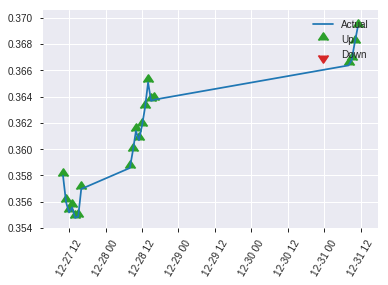


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24990284377896033
RMSE: 0.4999028343377944
LogLoss: 0.6929526405781435
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.02325884747086
Residual deviance: 309.05687769785203
AIC: 411.05687769785203
AUC: 0.4948470209339774
pr_auc: 0.48631899884460605
Gini: -0.010305958132045157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4834693006227243: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    107  0.9304   (107.0/115.0)
1      3    105  0.0278   (3.0/108.0)
Total  11   212  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483469     0.65625   211
max f2                       0.474786     0.824427  222
max f0point5                 0.483469     0.549163  211
max accuracy                 0.508279     0.533632  5
max precision                0.508279     0.833333  5
max recall                   0.474786     1         222
max specificity              0.512918     0.991304  0
max absolute_mcc             0.508279     0.116132  5
max min_per_class_accuracy   0.494413     0.490741  105
max mean_per_class_accuracy  0.500816     0.525282  51

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.510833           1.37654   1.37654            0.666667         0.512221  0.666667                    0.512221            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.50859            2.06481   1.65185            1                0.509045  0.8                         0.510951            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.508048           1.03241   1.47487            0.5              0.508219  0.714286                    0.51017             0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.50772            0         1.14712            0                0.507875  0.555556                    0.50966             0               0.0462963                  -100      14.7119
    5        0.0538117                   0.507384           0.688272  1.03241            0.333333         0.507538  0.5                         0.50913             0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.505411           0.563131  0.807971           0.272727         0.506593  0.391304                    0.507917            0.0277778       0.0833333                  -43.6869  -19.2029
    7        0.152466                    0.503735           1.50168   1.03241            0.727273         0.5047    0.5                         0.506876            0.0740741       0.157407                   50.1684   3.24074
    8        0.201794                    0.502223           1.31397   1.10123            0.636364         0.502933  0.533333                    0.505912            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.499274           0.750842  0.98618            0.363636         0.500577  0.477612                    0.504161            0.0740741       0.296296                   -24.9158  -1.38198
    10       0.399103                    0.496743           0.844697  0.951207           0.409091         0.498112  0.460674                    0.502666            0.0833333       0.37963                    -15.5303  -4.87932
    11       0.502242                    0.493986           1.07729   0.9771             0.521739         0.494931  0.473214                    0.501077            0.111111        0.490741                   7.72947   -2.29001
    12       0.600897                    0.492404           1.03241   0.98618            0.5              0.493021  0.477612                    0.499754            0.101852        0.592593                   3.24074   -1.38198
    13       0.699552                    0.491144           0.938552  0.979463           0.454545         0.491846  0.474359                    0.498639            0.0925926       0.685185                   -6.14478  -2.05366
    14       0.798206                    0.488884           0.938552  0.974407           0.454545         0.490055  0.47191                     0.497578            0.0925926       0.777778                   -6.14478  -2.5593
    15       0.896861                    0.48611            1.40783   1.02208            0.681818         0.487899  0.495                       0.496513            0.138889        0.916667                   40.7828   2.20833
    16       1                           0.474786           0.807971  1                  0.391304         0.482228  0.484305                    0.49504    

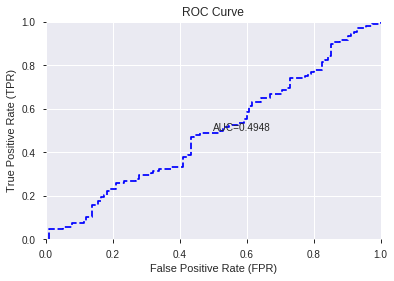

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


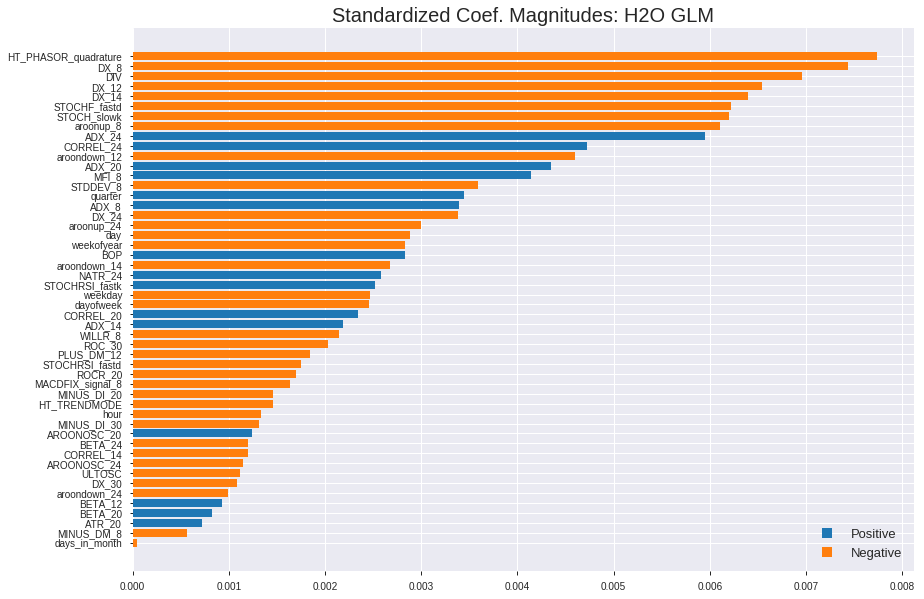

'log_likelihood'
--2019-08-26 17:53:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.186.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.186.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_175353_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_175353_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['HT_PHASOR_quadrature',
 'DX_8',
 'DIV',
 'DX_12',
 'DX_14',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'ADX_24',
 'CORREL_24',
 'aroondown_12',
 'ADX_20',
 'MFI_8',
 'STDDEV_8',
 'quarter',
 'ADX_8',
 'DX_24',
 'aroonup_24',
 'day',
 'weekofyear',
 'BOP',
 'aroondown_14',
 'NATR_24',
 'STOCHRSI_fastk',
 'weekday',
 'dayofweek',
 'CORREL_20',
 'ADX_14',
 'WILLR_8',
 'ROC_30',
 'PLUS_DM_12',
 'STOCHRSI_fastd',
 'ROCR_20',
 'MACDFIX_signal_8',
 'MINUS_DI_20',
 'HT_TRENDMODE',
 'hour',
 'MINUS_DI_30',
 'AROONOSC_20',
 'BETA_24',
 'CORREL_14',
 'AROONOSC_24',
 'ULTOSC',
 'DX_30',
 'aroondown_24',
 'BETA_12',
 'BETA_20',
 'ATR_20',
 'MINUS_DM_8',
 'days_in_month']

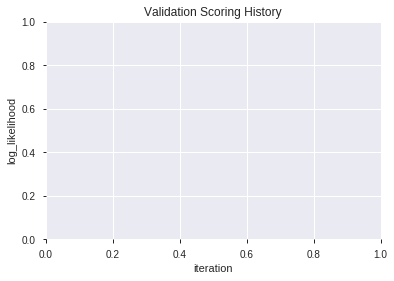

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_175404_model_6  0.508857  0.701176              0.458776  0.503838  0.253853
1  XGBoost_grid_1_AutoML_20190826_175404_model_5  0.492512  0.731337              0.500000  0.517040  0.267330
2  XGBoost_grid_1_AutoML_20190826_175404_model_7  0.490499  0.723713              0.500000  0.514083  0.264281
3  XGBoost_grid_1_AutoML_20190826_175404_model_2  0.484622  0.702787              0.500000  0.504682  0.254704
4  XGBoost_grid_1_AutoML_20190826_175404_model_1  0.481965  0.706775              0.491304  0.506640  0.256684
5               XGBoost_2_AutoML_20190826_175404  0.470531  0.710137              0.449235  0.508308  0.258377
6  XGBoost_grid_1_AutoML_20190826_175404_model_4  0.446135  0.711476              0.500000  0.508897  0.258976
7               XGBoost_3_AutoML_20190826_175404  0.445974  0.711517              0.482609  0.509018  0.259099
8  XGBoost_grid_1_AutoML_20190826_175404_model_3  0.443881  0.716999              0.500000  0.511501  0.261633
9               XGBoost_1_AutoML_20190826_175404  0.440821  0.726879              0.500000  0.516000  0.266256

variable  relative_importance  scaled_importance  percentage
0                    DIV           432.272705           1.000000    0.072802
1   HT_PHASOR_quadrature           272.630066           0.630690    0.045916
2                 ADX_14           251.853516           0.582626    0.042417
3                    BOP           242.801025           0.561685    0.040892
4               STDDEV_8           208.075058           0.481351    0.035044
5                  ADX_8           197.362686           0.456570    0.033239
6             PLUS_DM_12           189.958466           0.439441    0.031992
7            STOCH_slowk           186.739960           0.431996    0.031450
8                BETA_12           175.365295           0.405682    0.029535
9                  MFI_8           175.258987           0.405436    0.029517
10                ULTOSC           162.806458           0.376629    0.027420
11               WILLR_8           161.603958           0.373847    0.027217
12                ADX_24           149.910782           0.346797    0.025248
13                  DX_8           140.930328           0.326022    0.023735
14               BETA_24           139.934677           0.323719    0.023568
15                ADX_20           139.874695           0.323580    0.023557
16               BETA_20           136.042999           0.314716    0.022912
17                 DX_12           132.389725           0.306264    0.022297
18             CORREL_24           128.661224           0.297639    0.021669
19                   day           126.531479           0.292712    0.021310
20        STOCHRSI_fastd           126.340088           0.292269    0.021278
21                ROC_30           122.570526           0.283549    0.020643
22               NATR_24           122.114906           0.282495    0.020566
23                 DX_14           115.657318           0.267556    0.019479
24           MINUS_DI_30           110.564323           0.255774    0.018621
25                ATR_20           108.574982           0.251172    0.018286
26          aroondown_24           100.531097           0.232564    0.016931
27             CORREL_14            98.372551           0.227571    0.016568
28                  hour            96.964722           0.224314    0.016331
29               ROCR_20            95.509987           0.220948    0.016086
30            MINUS_DM_8            90.976067           0.210460    0.015322
31                 DX_30            90.730461           0.209892    0.015281
32           MINUS_DI_20            88.321381           0.204319    0.014875
33      MACDFIX_signal_8            87.455994           0.202317    0.014729
34            aroonup_24            86.654602           0.200463    0.014594
35           AROONOSC_20            75.093018           0.173717    0.012647
36          aroondown_12            73.817795           0.170767    0.012432
37                 DX_24            69.797264           0.161466    0.011755
38           AROONOSC_24            68.829926           0.159228    0.011592
39            weekofyear            66.209007           0.153165    0.011151
40        STOCHRSI_fastk            65.094887           0.150588    0.010963
41             CORREL_20            57.196148           0.132315    0.009633
42             dayofweek            40.193413           0.092982    0.006769
43          aroondown_14            34.834713           0.080585    0.005867
44             aroonup_8            31.525162           0.072929    0.005309
45          STOCHF_fastd            19.111721           0.044212    0.003219
46               weekday            18.164320           0.042021    0.003059
47          HT_TRENDMODE            11.967956           0.027686    0.002016
48         days_in_month             8.958256           0.020724    0.001509
49               quarter             4.472653           0.010347    0.000753

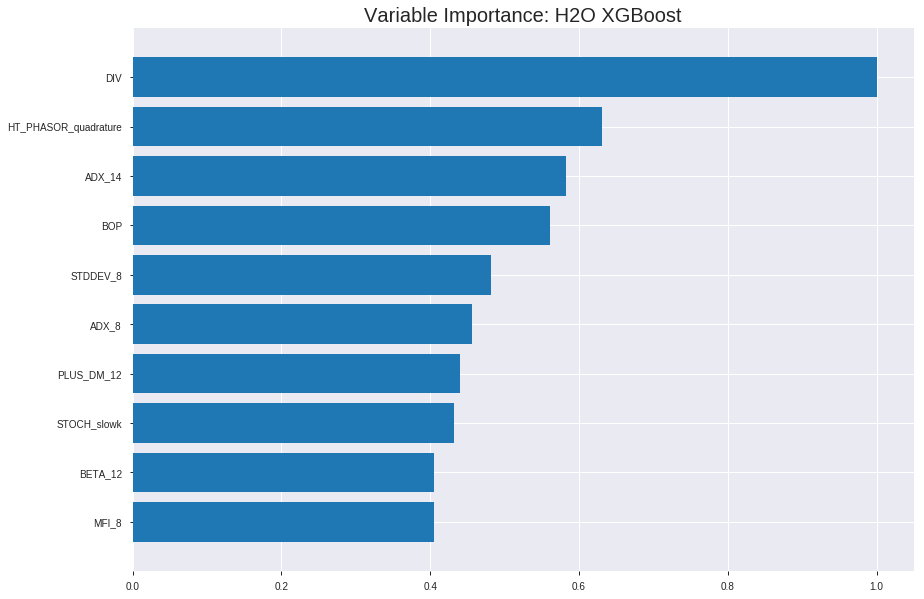

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_175404_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18705640412883587
RMSE: 0.4325001781835886
LogLoss: 0.5643370174297039
Mean Per-Class Error: 0.13680479825517988
AUC: 0.938339777271075
pr_auc: 0.9351375951599172
Gini: 0.87667955454215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47624504566192627: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      619  167  0.2125   (167.0/786.0)
1      54   716  0.0701   (54.0/770.0)
Total  673  883  0.142    (221.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476245     0.866304  221
max f2                       0.468127     0.909431  229
max f0point5                 0.510665     0.881275  182
max accuracy                 0.510073     0.863111  183
max precision                0.784549     1         0
max recall                   0.331184     1         363
max specificity              0.784549     1         0
max absolute_mcc             0.510073     0.729151  183
max min_per_class_accuracy   0.49631      0.860051  198
max mean_per_class_accuracy  0.49344      0.863195  201

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.46 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.706532           2.02078    2.02078            1                0.73147   1                           0.73147             0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.686821           2.02078    2.02078            1                0.695399  1                           0.713434            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.674677           2.02078    2.02078            1                0.680588  1                           0.702951            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.666003           2.02078    2.02078            1                0.669884  1                           0.694553            0.0207792       0.0818182                  102.078   102.078
    5        0.0501285                   0.656749           2.02078    2.02078            1                0.661237  1                           0.688146            0.0194805       0.101299                   102.078   102.078
    6        0.100257                    0.623522           1.94306    1.98192            0.961538         0.637398  0.980769                    0.662772            0.0974026       0.198701                   94.3057   98.1918
    7        0.150386                    0.602406           1.99487    1.98624            0.987179         0.612745  0.982906                    0.646097            0.1             0.298701                   99.4872   98.6236
    8        0.200514                    0.584676           1.94306    1.97544            0.961538         0.593418  0.977564                    0.632927            0.0974026       0.396104                   94.3057   97.5441
    9        0.300129                    0.553317           1.87737    1.94289            0.929032         0.569576  0.961456                    0.6119              0.187013        0.583117                   87.7369   94.2891
    10       0.400386                    0.523082           1.61921    1.86184            0.801282         0.536794  0.921348                    0.593094            0.162338        0.745455                   61.9214   86.1842
    11       0.5                         0.494382           1.2255     1.73506            0.606452         0.509038  0.858612                    0.576347            0.122078        0.867532                   22.5505   73.5065
    12       0.600257                    0.467078           0.790176   1.57725            0.391026         0.480789  0.780514                    0.560387            0.0792208       0.946753                   -20.9824  57.7246
    13       0.699871                    0.436442           0.325932   1.39914            0.16129          0.452126  0.692378                    0.544978            0.0324675       0.979221                   -67.4068  39.9144
    14       0.800129                    0.400567           0.116583   1.23844            0.0576923        0.418846  0.612851                    0.529173            0.0116883       0.990909                   -88.3417  23.8437
    15       0.899743                    0.363231           0.0782237  1.10999            0.0387097        0.381933  0.549286                    0.512872            0.00779221      0.998701                   -92.1776  10.9985
    16       1                           0.206346           0.0129537  1                  0.00641026       0.330301  0.494859                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25568942061840266
RMSE: 0.505657414282044
LogLoss: 0.7051009278164314
Mean Per-Class Error: 0.4608571544254596
AUC: 0.5017410316624827
pr_auc: 0.5083989256458366
Gini: 0.0034820633249654787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2908334732055664: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    233  1        (233.0/233.0)
1      0    212  0        (0.0/212.0)
Total  0    445  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290833     0.645358  399
max f2                       0.290833     0.819799  399
max f0point5                 0.290833     0.532129  399
max accuracy                 0.567648     0.550562  82
max precision                0.682515     0.818182  10
max recall                   0.290833     1         399
max specificity              0.782907     0.995708  0
max absolute_mcc             0.655047     0.123891  17
max min_per_class_accuracy   0.491195     0.5       198
max mean_per_class_accuracy  0.55022      0.539143  104

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.722568           1.25943   1.25943            0.6              0.748674  0.6                         0.748674            0.0141509       0.0141509                  25.9434   25.9434
    2        0.0202247                   0.686534           2.09906   1.6326             1                0.697921  0.777778                    0.726117            0.0188679       0.0330189                  109.906   63.26
    3        0.0314607                   0.666399           1.25943   1.49933            0.6              0.677354  0.714286                    0.708702            0.0141509       0.0471698                  25.9434   49.9326
    4        0.0404494                   0.653905           2.09906   1.6326             1                0.66204   0.777778                    0.698332            0.0188679       0.0660377                  109.906   63.26
    5        0.0516854                   0.641699           0.419811  1.36895            0.2              0.649351  0.652174                    0.687684            0.00471698      0.0707547                  -58.0189  36.895
    6        0.101124                    0.602031           1.04953   1.21279            0.5              0.618588  0.577778                    0.653904            0.0518868       0.122642                   4.95283   21.2788
    7        0.150562                    0.583325           1.04953   1.15918            0.5              0.591465  0.552239                    0.633402            0.0518868       0.174528                   4.95283   15.9181
    8        0.2                         0.567698           1.24035   1.17925            0.590909         0.575834  0.561798                    0.619171            0.0613208       0.235849                   24.0352   17.9245
    9        0.301124                    0.541193           0.932914  1.09652            0.444444         0.553497  0.522388                    0.597117            0.0943396       0.330189                   -6.7086   9.65221
    10       0.4                         0.510649           0.810999  1.02594            0.386364         0.525164  0.488764                    0.579331            0.0801887       0.410377                   -18.9001  2.59434
    11       0.501124                    0.490228           0.886268  0.997758           0.422222         0.499958  0.475336                    0.563314            0.0896226       0.5                        -11.3732  -0.224215
    12       0.6                         0.473404           0.906411  0.982704           0.431818         0.482274  0.468165                    0.549959            0.0896226       0.589623                   -9.35892  -1.72956
    13       0.698876                    0.44985            0.906411  0.97191            0.431818         0.461642  0.463023                    0.537464            0.0896226       0.679245                   -9.35892  -2.80895
    14       0.8                         0.425364           0.886268  0.961085           0.422222         0.436519  0.457865                    0.524704            0.0896226       0.768868                   -11.3732  -3.89151
    15       0.898876                    0.389399           1.09723   0.976061           0.522727         0.408867  0.465                       0.511962            0.108491        0.877358                   9.72341   -2.39387
    16       1                           0.290833           1.21279   1                  0.577778         0.358298  0.476404                    0.496423        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:54:13  5.774 sec   0                  0.5              0.693147            0.5             0                  1                0.505141                         0.5                0.693147              0.5               0                    1                  0.523596
    2019-08-26 17:54:13  5.847 sec   5                  0.491524         0.676306            0.732848        0.710945           1.89448          0.349614                         0.502586           0.698346              0.461313          0.454967             1.25943            0.523596
    2019-08-26 17:54:13  5.888 sec   10                 0.48279          0.659177            0.809664        0.789507           1.89448          0.292416                         0.502273           0.697729              0.486072          0.470988             1.25943            0.514607
    2019-08-26 17:54:13  5.926 sec   15                 0.476658         0.647256            0.83074         0.822272           1.89448          0.275064                         0.502988           0.699183              0.490364          0.479362             1.67925            0.523596
    2019-08-26 17:54:13  5.966 sec   20                 0.470211         0.634826            0.851936        0.848167           2.02078          0.239717                         0.501952           0.697052              0.502794          0.501171             1.67925            0.507865
    2019-08-26 17:54:13  6.008 sec   25                 0.464346         0.623583            0.867527        0.865607           2.02078          0.229434                         0.501636           0.696466              0.511205          0.511158             1.67925            0.523596
    2019-08-26 17:54:13  6.058 sec   30                 0.457264         0.610205            0.893944        0.89025            2.02078          0.197301                         0.501982           0.697235              0.510497          0.507572             1.25943            0.523596
    2019-08-26 17:54:13  6.110 sec   35                 0.450873         0.598228            0.909514        0.906188           2.02078          0.180591                         0.502895           0.699076              0.503148          0.508422             1.25943            0.519101
    2019-08-26 17:54:13  6.156 sec   40                 0.444404         0.586237            0.923239        0.919594           2.02078          0.154242                         0.503496           0.70032               0.502176          0.511592             1.25943            0.519101
    2019-08-26 17:54:13  6.209 sec   45                 0.437504         0.573546            0.935452        0.931947           2.02078          0.138817                         0.504325           0.702285              0.507399          0.511747             1.25943            0.523596
    2019-08-26 17:54:13  6.257 sec   50                 0.4325           0.564337            0.93834         0.935138           2.02078          0.142031                         0.505657           0.705101              0.501741          0.508399             1.25943            0.523596

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
DIV                   432.272705078125       1.0                   0.0728024834526772
HT_PHASOR_quadrature  272.63006591796875     0.6306899850840596    0.04591579720285148
ADX_14                251.853515625          0.5826264593307651    0.04241665316451993
BOP                   242.801025390625       0.5616848404683413    0.040892051303816054
STDDEV_8              208.07505798339844     0.48135136810406026   0.035043575011319376
---                   ---                    ---                   ---
STOCHF_fastd          19.11172103881836      0.044212185535434816  0.0032187569058501875
weekday               18.16431999206543      0.042020511077104854  0.003059197562363965
HT_TRENDMODE          11.967955589294434     0.027686123710104378  0.0020156185632736476
days_in_month         8.958255767822266      0.020723621136808146  0.0015087310848920265
quarter               4.472653388977051      0.010346832766525715  0.0007532751212726066


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5291479820627802)

('F1', 0.6557377049180328)

('auc', 0.5088566827697263)

('logloss', 0.7011759716633206)

('mean_per_class_error', 0.4587761674718196)

('rmse', 0.5038381198846026)

('mse', 0.25385285104885114)

xgboost prediction progress: |████████████████████████████████████████████| 100%


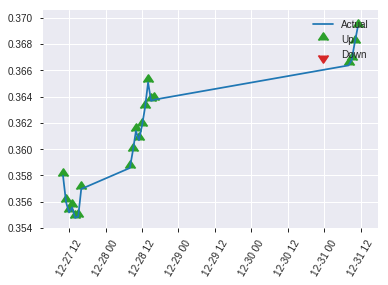


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25385285104885114
RMSE: 0.5038381198846026
LogLoss: 0.7011759716633206
Mean Per-Class Error: 0.4587761674718196
AUC: 0.5088566827697263
pr_auc: 0.47457088759756794
Gini: 0.017713365539452575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40438103675842285: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   97   0.8435   (97.0/115.0)
1      8    100  0.0741   (8.0/108.0)
Total  26   197  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404381     0.655738  196
max f2                       0.330057     0.825688  221
max f0point5                 0.404381     0.558036  196
max accuracy                 0.404381     0.529148  196
max precision                0.525696     0.514286  69
max recall                   0.330057     1         221
max specificity              0.706782     0.991304  0
max absolute_mcc             0.404381     0.128387  196
max min_per_class_accuracy   0.489885     0.495652  111
max mean_per_class_accuracy  0.404381     0.541224  196

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.663691           0.688272  0.688272           0.333333         0.691363  0.333333                    0.691363            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.638096           1.03241   0.825926           0.5              0.643447  0.4                         0.672197            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.631861           0         0.589947           0                0.635616  0.285714                    0.661745            0               0.0185185                  -100      -41.0053
    4        0.0403587                   0.622413           1.03241   0.688272           0.5              0.627827  0.333333                    0.654207            0.00925926      0.0277778                  3.24074   -31.1728
    5        0.0538117                   0.602153           0.688272  0.688272           0.333333         0.612475  0.333333                    0.643774            0.00925926      0.037037                   -31.1728  -31.1728
    6        0.103139                    0.572899           1.12626   0.897746           0.545455         0.584534  0.434783                    0.615442            0.0555556       0.0925926                  12.6263   -10.2254
    7        0.152466                    0.556787           1.12626   0.971678           0.545455         0.564293  0.470588                    0.598894            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.540923           0.938552  0.96358            0.454545         0.547226  0.466667                    0.586264            0.0462963       0.194444                   -6.14478  -3.64198
    9        0.300448                    0.527704           1.22012   1.04782            0.590909         0.534399  0.507463                    0.569234            0.12037         0.314815                   22.0118   4.78165
    10       0.399103                    0.50585            1.03241   1.04401            0.5              0.515482  0.505618                    0.555947            0.101852        0.416667                   3.24074   4.40075
    11       0.502242                    0.489885           0.807971  0.995536           0.391304         0.497449  0.482143                    0.543934            0.0833333       0.5                        -19.2029  -0.446429
    12       0.600897                    0.474882           1.12626   1.017              0.545455         0.483627  0.492537                    0.534033            0.111111        0.611111                   12.6263   1.69983
    13       0.699552                    0.456296           0.938552  1.00594            0.454545         0.464724  0.487179                    0.524258            0.0925926       0.703704                   -6.14478  0.593542
    14       0.798206                    0.432345           1.12626   1.02081            0.545455         0.444619  0.494382                    0.514415            0.111111        0.814815                   12.6263   2.08073
    15       0.896861                    0.398674           1.12626   1.03241            0.545455         0.416847  0.5                         0.503683            0.111111        0.925926                   12.6263   3.24074
    16       1                           0.329029           0.718196  1                  0.347826         0.372436  0.484305                    0.4901

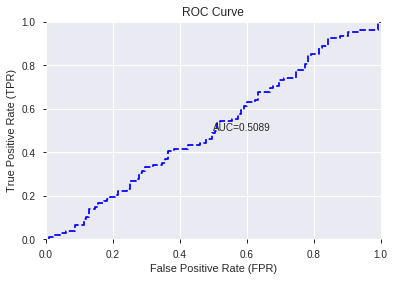

This function is available for GLM models only


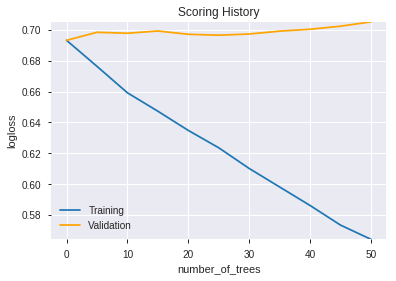

--2019-08-26 17:54:18--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_175404_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_175404_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'HT_PHASOR_quadrature',
 'ADX_14',
 'BOP',
 'STDDEV_8',
 'ADX_8',
 'PLUS_DM_12',
 'STOCH_slowk',
 'BETA_12',
 'MFI_8',
 'ULTOSC',
 'WILLR_8',
 'ADX_24',
 'DX_8',
 'BETA_24',
 'ADX_20',
 'BETA_20',
 'DX_12',
 'CORREL_24',
 'day',
 'STOCHRSI_fastd',
 'ROC_30',
 'NATR_24',
 'DX_14',
 'MINUS_DI_30',
 'ATR_20',
 'aroondown_24',
 'CORREL_14',
 'hour',
 'ROCR_20',
 'MINUS_DM_8',
 'DX_30',
 'MINUS_DI_20',
 'MACDFIX_signal_8',
 'aroonup_24',
 'AROONOSC_20',
 'aroondown_12',
 'DX_24',
 'AROONOSC_24',
 'weekofyear',
 'STOCHRSI_fastk',
 'CORREL_20',
 'dayofweek',
 'aroondown_14',
 'aroonup_8',
 'STOCHF_fastd',
 'weekday',
 'HT_TRENDMODE',
 'days_in_month',
 'quarter']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190826_175424_model_1  0.555233  0.710673               0.48752  0.508596  0.25867

variable  relative_importance  scaled_importance    percentage
0           CDLIDENTICAL3CROWS         3.506675e-02           1.000000  1.763872e-02
1            CDLSTALLEDPATTERN         3.333405e-02           0.950588  1.676717e-02
2                    CDLHAMMER         2.947637e-02           0.840579  1.482674e-02
3                   CDLHIKKAKE         2.861997e-02           0.816157  1.439596e-02
4           CDLEVENINGDOJISTAR         2.578554e-02           0.735327  1.297024e-02
...                        ...                  ...                ...           ...
1034  BBANDS_middleband_20_7_3         2.368640e-06           0.000068  1.191436e-06
1035                    T3_8_5         1.599048e-06           0.000046  8.043280e-07
1036  BBANDS_middleband_30_7_5         1.113420e-06           0.000032  5.600552e-07
1037  BBANDS_middleband_30_7_4         5.747471e-07           0.000016  2.891002e-07
1038                   MA_20_2         2.250327e-07           0.000006  1.131924e-07

[1039 rows x 4 columns]

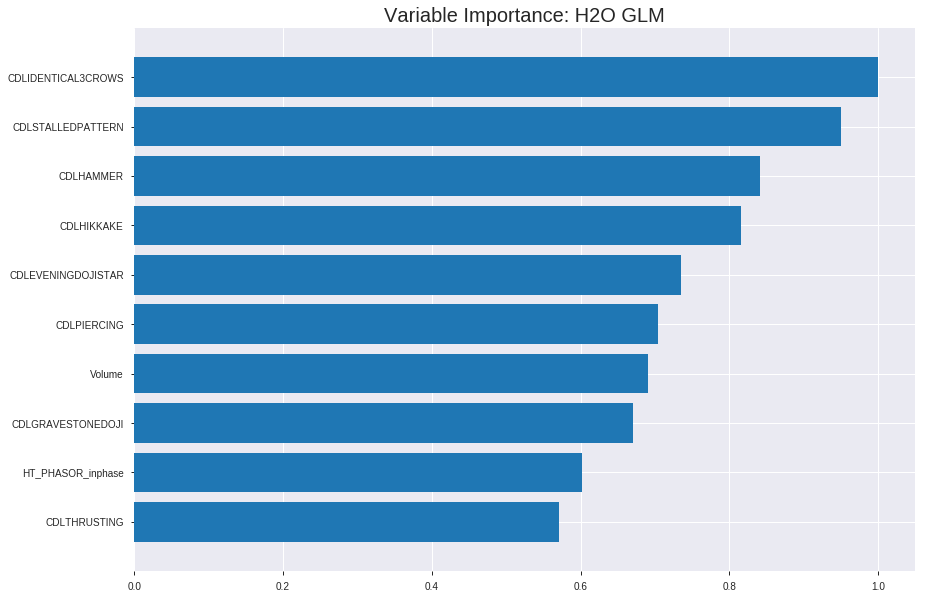

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_175424_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24228983596301473
RMSE: 0.49222945458699924
LogLoss: 0.677557738214748
Null degrees of freedom: 1555
Residual degrees of freedom: 516
Null deviance: 2156.909498581488
Residual deviance: 2108.559681324295
AIC: 4188.5596813242955
AUC: 0.618539539341066
pr_auc: 0.6238651608736349
Gini: 0.23707907868213196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39642597126278767: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   758   0.9644   (758.0/786.0)
1      4    766   0.0052   (4.0/770.0)
Total  32   1524  0.4897   (762.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396426     0.667829  375
max f2                       0.396426     0.831885  375
max f0point5                 0.514883     0.584871  140
max accuracy                 0.514883     0.6009    140
max precision                0.667576     1         0
max recall                   0.355141     1         394
max specificity              0.667576     1         0
max absolute_mcc             0.514883     0.213669  140
max min_per_class_accuracy   0.497762     0.572727  190
max mean_per_class_accuracy  0.514883     0.598974  140

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.612425           2.02078   2.02078            1                0.637538  1                           0.637538            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.583922           1.51558   1.76818            0.75             0.597557  0.875                       0.617547            0.0155844       0.0363636                  51.5584   76.8182
    3        0.0302057                   0.572712           1.4819    1.67682            0.733333         0.577853  0.829787                    0.604879            0.0142857       0.0506494                  48.1905   67.6817
    4        0.0404884                   0.565849           1.38929   1.60379            0.6875           0.569125  0.793651                    0.595799            0.0142857       0.0649351                  38.9286   60.3793
    5        0.0501285                   0.561118           1.4819    1.58035            0.733333         0.563331  0.782051                    0.589555            0.0142857       0.0792208                  48.1905   58.0353
    6        0.100257                    0.544926           1.34719   1.46377            0.666667         0.552305  0.724359                    0.57093             0.0675325       0.146753                   34.7186   46.377
    7        0.150386                    0.53452            1.29537   1.40764            0.641026         0.538911  0.696581                    0.560257            0.0649351       0.211688                   29.5371   40.7637
    8        0.200514                    0.5275             1.21765   1.36014            0.602564         0.530883  0.673077                    0.552914            0.061039        0.272727                   21.7649   36.014
    9        0.300129                    0.516264           1.23854   1.31978            0.612903         0.521945  0.653105                    0.542635            0.123377        0.396104                   23.8542   31.9781
    10       0.400386                    0.506011           0.893806  1.21312            0.442308         0.510923  0.600321                    0.534694            0.0896104       0.485714                   -10.6194  21.3116
    11       0.5                         0.49746            0.899573  1.15065            0.445161         0.501761  0.569409                    0.528133            0.0896104       0.575325                   -10.0427  15.0649
    12       0.600257                    0.487649           0.945621  1.1164             0.467949         0.492594  0.552463                    0.522197            0.0948052       0.67013                    -5.4379   11.6405
    13       0.699871                    0.476009           0.925647  1.08925            0.458065         0.482095  0.539027                    0.516489            0.0922078       0.762338                   -7.43527  8.92538
    14       0.800129                    0.460814           0.932667  1.06963            0.461538         0.468764  0.529317                    0.510509            0.0935065       0.855844                   -6.73327  6.96333
    15       0.899743                    0.441213           0.795274  1.03926            0.393548         0.451075  0.514286                    0.503929            0.0792208       0.935065                   -20.4726  3.92579
    16       1                           0.315832           0.647686  1                  0.320513         0.413458  0.494859                    0.494859           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25227412690250395
RMSE: 0.5022689786384422
LogLoss: 0.6977564044572496
Null degrees of freedom: 444
Residual degrees of freedom: -595
Null deviance: 616.5161536496719
Residual deviance: 621.0031999669521
AIC: 2701.0031999669523
AUC: 0.5254069155397199
pr_auc: 0.48501397511812
Gini: 0.05081383107943971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3929202984479937: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    233  1        (233.0/233.0)
1      0    212  0        (0.0/212.0)
Total  0    445  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39292      0.645358  399
max f2                       0.39292      0.819799  399
max f0point5                 0.513036     0.55      266
max accuracy                 0.513183     0.548315  264
max precision                0.708791     1         0
max recall                   0.39292      1         399
max specificity              0.708791     1         0
max absolute_mcc             0.513036     0.119451  266
max min_per_class_accuracy   0.53089      0.515021  201
max mean_per_class_accuracy  0.513036     0.556341  266

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 53.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.617648           0.839623  0.839623           0.4              0.645942  0.4                         0.645942            0.00943396      0.00943396                 -16.0377  -16.0377
    2        0.0202247                   0.609258           1.04953   0.932914           0.5              0.613904  0.444444                    0.631703            0.00943396      0.0188679                  4.95283   -6.7086
    3        0.0314607                   0.601674           1.25943   1.04953            0.6              0.606624  0.5                         0.622746            0.0141509       0.0330189                  25.9434   4.95283
    4        0.0404494                   0.59681            1.57429   1.16614            0.75             0.599588  0.555556                    0.6176              0.0141509       0.0471698                  57.4292   16.6143
    5        0.0516854                   0.592315           0.419811  1.0039             0.2              0.59447   0.478261                    0.612572            0.00471698      0.0518868                  -58.0189  0.389664
    6        0.101124                    0.577484           0.954117  0.97956            0.454545         0.58269   0.466667                    0.597963            0.0471698       0.0990566                  -4.58834  -2.04403
    7        0.150562                    0.569398           1.14494   1.03386            0.545455         0.572418  0.492537                    0.589575            0.0566038       0.15566                    14.494    3.38637
    8        0.2                         0.564492           1.14494   1.06132            0.545455         0.566401  0.505618                    0.583846            0.0566038       0.212264                   14.494    6.13208
    9        0.301124                    0.554223           0.932914  1.0182             0.444444         0.558927  0.485075                    0.575478            0.0943396       0.306604                   -6.7086   1.81991
    10       0.4                         0.541172           1.00182   1.01415            0.477273         0.547825  0.483146                    0.568643            0.0990566       0.40566                    0.182247  1.41509
    11       0.501124                    0.53089            1.1195    1.03541            0.533333         0.535644  0.493274                    0.561984            0.113208        0.518868                   11.9497   3.54091
    12       0.6                         0.519899           1.14494   1.05346            0.545455         0.525896  0.501873                    0.556037            0.113208        0.632075                   14.494    5.34591
    13       0.698876                    0.507836           1.14494   1.0664             0.545455         0.51484   0.508039                    0.550208            0.113208        0.745283                   14.494    6.64017
    14       0.8                         0.498493           0.65304   1.01415            0.311111         0.503128  0.483146                    0.544257            0.0660377       0.811321                   -34.696   1.41509
    15       0.898876                    0.486006           1.09723   1.02329            0.522727         0.492983  0.4875                      0.538617            0.108491        0.919811                   9.72341   2.32901
    16       1                           0.39292            0.792977  1                  0.377778         0.465819  0.476404                    0.531255      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 17:54:27  0.000 sec   2            3.1       1034          1.37469           1.39845
    2019-08-26 17:54:29  1.882 sec   4            2.2       1036          1.37189           1.3978
    2019-08-26 17:54:30  3.782 sec   6            1.6       1036          1.36855           1.39704
    2019-08-26 17:54:32  5.648 sec   8            1.2       1039          1.36463           1.39631
    2019-08-26 17:54:34  7.486 sec   10           0.86      1039          1.36013           1.39574
    2019-08-26 17:54:36  9.318 sec   12           0.63      1040          1.35512           1.39551
    2019-08-26 17:54:38  11.183 sec  14           0.46      1040          1.34967           1.39578
    2019-08-26 17:54:40  13.021 sec  16           0.33      1040          1.34391           1.39672
    2019-08-26 17:54:42  14.934 sec  18           0.24      1040          1.33794           1.39841
    2019-08-26 17:54:43  16.809 sec  20           0.18      1040          1.33188           1.40094
    2019-08-26 17:54:45  18.722 sec  22           0.13      1040          1.32581           1.40438

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.654320987654321)

('auc', 0.5552334943639292)

('logloss', 0.7106734652763449)

('mean_per_class_error', 0.412962962962963)

('rmse', 0.5085958119332666)

('mse', 0.2586696999160587)

glm prediction progress: |████████████████████████████████████████████████| 100%


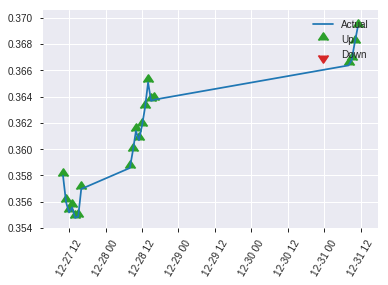


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2586696999160587
RMSE: 0.5085958119332666
LogLoss: 0.7106734652763449
Null degrees of freedom: 222
Residual degrees of freedom: -817
Null deviance: 309.02325884747086
Residual deviance: 316.9603655132499
AIC: 2396.96036551325
AUC: 0.5552334943639292
pr_auc: 0.5390289775259526
Gini: 0.11046698872785843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5168766668959309: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    110  0.9565   (110.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  7    216  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516877     0.654321  215
max f2                       0.371788     0.824427  222
max f0point5                 0.591461     0.574074  107
max accuracy                 0.592185     0.587444  103
max precision                0.757819     1         0
max recall                   0.371788     1         222
max specificity              0.757819     1         0
max absolute_mcc             0.591461     0.174074  107
max min_per_class_accuracy   0.591461     0.574074  107
max mean_per_class_accuracy  0.591461     0.587037  107

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 58.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.686963           1.37654   1.37654            0.666667         0.735874  0.666667                    0.735874            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.661977           1.03241   1.23889            0.5              0.662226  0.6                         0.706415            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.656832           1.03241   1.17989            0.5              0.659773  0.571429                    0.693089            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.653902           2.06481   1.37654            1                0.656159  0.666667                    0.684882            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.652241           0.688272  1.20448            0.333333         0.652992  0.583333                    0.676909            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.640943           1.31397   1.25684            0.636364         0.644218  0.608696                    0.661274            0.0648148       0.12963                    31.3973   25.6844
    7        0.152466                    0.628145           1.31397   1.27533            0.636364         0.633007  0.617647                    0.652129            0.0648148       0.194444                   31.3973   27.5327
    8        0.201794                    0.621035           0.938552  1.193              0.454545         0.625173  0.577778                    0.64554             0.0462963       0.240741                   -6.14478  19.3004
    9        0.300448                    0.607339           1.03241   1.14027            0.5              0.61277   0.552239                    0.63478             0.101852        0.342593                   3.24074   14.0271
    10       0.399103                    0.597231           1.22012   1.16001            0.590909         0.601882  0.561798                    0.626647            0.12037         0.462963                   22.0118   16.0008
    11       0.502242                    0.589757           1.16707   1.16146            0.565217         0.593199  0.5625                      0.619778            0.12037         0.583333                   16.7069   16.1458
    12       0.600897                    0.582024           0.375421  1.03241            0.181818         0.586015  0.5                         0.614235            0.037037        0.62037                    -62.4579  3.24074
    13       0.699552                    0.570596           0.656987  0.979463           0.318182         0.575345  0.474359                    0.608751            0.0648148       0.685185                   -34.3013  -2.05366
    14       0.798206                    0.556214           1.22012   1.00921            0.590909         0.565027  0.488764                    0.603347            0.12037         0.805556                   22.0118   0.920724
    15       0.896861                    0.534201           0.938552  1.00144            0.454545         0.545723  0.485                       0.597008            0.0925926       0.898148                   -6.14478  0.143519
    16       1                           0.371788           0.98752   1                  0.478261         0.508752  0.484305                    0.587906      

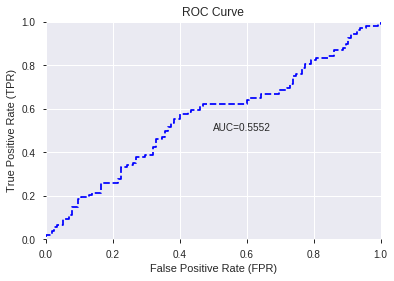

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


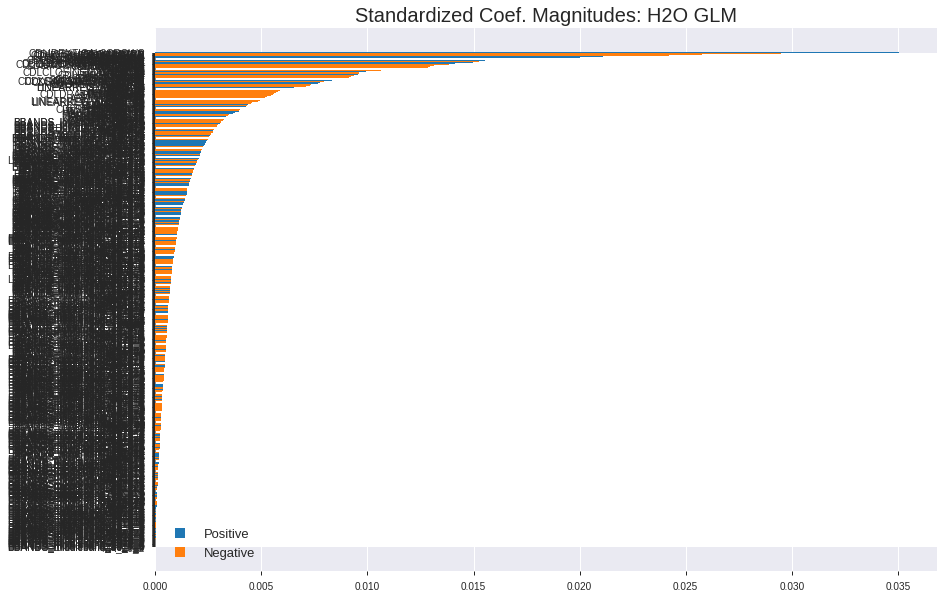

'log_likelihood'
--2019-08-26 17:55:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_175424_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_175424_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

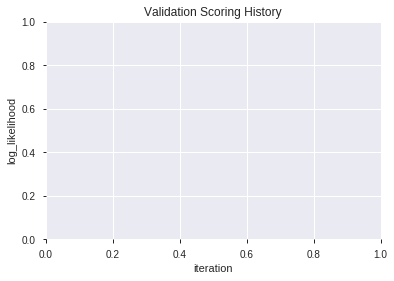

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190826_175511  0.513043  0.730532              0.495652  0.517489  0.267795
1  XGBoost_grid_1_AutoML_20190826_175511_model_5  0.506039  0.896955              0.495652  0.576302  0.332124
2               XGBoost_3_AutoML_20190826_175511  0.500403  0.755612              0.495652  0.528752  0.279579
3  XGBoost_grid_1_AutoML_20190826_175511_model_7  0.499195  0.788598              0.495652  0.541308  0.293015
4  XGBoost_grid_1_AutoML_20190826_175511_model_2  0.467713  0.712906              0.500000  0.509714  0.259808
5  XGBoost_grid_1_AutoML_20190826_175511_model_6  0.460709  0.822832              0.500000  0.554433  0.307395
6  XGBoost_grid_1_AutoML_20190826_175511_model_1  0.457971  0.929466              0.500000  0.588103  0.345865
7               XGBoost_2_AutoML_20190826_175511  0.446135  0.720488              0.500000  0.512967  0.263135
8  XGBoost_grid_1_AutoML_20190826_175511_model_3  0.433736  0.815550              0.495652  0.551899  0.304592
9  XGBoost_grid_1_AutoML_20190826_175511_model_4  0.399678  0.723463              0.495652  0.514717  0.264933

variable  relative_importance  scaled_importance  percentage
0                     Volume           140.883911           1.000000    0.017976
1          HT_PHASOR_inphase           136.130066           0.966257    0.017370
2                  STDDEV_12           118.528305           0.841319    0.015124
3                    WILLR_8           108.779686           0.772123    0.013880
4                        BOP           104.305954           0.740368    0.013309
..                       ...                  ...                ...         ...
419   BBANDS_upperband_8_0_2             0.611863           0.004343    0.000078
420   BBANDS_upperband_8_4_2             0.581083           0.004125    0.000074
421                 MAVP_8_0             0.261496           0.001856    0.000033
422             HT_TRENDMODE             0.101139           0.000718    0.000013
423  BBANDS_upperband_24_5_5             0.084528           0.000600    0.000011

[424 rows x 4 columns]

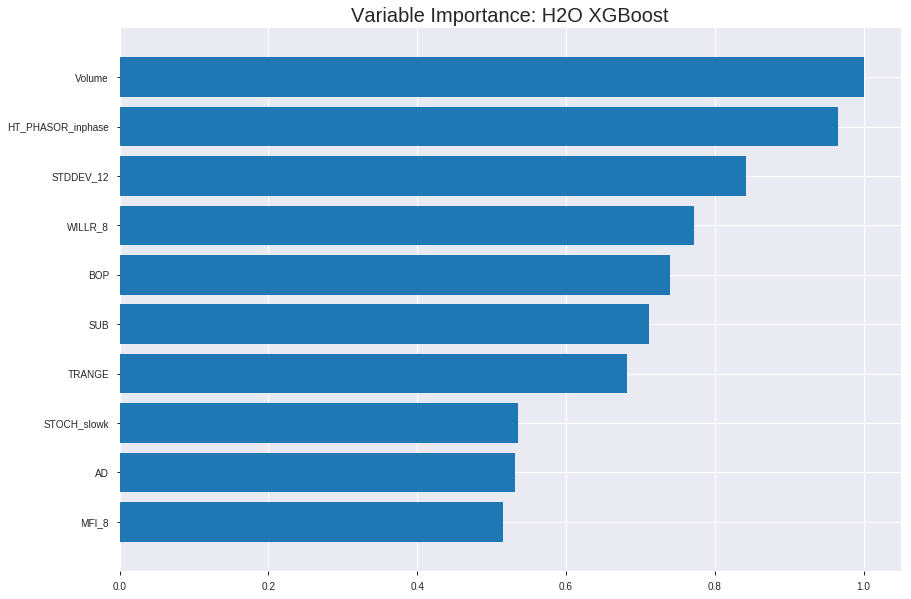

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190826_175511


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13934849692684628
RMSE: 0.3732941158481423
LogLoss: 0.46143922472942744
Mean Per-Class Error: 0.05785995175308156
AUC: 0.9850442814183272
pr_auc: 0.9831476628155864
Gini: 0.9700885628366545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49498798946539563: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      742  44   0.056    (44.0/786.0)
1      46   724  0.0597   (46.0/770.0)
Total  788  768  0.0578   (90.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494988     0.941482  200
max f2                       0.457944     0.956522  220
max f0point5                 0.530741     0.951503  179
max accuracy                 0.497266     0.942159  198
max precision                0.863626     1         0
max recall                   0.367343     1         288
max specificity              0.863626     1         0
max absolute_mcc             0.497266     0.884393  198
max min_per_class_accuracy   0.49378      0.941476  201
max mean_per_class_accuracy  0.494988     0.94214   200

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.781062           2.02078    2.02078            1                0.803459  1                           0.803459            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.770867           2.02078    2.02078            1                0.776419  1                           0.789939            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.760682           2.02078    2.02078            1                0.765292  1                           0.782073            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.750675           2.02078    2.02078            1                0.755584  1                           0.775346            0.0207792       0.0818182                  102.078   102.078
    5        0.0501285                   0.739485           2.02078    2.02078            1                0.744754  1                           0.769462            0.0194805       0.101299                   102.078   102.078
    6        0.100257                    0.705946           2.02078    2.02078            1                0.722756  1                           0.746109            0.101299        0.202597                   102.078   102.078
    7        0.150386                    0.679115           2.02078    2.02078            1                0.692499  1                           0.728239            0.101299        0.303896                   102.078   102.078
    8        0.200514                    0.660944           1.99487    2.0143             0.987179         0.670331  0.996795                    0.713762            0.1             0.403896                   99.4872   101.43
    9        0.300129                    0.613213           1.98167    2.00347            0.980645         0.637328  0.991435                    0.688393            0.197403        0.601299                   98.1667   100.347
    10       0.400386                    0.555073           1.95601    1.99159            0.967949         0.58497   0.985554                    0.662496            0.196104        0.797403                   95.6011   99.1587
    11       0.5                         0.48857            1.44714    1.88312            0.716129         0.523441  0.931877                    0.634792            0.144156        0.941558                   44.7139   88.3117
    12       0.600257                    0.417927           0.492241   1.65081            0.24359          0.448988  0.816916                    0.603758            0.0493506       0.990909                   -50.7759  65.0808
    13       0.699871                    0.375141           0.0521491  1.42327            0.0258065        0.3957    0.704316                    0.574145            0.00519481      0.996104                   -94.7851  42.3267
    14       0.800129                    0.333825           0.0388611  1.2498             0.0192308        0.353682  0.618474                    0.546521            0.0038961       1                          -96.1139  24.9799
    15       0.899743                    0.286668           0          1.11143            0                0.309479  0.55                        0.520277            0               1                          -100      11.1429
    16       1                           0.159589           0          1                  0                0.254136  0.494859                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2654987590994101
RMSE: 0.5152657169843634
LogLoss: 0.7263453939065535
Mean Per-Class Error: 0.47172848003886947
AUC: 0.5073993845655519
pr_auc: 0.48127325608596766
Gini: 0.014798769131103784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3615250587463379: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   219  0.9399   (219.0/233.0)
1      5    207  0.0236   (5.0/212.0)
Total  19   426  0.5034   (224.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.361525     0.648903   380
max f2                       0.235611     0.819799   399
max f0point5                 0.361525     0.540188   380
max accuracy                 0.667752     0.537079   63
max precision                0.779441     1          0
max recall                   0.235611     1          399
max specificity              0.779441     1          0
max absolute_mcc             0.361525     0.0901713  380
max min_per_class_accuracy   0.568077     0.509434   194
max mean_per_class_accuracy  0.54223      0.528272   235

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 56.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.760793           0.839623  0.839623           0.4              0.772328  0.4                         0.772328            0.00943396      0.00943396                 -16.0377  -16.0377
    2        0.0202247                   0.74183            0.524764  0.699686           0.25             0.747126  0.333333                    0.761127            0.00471698      0.0141509                  -47.5236  -30.0314
    3        0.0314607                   0.740067           1.67925   1.04953            0.8              0.741114  0.5                         0.75398             0.0188679       0.0330189                  67.9245   4.95283
    4        0.0404494                   0.723952           1.04953   1.04953            0.5              0.733035  0.5                         0.749325            0.00943396      0.0424528                  4.95283   4.95283
    5        0.0516854                   0.71708            0.839623  1.0039             0.4              0.720429  0.478261                    0.743044            0.00943396      0.0518868                  -16.0377  0.389664
    6        0.101124                    0.687339           1.04953   1.02621            0.5              0.702351  0.488889                    0.72315             0.0518868       0.103774                   4.95283   2.62055
    7        0.150562                    0.667843           1.33576   1.12785            0.636364         0.675606  0.537313                    0.707538            0.0660377       0.169811                   33.5763   12.7851
    8        0.2                         0.653605           0.954117  1.08491            0.454545         0.661677  0.516854                    0.696202            0.0471698       0.216981                   -4.58834  8.49057
    9        0.301124                    0.620567           0.746331  0.971205           0.355556         0.636469  0.462687                    0.676142            0.0754717       0.292453                   -25.3669  -2.87947
    10       0.4                         0.594497           0.954117  0.966981           0.454545         0.60752   0.460674                    0.65918             0.0943396       0.386792                   -4.58834  -3.30189
    11       0.501124                    0.567671           1.21279   1.01658            0.577778         0.580899  0.484305                    0.643383            0.122642        0.509434                   21.2788   1.65835
    12       0.6                         0.541104           1.19265   1.0456             0.568182         0.553691  0.498127                    0.628602            0.117925        0.627358                   19.2646   4.55975
    13       0.698876                    0.514336           0.858705  1.01916            0.409091         0.526978  0.485531                    0.614225            0.0849057       0.712264                   -14.1295  1.91561
    14       0.8                         0.471629           0.746331  0.98467            0.355556         0.494225  0.469101                    0.599056            0.0754717       0.787736                   -25.3669  -1.53302
    15       0.898876                    0.422961           1.19265   1.00755            0.568182         0.452351  0.48                        0.582918            0.117925        0.90566                    19.2646   0.754717
    16       1                           0.235611           0.932914  1                  0.444444         0.357243  0.476404                    0.560097  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 17:55:11  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.505141                         0.5                0.693147              0.5               0                    1                  0.523596
    2019-08-26 17:55:12  0.874 sec   5                  0.481875         0.657441            0.834416        0.830936           2.02078          0.246144                         0.499777           0.692698              0.503148          0.486461             0.839623           0.507865
    2019-08-26 17:55:13  1.106 sec   10                 0.466671         0.628241            0.894671        0.889376           2.02078          0.177378                         0.501583           0.696327              0.512106          0.493111             0.839623           0.516854
    2019-08-26 17:55:13  1.356 sec   15                 0.452961         0.602451            0.924014        0.923304           2.02078          0.162596                         0.505281           0.703919              0.496589          0.466573             0.839623           0.505618
    2019-08-26 17:55:13  1.598 sec   20                 0.438752         0.57627             0.949509        0.9467             2.02078          0.123393                         0.50567            0.704787              0.508705          0.487465             1.25943            0.51236
    2019-08-26 17:55:13  1.831 sec   25                 0.424445         0.550244            0.95675         0.95402            2.02078          0.12018                          0.506609           0.7067                0.497429          0.476157             0.839623           0.510112
    2019-08-26 17:55:14  2.039 sec   30                 0.413477         0.530669            0.965231        0.96088            2.02078          0.090617                         0.507391           0.708467              0.505962          0.483763             1.25943            0.510112
    2019-08-26 17:55:14  2.269 sec   35                 0.402483         0.511254            0.970741        0.968232           2.02078          0.0886889                        0.509857           0.713805              0.495151          0.471648             1.25943            0.510112
    2019-08-26 17:55:14  2.487 sec   40                 0.392887         0.494549            0.974657        0.972037           2.02078          0.0803342                        0.513364           0.721576              0.499261          0.474531             0.839623           0.516854
    2019-08-26 17:55:14  2.717 sec   45                 0.382818         0.477379            0.979987        0.977621           2.02078          0.0687661                        0.513853           0.722959              0.503917          0.477928             0.839623           0.503371
    2019-08-26 17:55:14  2.995 sec   50                 0.373294         0.461439            0.985044        0.983148           2.02078          0.0578406                        0.515266           0.726345              0.507399          0.481273             0.839623           0.503371

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   140.8839111328125      1.0                    0.017976237565834233
HT_PHASOR_inphase        136.13006591796875     0.9662570042482548     0.017369665458017925
STDDEV_12                118.52830505371094     0.8413189561579765     0.015123749424535461
WILLR_8                  108.7796859741211      0.7721228428388358     0.013879863652878202
BOP                      104.30595397949219     0.7403681026512818     0.013309032899425388
---                      ---                    ---                    ---
BBANDS_upperband_8_0_2   0.6118631362915039     0.00434303059427911    7.80713497184475e-05
BBANDS_upperband_8_4_2   0.5810832977294922     0.004124553989573017   7.414396236967393e-05
MAVP_8_0                 0.26149559020996094    0.0018561068336855494  3.336581738989981e-05
HT_TRENDMODE             0.10113906860351562    0.0007178894154079165  1.2904950677370567e-05
BBANDS_upperband_24_5_5  0.08452796936035156    0.0005999831256861282  1.078543920282562e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6545454545454547)

('auc', 0.5130434782608696)

('logloss', 0.7305316774708493)

('mean_per_class_error', 0.4449677938808374)

('rmse', 0.5174888370007388)

('mse', 0.2677946964203772)

xgboost prediction progress: |████████████████████████████████████████████| 100%


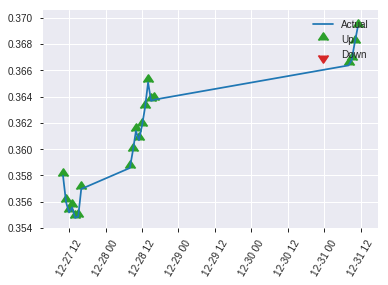


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2677946964203772
RMSE: 0.5174888370007388
LogLoss: 0.7305316774708493
Mean Per-Class Error: 0.4449677938808374
AUC: 0.5130434782608696
pr_auc: 0.5062872163781348
Gini: 0.026086956521739202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46331238746643066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    114  0.9913   (114.0/115.0)
1      0    108  0        (0.0/108.0)
Total  1    222  0.5112   (114.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463312     0.654545  221
max f2                       0.463312     0.825688  221
max f0point5                 0.492111     0.545551  208
max accuracy                 0.634283     0.560538  71
max precision                0.686333     0.64      24
max recall                   0.463312     1         221
max specificity              0.785147     0.991304  0
max absolute_mcc             0.555328     0.126889  176
max min_per_class_accuracy   0.610388     0.537037  109
max mean_per_class_accuracy  0.634283     0.555032  71

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 60.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.739892           0         0                  0                0.758218  0                           0.758218            0               0                          -100      -100
    2        0.0224215                   0.722782           2.06481   0.825926           1                0.730322  0.4                         0.74706             0.0185185       0.0185185                  106.481   -17.4074
    3        0.0313901                   0.716133           1.03241   0.884921           0.5              0.718101  0.428571                    0.738786            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.714477           2.06481   1.14712            1                0.715819  0.555556                    0.733682            0.0185185       0.0462963                  106.481   14.7119
    5        0.0538117                   0.712672           0.688272  1.03241            0.333333         0.713805  0.5                         0.728713            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.688114           1.50168   1.25684            0.727273         0.697626  0.608696                    0.713845            0.0740741       0.12963                    50.1684   25.6844
    7        0.152466                    0.66919            1.12626   1.2146             0.545455         0.677148  0.588235                    0.701972            0.0555556       0.185185                   12.6263   21.4597
    8        0.201794                    0.651608           0.563131  1.05535            0.272727         0.660054  0.511111                    0.691726            0.0277778       0.212963                   -43.6869  5.53498
    9        0.300448                    0.638498           1.22012   1.10945            0.590909         0.64529   0.537313                    0.676478            0.12037         0.333333                   22.0118   10.9453
    10       0.399103                    0.624357           1.12626   1.11361            0.545455         0.631299  0.539326                    0.66531             0.111111        0.444444                   12.6263   11.3608
    11       0.502242                    0.609793           0.897746  1.06928            0.434783         0.617743  0.517857                    0.655542            0.0925926       0.537037                   -10.2254  6.92791
    12       0.600897                    0.591629           0.563131  0.98618            0.272727         0.598607  0.477612                    0.646194            0.0555556       0.592593                   -43.6869  -1.38198
    13       0.699552                    0.576899           0.844697  0.966227           0.409091         0.58317   0.467949                    0.637306            0.0833333       0.675926                   -15.5303  -3.37726
    14       0.798206                    0.554263           0.750842  0.939607           0.363636         0.566505  0.455056                    0.628555            0.0740741       0.75                       -24.9158  -6.03933
    15       0.896861                    0.500811           1.40783   0.991111           0.681818         0.533139  0.48                        0.61806             0.138889        0.888889                   40.7828   -0.888889
    16       1                           0.442515           1.07729   1                  0.521739         0.48425   0.484305                    0.604259     

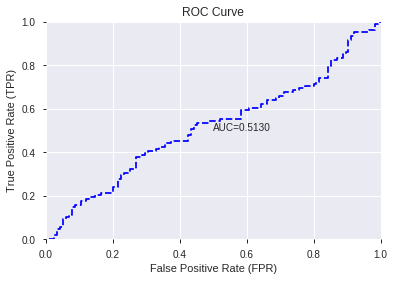

This function is available for GLM models only


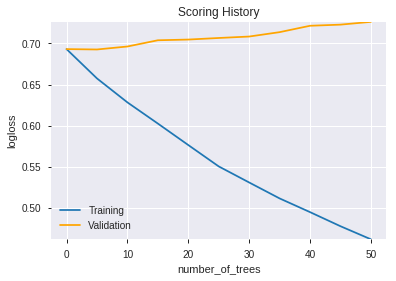

--2019-08-26 17:55:57--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190826_175511',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190826_175511',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_a50a',
   'type

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_175602_model_7  0.552979  0.822050              0.475040  0.544652  0.296646
1  DeepLearning_grid_1_AutoML_20190826_175602_model_2  0.539855  0.955189              0.482609  0.562530  0.316440
2  DeepLearning_grid_1_AutoML_20190826_175602_model_9  0.519968  0.692835              0.478261  0.499844  0.249844
3  DeepLearning_grid_1_AutoML_20190826_175602_model_5  0.512480  0.695057              0.491304  0.500918  0.250919
4  DeepLearning_grid_1_AutoML_20190826_175602_model_8  0.505958  0.692733              0.500000  0.499792  0.249792
5  DeepLearning_grid_1_AutoML_20190826_175602_model_3  0.496055  0.992554              0.491304  0.579587  0.335921
6  DeepLearning_grid_1_AutoML_20190826_175602_model_1  0.493478  1.356133              0.495652  0.613349  0.376197
7  DeepLearning_grid_1_AutoML_20190826_175602_model_6  0.486957  0.711702              0.500000  0.508859  0.258938
8               DeepLearning_1_AutoML_20190826_175602  0.479791  0.956302              0.495652  0.575204  0.330859
9  DeepLearning_grid_1_AutoML_20190826_175602_model_4  0.473108  0.959154              0.487238  0.574274  0.329790

variable  relative_importance  scaled_importance  percentage
0           HT_TRENDMODE             1.000000           1.000000    0.021604
1           STOCHF_fastd             0.977714           0.977714    0.021122
2                 ATR_20             0.976951           0.976951    0.021106
3                   hour             0.974244           0.974244    0.021048
4                    day             0.963092           0.963092    0.020807
5              CORREL_20             0.961987           0.961987    0.020783
6              CORREL_14             0.960883           0.960883    0.020759
7                  ADX_8             0.945890           0.945890    0.020435
8                 ULTOSC             0.943218           0.943218    0.020377
9                  DX_14             0.942087           0.942087    0.020353
10           STOCH_slowk             0.941974           0.941974    0.020350
11                ADX_24             0.939080           0.939080    0.020288
12             aroonup_8             0.939048           0.939048    0.020287
13               BETA_24             0.938060           0.938060    0.020266
14             dayofweek             0.936225           0.936225    0.020226
15          aroondown_14             0.934997           0.934997    0.020200
16          aroondown_12             0.933324           0.933324    0.020163
17               quarter             0.932964           0.932964    0.020156
18        STOCHRSI_fastd             0.932678           0.932678    0.020150
19                ADX_14             0.931850           0.931850    0.020132
20               NATR_24             0.930537           0.930537    0.020103
21               weekday             0.926572           0.926572    0.020018
22         days_in_month             0.925662           0.925662    0.019998
23          aroondown_24             0.925608           0.925608    0.019997
24                 MFI_8             0.923307           0.923307    0.019947
25             CORREL_24             0.923101           0.923101    0.019943
26                ADX_20             0.922896           0.922896    0.019938
27               BETA_12             0.922581           0.922581    0.019931
28                   DIV             0.919971           0.919971    0.019875
29      MACDFIX_signal_8             0.919809           0.919809    0.019872
30                ROC_30             0.919423           0.919423    0.019863
31           MINUS_DI_30             0.917362           0.917362    0.019819
32                  DX_8             0.916613           0.916613    0.019802
33        STOCHRSI_fastk             0.915486           0.915486    0.019778
34            PLUS_DM_12             0.913303           0.913303    0.019731
35                   BOP             0.912919           0.912919    0.019723
36                 DX_12             0.912344           0.912344    0.019710
37                 DX_30             0.910817           0.910817    0.019677
38            MINUS_DM_8             0.910718           0.910718    0.019675
39               ROCR_20             0.910537           0.910537    0.019671
40                 DX_24             0.904396           0.904396    0.019539
41              STDDEV_8             0.901909           0.901909    0.019485
42            weekofyear             0.899444           0.899444    0.019432
43               WILLR_8             0.897305           0.897305    0.019385
44            aroonup_24             0.896096           0.896096    0.019359
45  HT_PHASOR_quadrature             0.895450           0.895450    0.019345
46           AROONOSC_20             0.895171           0.895171    0.019339
47           MINUS_DI_20             0.889399           0.889399    0.019215
48               BETA_20             0.867621           0.867621    0.018744
49           AROONOSC_24             0.855231           0.855231    0.018476

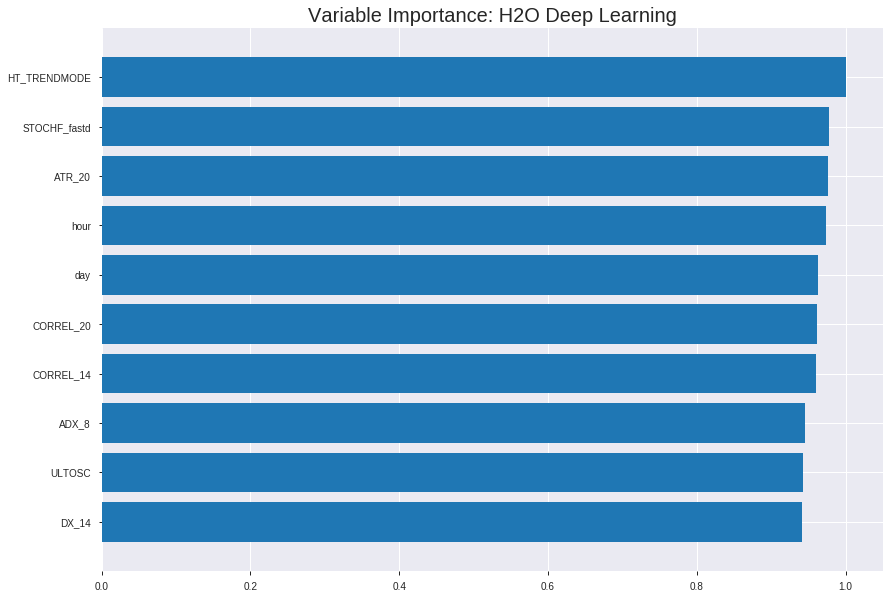

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_175602_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.26532226026475797
RMSE: 0.5150944187862628
LogLoss: 0.7386607292815142
Mean Per-Class Error: 0.39616668318958403
AUC: 0.6401663857770727
pr_auc: 0.6389458006561255
Gini: 0.2803327715541455
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11291832613562224: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      102  684   0.8702   (684.0/786.0)
1      29   741   0.0377   (29.0/770.0)
Total  131  1425  0.4582   (713.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.112918     0.675171  355
max f2                       0.0590482    0.834421  383
max f0point5                 0.30276      0.599029  222
max accuracy                 0.30276      0.604113  222
max precision                0.985335     1         0
max recall                   0.0397144    1         389
max specificity              0.985335     1         0
max absolute_mcc             0.30276      0.207989  222
max min_per_class_accuracy   0.293493     0.6       229
max mean_per_class_accuracy  0.30276      0.603833  222

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 32.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.817924           2.02078   2.02078            1                0.912623   1                           0.912623            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.764776           1.89448   1.95763            0.9375           0.786912   0.96875                     0.849768            0.0194805       0.0402597                  89.4481   95.763
    3        0.0302057                   0.704398           1.61662   1.8488             0.8              0.734183   0.914894                    0.812879            0.0155844       0.0558442                  61.6623   84.8798
    4        0.0404884                   0.672386           1.38929   1.7321             0.6875           0.685466   0.857143                    0.78052             0.0142857       0.0701299                  38.9286   73.2096
    5        0.0501285                   0.640045           1.34719   1.65808            0.666667         0.653592   0.820513                    0.756111            0.012987        0.0831169                  34.7186   65.8075
    6        0.100257                    0.562609           1.29537   1.47672            0.641026         0.596636   0.730769                    0.676374            0.0649351       0.148052                   29.5371   47.6723
    7        0.150386                    0.496555           1.16583   1.37309            0.576923         0.529757   0.679487                    0.627501            0.0584416       0.206494                   16.5834   37.3094
    8        0.200514                    0.450289           1.37309   1.37309            0.679487         0.472561   0.679487                    0.588766            0.0688312       0.275325                   37.3094   37.3094
    9        0.300129                    0.378319           1.06906   1.27218            0.529032         0.412224   0.62955                     0.530171            0.106494        0.381818                   6.90574   27.2182
    10       0.400386                    0.331496           1.12697   1.23582            0.557692         0.354763   0.611557                    0.486249            0.112987        0.494805                   12.6973   23.5822
    11       0.5                         0.290946           1.06906   1.2026             0.529032         0.310578   0.595116                    0.45125             0.106494        0.601299                   6.90574   20.2597
    12       0.600257                    0.261177           0.919714  1.15535            0.455128         0.276013   0.571734                    0.421981            0.0922078       0.693506                   -8.02864  15.5349
    13       0.699871                    0.228028           0.860461  1.11338            0.425806         0.244766   0.550964                    0.396758            0.0857143       0.779221                   -13.9539  11.3377
    14       0.800129                    0.183796           0.932667  1.09073            0.461538         0.205528   0.539759                    0.372797            0.0935065       0.872727                   -6.73327  9.07338
    15       0.899743                    0.121067           0.7692    1.05514            0.380645         0.154163   0.522143                    0.348591            0.0766234       0.949351                   -23.08    5.51354
    16       1                           0.0122158          0.505195  1                  0.25             0.0791784  0.494859                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2907635081090417
RMSE: 0.53922491421395
LogLoss: 0.8024668795150516
Mean Per-Class Error: 0.4791784759899588
AUC: 0.5106283909628311
pr_auc: 0.4723444589572168
Gini: 0.02125678192566216
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09302236954404143: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   220  0.9442   (220.0/233.0)
1      3    209  0.0142   (3.0/212.0)
Total  16   429  0.5011   (223.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0930224    0.652106  383
max f2                       0.0127683    0.821705  396
max f0point5                 0.0930224    0.542012  383
max accuracy                 0.480592     0.534831  70
max precision                0.845576     1         0
max recall                   0.0127683    1         396
max specificity              0.845576     1         0
max absolute_mcc             0.0930224    0.111712  383
max min_per_class_accuracy   0.318268     0.514151  200
max mean_per_class_accuracy  0.0930224    0.520822  383

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 33.54 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.758334           0.419811  0.419811           0.2              0.797638   0.2                         0.797638            0.00471698      0.00471698                 -58.0189  -58.0189
    2        0.0202247                   0.702575           1.04953   0.699686           0.5              0.731326   0.333333                    0.768166            0.00943396      0.0141509                  4.95283   -30.0314
    3        0.0314607                   0.66726            0.419811  0.59973            0.2              0.682332   0.285714                    0.737511            0.00471698      0.0188679                  -58.0189  -40.027
    4        0.0404494                   0.634855           1.04953   0.699686           0.5              0.660601   0.333333                    0.72042             0.00943396      0.0283019                  4.95283   -30.0314
    5        0.0516854                   0.622594           1.25943   0.82137            0.6              0.628162   0.391304                    0.700364            0.0141509       0.0424528                  25.9434   -17.863
    6        0.101124                    0.551864           0.954117  0.886268           0.454545         0.578649   0.422222                    0.640859            0.0471698       0.0896226                  -4.58834  -11.3732
    7        0.150562                    0.490935           1.33576   1.03386            0.636364         0.522261   0.492537                    0.601916            0.0660377       0.15566                    33.5763   3.38637
    8        0.2                         0.453902           1.14494   1.06132            0.545455         0.473262   0.505618                    0.570114            0.0566038       0.212264                   14.494    6.13208
    9        0.301124                    0.403587           0.886268  1.00253            0.422222         0.426981   0.477612                    0.522047            0.0896226       0.301887                   -11.3732  0.25345
    10       0.4                         0.361805           1.00182   1.00236            0.477273         0.381225   0.477528                    0.487237            0.0990566       0.400943                   0.182247  0.235849
    11       0.501124                    0.315237           1.1195    1.026              0.533333         0.334832   0.488789                    0.456483            0.113208        0.514151                   11.9497   2.59963
    12       0.6                         0.274987           0.954117  1.01415            0.454545         0.294957   0.483146                    0.429864            0.0943396       0.608491                   -4.58834  1.41509
    13       0.698876                    0.247116           1.00182   1.01241            0.477273         0.259156   0.482315                    0.405713            0.0990566       0.707547                   0.182247  1.24067
    14       0.8                         0.209707           1.02621   1.01415            0.488889         0.230012   0.483146                    0.383503            0.103774        0.811321                   2.62055   1.41509
    15       0.898876                    0.153826           0.954117  1.00755            0.454545         0.187669   0.48                        0.361962            0.0943396       0.90566                    -4.58834  0.754717
    16       1                           0.0044619          0.932914  1                  0.444444         0.0997379  0.476404             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:01:38  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:01:43  6.307 sec         208 obs/sec       0.636889  1             991        0.588848         1.08721             -0.387114      0.518292        0.51906            1.38929          0.503213                         0.587855           1.02718               -0.385378        0.529496          0.516724             1.67925            0.505618
    2019-08-26 18:01:58  21.555 sec        431 obs/sec       5.15103   8             8015       0.515094         0.738661            -0.0614013     0.640166        0.638946           2.02078          0.458226                         0.539225           0.802467              -0.16565         0.510628          0.472344             0.419811           0.501124
    2019-08-26 18:02:14  37.281 sec        485 obs/sec       10.2629   16            15969      0.621927         1.28451             -0.547337      0.757153        0.760481           2.02078          0.341902                         0.647044           1.57392               -0.678399        0.498006          0.480014             0.839623           0.507865
    2019-08-26 18:02:29  52.606 sec        511 obs/sec       15.3747   24            23923      0.405949         0.491146            0.340751       0.840434        0.832293           2.02078          0.265424                         0.57468            1.04254               -0.323975        0.527846          0.497883             0.419811           0.51236
    2019-08-26 18:02:44  1 min  7.822 sec  527 obs/sec       20.5019   32            31901      0.44816          0.598752            0.196525       0.877709        0.835929           2.02078          0.202442                         0.613545           1.30488               -0.509109        0.513098          0.487532             0.839623           0.516854
    2019-08-26 18:02:59  1 min 22.958 sec  538 obs/sec       25.6362   40            39890      0.350851         0.377374            0.507562       0.923421        0.880766           2.02078          0.151671                         0.599914           1.30913               -0.442801        0.532331          0.494854             0.839623           0.510112
    2019-08-26 18:03:01  1 min 24.386 sec  537 obs/sec       25.6362   40            39890      0.515094         0.738661            -0.0614013     0.640166        0.638946           2.02078          0.458226                         0.539225           0.802467              -0.16565         0.510628          0.472344             0.419811           0.501124

Variable Importances: 


variable              relative_importance    scaled_importance    percentage
--------------------  ---------------------  -------------------  --------------------
HT_TRENDMODE          1.0                    1.0                  0.021603939131475913
STOCHF_fastd          0.9777137041091919     0.9777137041091919   0.021122467351584833
ATR_20                0.9769508838653564     0.9769508838653564   0.021105987429468752
hour                  0.9742437601089478     0.9742437601089478   0.021047502892613926
day                   0.9630922675132751     0.9630922675132751   0.020806586725351912
---                   ---                    ---                  ---
HT_PHASOR_quadrature  0.8954504728317261     0.8954504728317261   0.019345257510307936
AROONOSC_20           0.8951705098152161     0.8951705098152161   0.019339209206340188
MINUS_DI_20           0.8893986344337463     0.8893986344337463   0.019214513961924452
BETA_20               0.8676214814186096     0.8676214814186096   0.0187440416737286
AROONOSC_24           0.8552308082580566     0.8552308082580566   0.018476354324970003


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5695067264573991)

('F1', 0.6561514195583595)

('auc', 0.5529790660225443)

('logloss', 0.8220498153617055)

('mean_per_class_error', 0.42500000000000004)

('rmse', 0.5446518760802658)

('mse', 0.2966456661177532)

deeplearning prediction progress: |███████████████████████████████████████| 100%


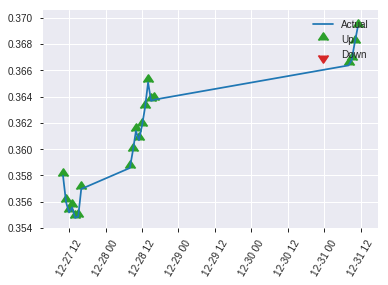


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2966456661177532
RMSE: 0.5446518760802658
LogLoss: 0.8220498153617055
Mean Per-Class Error: 0.42500000000000004
AUC: 0.5529790660225443
pr_auc: 0.5134710507045065
Gini: 0.10595813204508864
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1033514477336731: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   105  0.913    (105.0/115.0)
1      4    104  0.037    (4.0/108.0)
Total  14   209  0.4888   (109.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.103351     0.656151  208
max f2                       0.0400814    0.824427  222
max f0point5                 0.196042     0.572034  149
max accuracy                 0.196042     0.569507  149
max precision                0.708468     0.666667  5
max recall                   0.0400814    1         222
max specificity              0.808055     0.991304  0
max absolute_mcc             0.196042     0.159752  149
max min_per_class_accuracy   0.256338     0.546296  109
max mean_per_class_accuracy  0.196042     0.575     149

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 31.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.747383           0.688272  0.688272           0.333333         0.788531   0.333333                    0.788531            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.713266           2.06481   1.23889            1                0.717442   0.6                         0.760095            0.0185185       0.0277778                  106.481   23.8889
    3        0.0313901                   0.688099           1.03241   1.17989            0.5              0.702247   0.571429                    0.743567            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.645069           0         0.917695           0                0.668245   0.444444                    0.726829            0               0.037037                   -100      -8.23045
    5        0.0538117                   0.636713           2.06481   1.20448            1                0.639657   0.583333                    0.705036            0.0277778       0.0648148                  106.481   20.4475
    6        0.103139                    0.565761           1.31397   1.25684            0.636364         0.592818   0.608696                    0.651366            0.0648148       0.12963                    31.3973   25.6844
    7        0.152466                    0.502585           0.563131  1.03241            0.272727         0.52853    0.5                         0.611625            0.0277778       0.157407                   -43.6869  3.24074
    8        0.201794                    0.47661            0.938552  1.00947            0.454545         0.492208   0.488889                    0.582434            0.0462963       0.203704                   -6.14478  0.946502
    9        0.300448                    0.398202           0.844697  0.955362           0.409091         0.430903   0.462687                    0.532678            0.0833333       0.287037                   -15.5303  -4.46379
    10       0.399103                    0.327931           1.50168   1.09041            0.727273         0.365399   0.52809                     0.491328            0.148148        0.435185                   50.1684   9.04078
    11       0.502242                    0.254176           1.07729   1.08771            0.521739         0.291112   0.526786                    0.450212            0.111111        0.546296                   7.72947   8.77149
    12       0.600897                    0.216634           1.12626   1.09404            0.545455         0.234747   0.529851                    0.414837            0.111111        0.657407                   12.6263   9.40437
    13       0.699552                    0.191194           1.03241   1.08535            0.5              0.202371   0.525641                    0.384874            0.101852        0.759259                   3.24074   8.53514
    14       0.798206                    0.163262           0.750842  1.04401            0.363636         0.179226   0.505618                    0.359457            0.0740741       0.833333                   -24.9158  4.40075
    15       0.896861                    0.122086           0.844697  1.02208            0.409091         0.145745   0.495                       0.335949            0.0833333       0.916667                   -15.5303  2.20833
    16       1                           0.0400814          0.807971  1                  0.391304         0.0909558  0.484305               

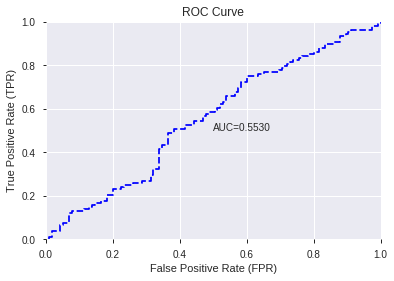

This function is available for GLM models only


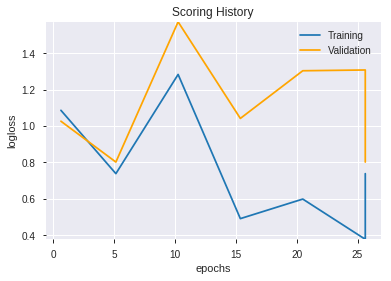

--2019-08-26 18:06:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_175602_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_175602_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_TRENDMODE',
 'STOCHF_fastd',
 'ATR_20',
 'hour',
 'day',
 'CORREL_20',
 'CORREL_14',
 'ADX_8',
 'ULTOSC',
 'DX_14',
 'STOCH_slowk',
 'ADX_24',
 'aroonup_8',
 'BETA_24',
 'dayofweek',
 'aroondown_14',
 'aroondown_12',
 'quarter',
 'STOCHRSI_fastd',
 'ADX_14',
 'NATR_24',
 'weekday',
 'days_in_month',
 'aroondown_24',
 'MFI_8',
 'CORREL_24',
 'ADX_20',
 'BETA_12',
 'DIV',
 'MACDFIX_signal_8',
 'ROC_30',
 'MINUS_DI_30',
 'DX_8',
 'STOCHRSI_fastk',
 'PLUS_DM_12',
 'BOP',
 'DX_12',
 'DX_30',
 'MINUS_DM_8',
 'ROCR_20',
 'DX_24',
 'STDDEV_8',
 'weekofyear',
 'WILLR_8',
 'aroonup_24',
 'HT_PHASOR_quadrature',
 'AROONOSC_20',
 'MINUS_DI_20',
 'BETA_20',
 'AROONOSC_24']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_180623_model_1  0.494847  0.692953              0.479106  0.499903  0.249903

variable  relative_importance  scaled_importance  percentage
0   HT_PHASOR_quadrature             0.007732           1.000000    0.052361
1                   DX_8             0.007432           0.961091    0.050324
2                    DIV             0.006958           0.899836    0.047117
3                  DX_12             0.006537           0.845437    0.044268
4                  DX_14             0.006399           0.827575    0.043333
5           STOCHF_fastd             0.006214           0.803681    0.042082
6            STOCH_slowk             0.006201           0.801945    0.041991
7              aroonup_8             0.006109           0.790017    0.041366
8                 ADX_24             0.005953           0.769862    0.040311
9              CORREL_24             0.004722           0.610628    0.031973
10          aroondown_12             0.004594           0.594128    0.031109
11                ADX_20             0.004347           0.562134    0.029434
12                 MFI_8             0.004139           0.535287    0.028028
13              STDDEV_8             0.003591           0.464378    0.024316
14               quarter             0.003440           0.444911    0.023296
15                 ADX_8             0.003395           0.439066    0.022990
16                 DX_24             0.003385           0.437825    0.022925
17            aroonup_24             0.002999           0.387881    0.020310
18                   day             0.002885           0.373079    0.019535
19            weekofyear             0.002835           0.366654    0.019199
20                   BOP             0.002832           0.366206    0.019175
21          aroondown_14             0.002680           0.346572    0.018147
22               NATR_24             0.002579           0.333572    0.017466
23        STOCHRSI_fastk             0.002522           0.326112    0.017076
24               weekday             0.002468           0.319232    0.016715
25             dayofweek             0.002462           0.318386    0.016671
26             CORREL_20             0.002339           0.302504    0.015840
27                ADX_14             0.002189           0.283110    0.014824
28               WILLR_8             0.002144           0.277224    0.014516
29                ROC_30             0.002036           0.263266    0.013785
30            PLUS_DM_12             0.001846           0.238796    0.012504
31        STOCHRSI_fastd             0.001755           0.226967    0.011884
32               ROCR_20             0.001696           0.219321    0.011484
33      MACDFIX_signal_8             0.001635           0.211436    0.011071
34           MINUS_DI_20             0.001462           0.189121    0.009903
35          HT_TRENDMODE             0.001455           0.188195    0.009854
36                  hour             0.001336           0.172829    0.009050
37           MINUS_DI_30             0.001310           0.169472    0.008874
38           AROONOSC_20             0.001236           0.159859    0.008370
39               BETA_24             0.001200           0.155198    0.008126
40             CORREL_14             0.001198           0.154948    0.008113
41           AROONOSC_24             0.001147           0.148350    0.007768
42                ULTOSC             0.001118           0.144560    0.007569
43                 DX_30             0.001088           0.140687    0.007367
44          aroondown_24             0.000987           0.127638    0.006683
45               BETA_12             0.000930           0.120332    0.006301
46               BETA_20             0.000826           0.106852    0.005595
47                ATR_20             0.000717           0.092690    0.004853
48            MINUS_DM_8             0.000562           0.072666    0.003805
49         days_in_month             0.000050           0.006497    0.000340

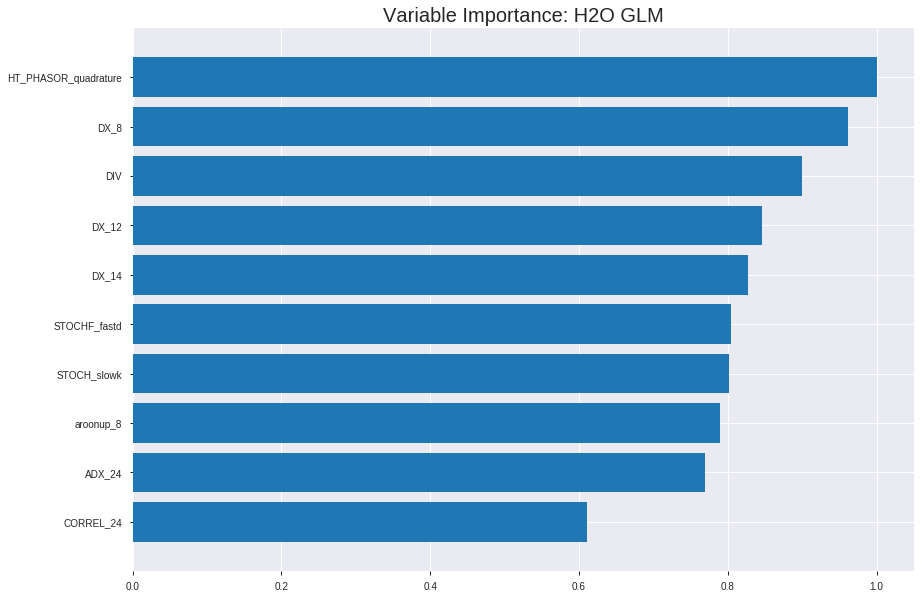

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_180623_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24929745185811525
RMSE: 0.4992969575894843
LogLoss: 0.6917415633400902
Null degrees of freedom: 1555
Residual degrees of freedom: 1505
Null deviance: 2156.909498581488
Residual deviance: 2152.6997451143607
AIC: 2254.6997451143607
AUC: 0.5516208981857836
pr_auc: 0.5415477791869824
Gini: 0.10324179637156727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47481768925370116: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      11   775   0.986    (775.0/786.0)
1      2    768   0.0026   (2.0/770.0)
Total  13   1543  0.4994   (777.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474818     0.664073  389
max f2                       0.472336     0.831533  393
max f0point5                 0.489911     0.554303  258
max accuracy                 0.499643     0.544987  128
max precision                0.517768     1         0
max recall                   0.472336     1         393
max specificity              0.517768     1         0
max absolute_mcc             0.502396     0.10429   93
max min_per_class_accuracy   0.495291     0.535065  185
max mean_per_class_accuracy  0.49939      0.542956  130

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.510994           1.26299   1.26299            0.625            0.513291  0.625                       0.513291            0.012987        0.012987                   26.2987   26.2987
    2        0.0205656                   0.509364           1.01039   1.13669            0.5              0.509976  0.5625                      0.511633            0.0103896       0.0233766                  1.03896   13.6688
    3        0.0302057                   0.508612           1.07775   1.11788            0.533333         0.508896  0.553191                    0.51076             0.0103896       0.0337662                  7.77489   11.7878
    4        0.0404884                   0.507902           1.26299   1.15473            0.625            0.508188  0.571429                    0.510107            0.012987        0.0467532                  26.2987   15.4731
    5        0.0501285                   0.507375           1.21247   1.16583            0.6              0.507618  0.576923                    0.509628            0.0116883       0.0584416                  21.2468   16.5834
    6        0.100257                    0.50536            1.16583   1.16583            0.576923         0.506513  0.576923                    0.50807             0.0584416       0.116883                   16.5834   16.5834
    7        0.150386                    0.50362            1.13993   1.1572             0.564103         0.504597  0.57265                     0.506913            0.0571429       0.174026                   13.9927   15.7198
    8        0.200514                    0.502204           1.34719   1.2047             0.666667         0.502859  0.596154                    0.505899            0.0675325       0.241558                   34.7186   20.4695
    9        0.300129                    0.499409           1.01691   1.14237            0.503226         0.500834  0.56531                     0.504218            0.101299        0.342857                   1.69083   14.2368
    10       0.400386                    0.497164           0.893806  1.08013            0.442308         0.498314  0.53451                     0.50274             0.0896104       0.432468                   -10.6194  8.01276
    11       0.5                         0.495227           1.02995   1.07013            0.509677         0.496229  0.529563                    0.501443            0.102597        0.535065                   2.99455   7.01299
    12       0.600257                    0.493143           1.02334   1.06232            0.50641          0.494276  0.525696                    0.500246            0.102597        0.637662                   2.33433   6.23154
    13       0.699871                    0.490534           0.977796  1.05029            0.483871         0.491862  0.519743                    0.499052            0.0974026       0.735065                   -2.22036  5.02856
    14       0.800129                    0.487999           0.880852  1.02906            0.435897         0.489361  0.509237                    0.497838            0.0883117       0.823377                   -11.9148  2.90554
    15       0.899743                    0.483923           0.808312  1.00462            0.4              0.486123  0.497143                    0.496541            0.0805195       0.903896                   -19.1688  0.461596
    16       1                           0.461948           0.958575  1                  0.474359         0.479759  0.494859                    0.494859        



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24966287083079933
RMSE: 0.4996627570980244
LogLoss: 0.6924725188333427
Null degrees of freedom: 444
Residual degrees of freedom: 394
Null deviance: 616.5161536496719
Residual deviance: 616.300541761675
AIC: 718.300541761675
AUC: 0.5104461899748968
pr_auc: 0.481717104256582
Gini: 0.020892379949793538
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4781021637806703: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    228  0.9785   (228.0/233.0)
1      0    212  0        (0.0/212.0)
Total  5    440  0.5124   (228.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478102     0.650307  394
max f2                       0.478102     0.822981  394
max f0point5                 0.478102     0.537525  394
max accuracy                 0.509637     0.532584  7
max precision                0.511681     0.8       4
max recall                   0.478102     1         394
max specificity              0.515588     0.995708  0
max absolute_mcc             0.478102     0.101683  394
max min_per_class_accuracy   0.49613      0.518868  198
max mean_per_class_accuracy  0.494966     0.522704  226

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.511416           1.67925   1.67925            0.8              0.513227  0.8                         0.513227            0.0188679       0.0188679                  67.9245   67.9245
    2        0.0202247                   0.508995           1.04953   1.39937            0.5              0.510244  0.666667                    0.511901            0.00943396      0.0283019                  4.95283   39.9371
    3        0.0314607                   0.508596           0.839623  1.19946            0.4              0.508835  0.571429                    0.510806            0.00943396      0.0377358                  -16.0377  19.9461
    4        0.0404494                   0.507588           1.04953   1.16614            0.5              0.508012  0.555556                    0.510185            0.00943396      0.0471698                  4.95283   16.6143
    5        0.0516854                   0.50682            0.839623  1.09516            0.4              0.507137  0.521739                    0.509523            0.00943396      0.0566038                  -16.0377  9.516
    6        0.101124                    0.504721           0.763293  0.932914           0.363636         0.505679  0.444444                    0.507644            0.0377358       0.0943396                  -23.6707  -6.7086
    7        0.150562                    0.50363            0.57247   0.814559           0.272727         0.504056  0.38806                     0.506466            0.0283019       0.122642                   -42.753   -18.5441
    8        0.2                         0.502361           1.14494   0.896226           0.545455         0.503052  0.426966                    0.505622            0.0566038       0.179245                   14.494    -10.3774
    9        0.301124                    0.499894           1.25943   1.0182             0.6              0.501002  0.485075                    0.50407             0.127358        0.306604                   25.9434   1.81991
    10       0.4                         0.497815           1.00182   1.01415            0.477273         0.49885   0.483146                    0.50278             0.0990566       0.40566                    0.182247  1.41509
    11       0.501124                    0.496094           1.1195    1.03541            0.533333         0.497014  0.493274                    0.501616            0.113208        0.518868                   11.9497   3.54091
    12       0.6                         0.494443           1.04953   1.03774            0.5              0.49532   0.494382                    0.500579            0.103774        0.622642                   4.95283   3.77358
    13       0.698876                    0.492506           0.906411  1.01916            0.431818         0.493586  0.485531                    0.49959             0.0896226       0.712264                   -9.35892  1.91561
    14       0.8                         0.49065            0.886268  1.00236            0.422222         0.491492  0.477528                    0.498566            0.0896226       0.801887                   -11.3732  0.235849
    15       0.898876                    0.485789           1.09723   1.01279            0.522727         0.488774  0.4825                      0.497489            0.108491        0.910377                   9.72341   1.27948
    16       1                           0.472672           0.886268  1                  0.422222         0.482063  0.476404                    0.495929        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 18:06:24  0.000 sec   2            1.9       51            1.38348           1.38495
    2019-08-26 18:06:24  0.012 sec   4            1.2       51            1.38239           1.38496
    2019-08-26 18:06:24  0.026 sec   6            0.73      51            1.38108           1.38513
    2019-08-26 18:06:24  0.036 sec   8            0.46      51            1.37958           1.3855
    2019-08-26 18:06:24  0.045 sec   10           0.28      51            1.37793           1.38613
    2019-08-26 18:06:24  0.056 sec   12           0.18      51            1.37615           1.38704

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5336322869955157)

('F1', 0.65625)

('auc', 0.4948470209339774)

('logloss', 0.6929526405781435)

('mean_per_class_error', 0.47471819645732694)

('rmse', 0.4999028343377944)

('mse', 0.24990284377896033)

glm prediction progress: |████████████████████████████████████████████████| 100%


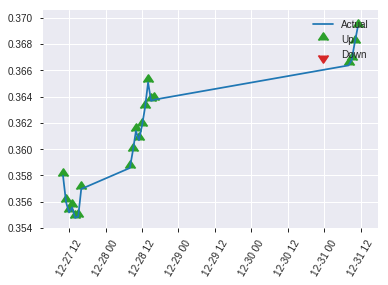


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24990284377896033
RMSE: 0.4999028343377944
LogLoss: 0.6929526405781435
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.02325884747086
Residual deviance: 309.05687769785203
AIC: 411.05687769785203
AUC: 0.4948470209339774
pr_auc: 0.48631899884460605
Gini: -0.010305958132045157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4834693006227243: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    107  0.9304   (107.0/115.0)
1      3    105  0.0278   (3.0/108.0)
Total  11   212  0.4933   (110.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483469     0.65625   211
max f2                       0.474786     0.824427  222
max f0point5                 0.483469     0.549163  211
max accuracy                 0.508279     0.533632  5
max precision                0.508279     0.833333  5
max recall                   0.474786     1         222
max specificity              0.512918     0.991304  0
max absolute_mcc             0.508279     0.116132  5
max min_per_class_accuracy   0.494413     0.490741  105
max mean_per_class_accuracy  0.500816     0.525282  51

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 49.50 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.510833           1.37654   1.37654            0.666667         0.512221  0.666667                    0.512221            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.50859            2.06481   1.65185            1                0.509045  0.8                         0.510951            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.508048           1.03241   1.47487            0.5              0.508219  0.714286                    0.51017             0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.50772            0         1.14712            0                0.507875  0.555556                    0.50966             0               0.0462963                  -100      14.7119
    5        0.0538117                   0.507384           0.688272  1.03241            0.333333         0.507538  0.5                         0.50913             0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.505411           0.563131  0.807971           0.272727         0.506593  0.391304                    0.507917            0.0277778       0.0833333                  -43.6869  -19.2029
    7        0.152466                    0.503735           1.50168   1.03241            0.727273         0.5047    0.5                         0.506876            0.0740741       0.157407                   50.1684   3.24074
    8        0.201794                    0.502223           1.31397   1.10123            0.636364         0.502933  0.533333                    0.505912            0.0648148       0.222222                   31.3973   10.1235
    9        0.300448                    0.499274           0.750842  0.98618            0.363636         0.500577  0.477612                    0.504161            0.0740741       0.296296                   -24.9158  -1.38198
    10       0.399103                    0.496743           0.844697  0.951207           0.409091         0.498112  0.460674                    0.502666            0.0833333       0.37963                    -15.5303  -4.87932
    11       0.502242                    0.493986           1.07729   0.9771             0.521739         0.494931  0.473214                    0.501077            0.111111        0.490741                   7.72947   -2.29001
    12       0.600897                    0.492404           1.03241   0.98618            0.5              0.493021  0.477612                    0.499754            0.101852        0.592593                   3.24074   -1.38198
    13       0.699552                    0.491144           0.938552  0.979463           0.454545         0.491846  0.474359                    0.498639            0.0925926       0.685185                   -6.14478  -2.05366
    14       0.798206                    0.488884           0.938552  0.974407           0.454545         0.490055  0.47191                     0.497578            0.0925926       0.777778                   -6.14478  -2.5593
    15       0.896861                    0.48611            1.40783   1.02208            0.681818         0.487899  0.495                       0.496513            0.138889        0.916667                   40.7828   2.20833
    16       1                           0.474786           0.807971  1                  0.391304         0.482228  0.484305                    0.49504    

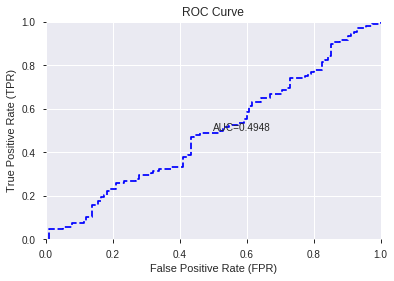

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


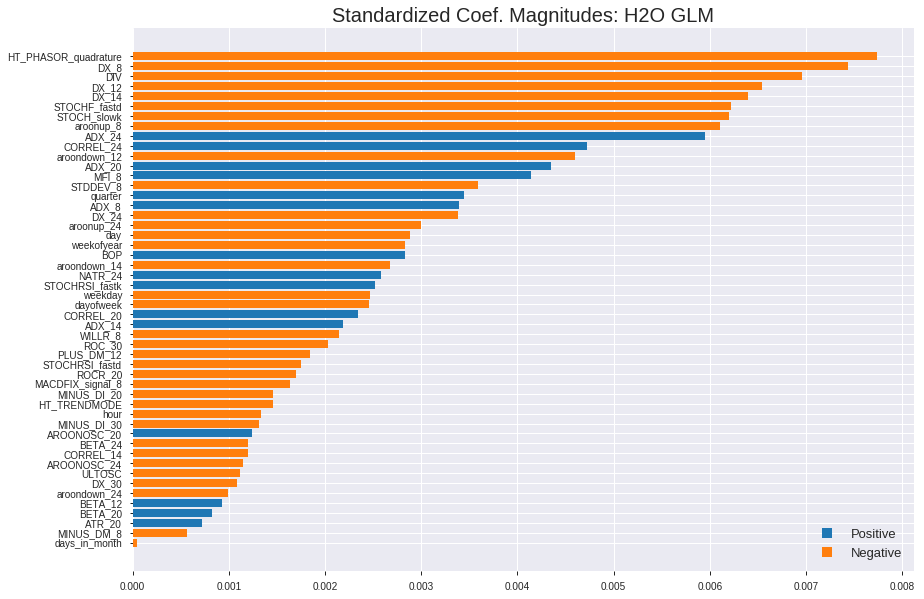

'log_likelihood'
--2019-08-26 18:06:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_180623_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_180623_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['HT_PHASOR_quadrature',
 'DX_8',
 'DIV',
 'DX_12',
 'DX_14',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'ADX_24',
 'CORREL_24',
 'aroondown_12',
 'ADX_20',
 'MFI_8',
 'STDDEV_8',
 'quarter',
 'ADX_8',
 'DX_24',
 'aroonup_24',
 'day',
 'weekofyear',
 'BOP',
 'aroondown_14',
 'NATR_24',
 'STOCHRSI_fastk',
 'weekday',
 'dayofweek',
 'CORREL_20',
 'ADX_14',
 'WILLR_8',
 'ROC_30',
 'PLUS_DM_12',
 'STOCHRSI_fastd',
 'ROCR_20',
 'MACDFIX_signal_8',
 'MINUS_DI_20',
 'HT_TRENDMODE',
 'hour',
 'MINUS_DI_30',
 'AROONOSC_20',
 'BETA_24',
 'CORREL_14',
 'AROONOSC_24',
 'ULTOSC',
 'DX_30',
 'aroondown_24',
 'BETA_12',
 'BETA_20',
 'ATR_20',
 'MINUS_DM_8',
 'days_in_month']

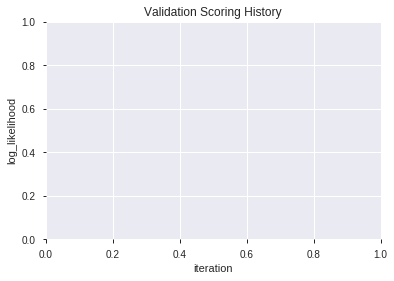

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_180634_model_6  0.508857  0.701176              0.458776  0.503838  0.253853
1  XGBoost_grid_1_AutoML_20190826_180634_model_5  0.492512  0.731337              0.500000  0.517040  0.267330
2  XGBoost_grid_1_AutoML_20190826_180634_model_7  0.490499  0.723713              0.500000  0.514083  0.264281
3  XGBoost_grid_1_AutoML_20190826_180634_model_2  0.484622  0.702787              0.500000  0.504682  0.254704
4  XGBoost_grid_1_AutoML_20190826_180634_model_1  0.481965  0.706775              0.491304  0.506640  0.256684
5               XGBoost_2_AutoML_20190826_180634  0.470531  0.710137              0.449235  0.508308  0.258377
6  XGBoost_grid_1_AutoML_20190826_180634_model_4  0.446135  0.711476              0.500000  0.508897  0.258976
7               XGBoost_3_AutoML_20190826_180634  0.445974  0.711517              0.482609  0.509018  0.259099
8  XGBoost_grid_1_AutoML_20190826_180634_model_3  0.443881  0.716999              0.500000  0.511501  0.261633
9               XGBoost_1_AutoML_20190826_180634  0.440821  0.726879              0.500000  0.516000  0.266256

variable  relative_importance  scaled_importance  percentage
0                    DIV           432.272705           1.000000    0.072802
1   HT_PHASOR_quadrature           272.630066           0.630690    0.045916
2                 ADX_14           251.853516           0.582626    0.042417
3                    BOP           242.801025           0.561685    0.040892
4               STDDEV_8           208.075058           0.481351    0.035044
5                  ADX_8           197.362686           0.456570    0.033239
6             PLUS_DM_12           189.958466           0.439441    0.031992
7            STOCH_slowk           186.739960           0.431996    0.031450
8                BETA_12           175.365295           0.405682    0.029535
9                  MFI_8           175.258987           0.405436    0.029517
10                ULTOSC           162.806458           0.376629    0.027420
11               WILLR_8           161.603958           0.373847    0.027217
12                ADX_24           149.910782           0.346797    0.025248
13                  DX_8           140.930328           0.326022    0.023735
14               BETA_24           139.934677           0.323719    0.023568
15                ADX_20           139.874695           0.323580    0.023557
16               BETA_20           136.042999           0.314716    0.022912
17                 DX_12           132.389725           0.306264    0.022297
18             CORREL_24           128.661224           0.297639    0.021669
19                   day           126.531479           0.292712    0.021310
20        STOCHRSI_fastd           126.340088           0.292269    0.021278
21                ROC_30           122.570526           0.283549    0.020643
22               NATR_24           122.114906           0.282495    0.020566
23                 DX_14           115.657318           0.267556    0.019479
24           MINUS_DI_30           110.564323           0.255774    0.018621
25                ATR_20           108.574982           0.251172    0.018286
26          aroondown_24           100.531097           0.232564    0.016931
27             CORREL_14            98.372551           0.227571    0.016568
28                  hour            96.964722           0.224314    0.016331
29               ROCR_20            95.509987           0.220948    0.016086
30            MINUS_DM_8            90.976067           0.210460    0.015322
31                 DX_30            90.730461           0.209892    0.015281
32           MINUS_DI_20            88.321381           0.204319    0.014875
33      MACDFIX_signal_8            87.455994           0.202317    0.014729
34            aroonup_24            86.654602           0.200463    0.014594
35           AROONOSC_20            75.093018           0.173717    0.012647
36          aroondown_12            73.817795           0.170767    0.012432
37                 DX_24            69.797264           0.161466    0.011755
38           AROONOSC_24            68.829926           0.159228    0.011592
39            weekofyear            66.209007           0.153165    0.011151
40        STOCHRSI_fastk            65.094887           0.150588    0.010963
41             CORREL_20            57.196148           0.132315    0.009633
42             dayofweek            40.193413           0.092982    0.006769
43          aroondown_14            34.834713           0.080585    0.005867
44             aroonup_8            31.525162           0.072929    0.005309
45          STOCHF_fastd            19.111721           0.044212    0.003219
46               weekday            18.164320           0.042021    0.003059
47          HT_TRENDMODE            11.967956           0.027686    0.002016
48         days_in_month             8.958256           0.020724    0.001509
49               quarter             4.472653           0.010347    0.000753

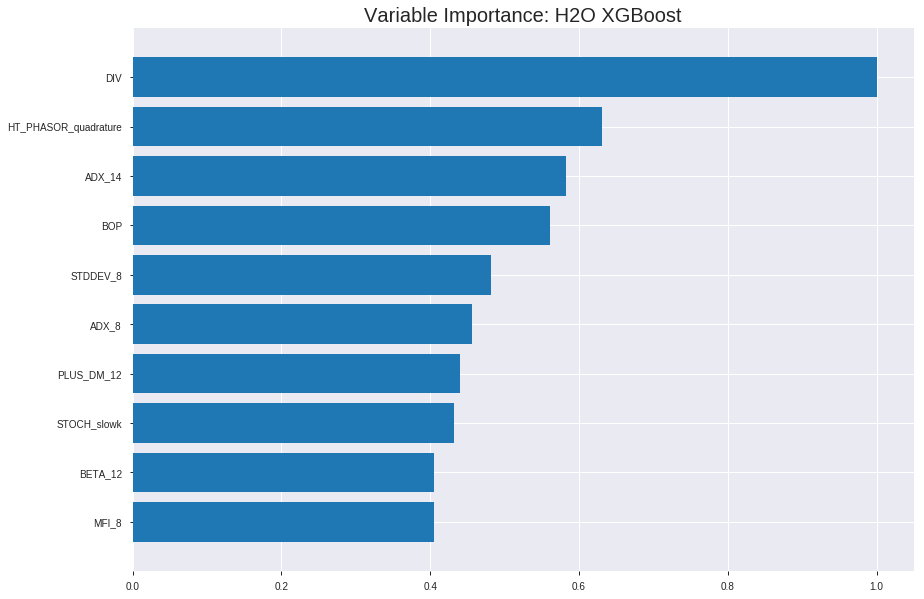

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_180634_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18705640412883587
RMSE: 0.4325001781835886
LogLoss: 0.5643370174297039
Mean Per-Class Error: 0.13680479825517988
AUC: 0.938339777271075
pr_auc: 0.9351375951599172
Gini: 0.87667955454215
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47624504566192627: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      619  167  0.2125   (167.0/786.0)
1      54   716  0.0701   (54.0/770.0)
Total  673  883  0.142    (221.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.476245     0.866304  221
max f2                       0.468127     0.909431  229
max f0point5                 0.510665     0.881275  182
max accuracy                 0.510073     0.863111  183
max precision                0.784549     1         0
max recall                   0.331184     1         363
max specificity              0.784549     1         0
max absolute_mcc             0.510073     0.729151  183
max min_per_class_accuracy   0.49631      0.860051  198
max mean_per_class_accuracy  0.49344      0.863195  201

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.46 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.706532           2.02078    2.02078            1                0.73147   1                           0.73147             0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.686821           2.02078    2.02078            1                0.695399  1                           0.713434            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.674677           2.02078    2.02078            1                0.680588  1                           0.702951            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.666003           2.02078    2.02078            1                0.669884  1                           0.694553            0.0207792       0.0818182                  102.078   102.078
    5        0.0501285                   0.656749           2.02078    2.02078            1                0.661237  1                           0.688146            0.0194805       0.101299                   102.078   102.078
    6        0.100257                    0.623522           1.94306    1.98192            0.961538         0.637398  0.980769                    0.662772            0.0974026       0.198701                   94.3057   98.1918
    7        0.150386                    0.602406           1.99487    1.98624            0.987179         0.612745  0.982906                    0.646097            0.1             0.298701                   99.4872   98.6236
    8        0.200514                    0.584676           1.94306    1.97544            0.961538         0.593418  0.977564                    0.632927            0.0974026       0.396104                   94.3057   97.5441
    9        0.300129                    0.553317           1.87737    1.94289            0.929032         0.569576  0.961456                    0.6119              0.187013        0.583117                   87.7369   94.2891
    10       0.400386                    0.523082           1.61921    1.86184            0.801282         0.536794  0.921348                    0.593094            0.162338        0.745455                   61.9214   86.1842
    11       0.5                         0.494382           1.2255     1.73506            0.606452         0.509038  0.858612                    0.576347            0.122078        0.867532                   22.5505   73.5065
    12       0.600257                    0.467078           0.790176   1.57725            0.391026         0.480789  0.780514                    0.560387            0.0792208       0.946753                   -20.9824  57.7246
    13       0.699871                    0.436442           0.325932   1.39914            0.16129          0.452126  0.692378                    0.544978            0.0324675       0.979221                   -67.4068  39.9144
    14       0.800129                    0.400567           0.116583   1.23844            0.0576923        0.418846  0.612851                    0.529173            0.0116883       0.990909                   -88.3417  23.8437
    15       0.899743                    0.363231           0.0782237  1.10999            0.0387097        0.381933  0.549286                    0.512872            0.00779221      0.998701                   -92.1776  10.9985
    16       1                           0.206346           0.0129537  1                  0.00641026       0.330301  0.494859                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25568942061840266
RMSE: 0.505657414282044
LogLoss: 0.7051009278164314
Mean Per-Class Error: 0.4608571544254596
AUC: 0.5017410316624827
pr_auc: 0.5083989256458366
Gini: 0.0034820633249654787
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2908334732055664: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    233  1        (233.0/233.0)
1      0    212  0        (0.0/212.0)
Total  0    445  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.290833     0.645358  399
max f2                       0.290833     0.819799  399
max f0point5                 0.290833     0.532129  399
max accuracy                 0.567648     0.550562  82
max precision                0.682515     0.818182  10
max recall                   0.290833     1         399
max specificity              0.782907     0.995708  0
max absolute_mcc             0.655047     0.123891  17
max min_per_class_accuracy   0.491195     0.5       198
max mean_per_class_accuracy  0.55022      0.539143  104

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 49.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.722568           1.25943   1.25943            0.6              0.748674  0.6                         0.748674            0.0141509       0.0141509                  25.9434   25.9434
    2        0.0202247                   0.686534           2.09906   1.6326             1                0.697921  0.777778                    0.726117            0.0188679       0.0330189                  109.906   63.26
    3        0.0314607                   0.666399           1.25943   1.49933            0.6              0.677354  0.714286                    0.708702            0.0141509       0.0471698                  25.9434   49.9326
    4        0.0404494                   0.653905           2.09906   1.6326             1                0.66204   0.777778                    0.698332            0.0188679       0.0660377                  109.906   63.26
    5        0.0516854                   0.641699           0.419811  1.36895            0.2              0.649351  0.652174                    0.687684            0.00471698      0.0707547                  -58.0189  36.895
    6        0.101124                    0.602031           1.04953   1.21279            0.5              0.618588  0.577778                    0.653904            0.0518868       0.122642                   4.95283   21.2788
    7        0.150562                    0.583325           1.04953   1.15918            0.5              0.591465  0.552239                    0.633402            0.0518868       0.174528                   4.95283   15.9181
    8        0.2                         0.567698           1.24035   1.17925            0.590909         0.575834  0.561798                    0.619171            0.0613208       0.235849                   24.0352   17.9245
    9        0.301124                    0.541193           0.932914  1.09652            0.444444         0.553497  0.522388                    0.597117            0.0943396       0.330189                   -6.7086   9.65221
    10       0.4                         0.510649           0.810999  1.02594            0.386364         0.525164  0.488764                    0.579331            0.0801887       0.410377                   -18.9001  2.59434
    11       0.501124                    0.490228           0.886268  0.997758           0.422222         0.499958  0.475336                    0.563314            0.0896226       0.5                        -11.3732  -0.224215
    12       0.6                         0.473404           0.906411  0.982704           0.431818         0.482274  0.468165                    0.549959            0.0896226       0.589623                   -9.35892  -1.72956
    13       0.698876                    0.44985            0.906411  0.97191            0.431818         0.461642  0.463023                    0.537464            0.0896226       0.679245                   -9.35892  -2.80895
    14       0.8                         0.425364           0.886268  0.961085           0.422222         0.436519  0.457865                    0.524704            0.0896226       0.768868                   -11.3732  -3.89151
    15       0.898876                    0.389399           1.09723   0.976061           0.522727         0.408867  0.465                       0.511962            0.108491        0.877358                   9.72341   -2.39387
    16       1                           0.290833           1.21279   1                  0.577778         0.358298  0.476404                    0.496423        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:06:42  5.416 sec   0                  0.5              0.693147            0.5             0                  1                0.505141                         0.5                0.693147              0.5               0                    1                  0.523596
    2019-08-26 18:06:42  5.490 sec   5                  0.491524         0.676306            0.732848        0.710945           1.89448          0.349614                         0.502586           0.698346              0.461313          0.454967             1.25943            0.523596
    2019-08-26 18:06:43  5.529 sec   10                 0.48279          0.659177            0.809664        0.789507           1.89448          0.292416                         0.502273           0.697729              0.486072          0.470988             1.25943            0.514607
    2019-08-26 18:06:43  5.566 sec   15                 0.476658         0.647256            0.83074         0.822272           1.89448          0.275064                         0.502988           0.699183              0.490364          0.479362             1.67925            0.523596
    2019-08-26 18:06:43  5.612 sec   20                 0.470211         0.634826            0.851936        0.848167           2.02078          0.239717                         0.501952           0.697052              0.502794          0.501171             1.67925            0.507865
    2019-08-26 18:06:43  5.651 sec   25                 0.464346         0.623583            0.867527        0.865607           2.02078          0.229434                         0.501636           0.696466              0.511205          0.511158             1.67925            0.523596
    2019-08-26 18:06:43  5.694 sec   30                 0.457264         0.610205            0.893944        0.89025            2.02078          0.197301                         0.501982           0.697235              0.510497          0.507572             1.25943            0.523596
    2019-08-26 18:06:43  5.749 sec   35                 0.450873         0.598228            0.909514        0.906188           2.02078          0.180591                         0.502895           0.699076              0.503148          0.508422             1.25943            0.519101
    2019-08-26 18:06:43  5.793 sec   40                 0.444404         0.586237            0.923239        0.919594           2.02078          0.154242                         0.503496           0.70032               0.502176          0.511592             1.25943            0.519101
    2019-08-26 18:06:43  5.842 sec   45                 0.437504         0.573546            0.935452        0.931947           2.02078          0.138817                         0.504325           0.702285              0.507399          0.511747             1.25943            0.523596
    2019-08-26 18:06:43  5.887 sec   50                 0.4325           0.564337            0.93834         0.935138           2.02078          0.142031                         0.505657           0.705101              0.501741          0.508399             1.25943            0.523596

Variable Importances: 


variable              relative_importance    scaled_importance     percentage
--------------------  ---------------------  --------------------  ---------------------
DIV                   432.272705078125       1.0                   0.0728024834526772
HT_PHASOR_quadrature  272.63006591796875     0.6306899850840596    0.04591579720285148
ADX_14                251.853515625          0.5826264593307651    0.04241665316451993
BOP                   242.801025390625       0.5616848404683413    0.040892051303816054
STDDEV_8              208.07505798339844     0.48135136810406026   0.035043575011319376
---                   ---                    ---                   ---
STOCHF_fastd          19.11172103881836      0.044212185535434816  0.0032187569058501875
weekday               18.16431999206543      0.042020511077104854  0.003059197562363965
HT_TRENDMODE          11.967955589294434     0.027686123710104378  0.0020156185632736476
days_in_month         8.958255767822266      0.020723621136808146  0.0015087310848920265
quarter               4.472653388977051      0.010346832766525715  0.0007532751212726066


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5291479820627802)

('F1', 0.6557377049180328)

('auc', 0.5088566827697263)

('logloss', 0.7011759716633206)

('mean_per_class_error', 0.4587761674718196)

('rmse', 0.5038381198846026)

('mse', 0.25385285104885114)

xgboost prediction progress: |████████████████████████████████████████████| 100%


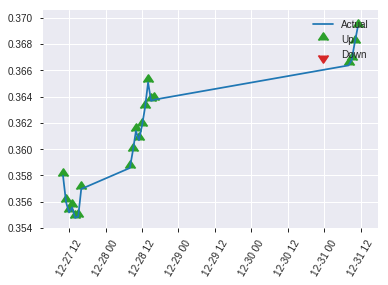


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25385285104885114
RMSE: 0.5038381198846026
LogLoss: 0.7011759716633206
Mean Per-Class Error: 0.4587761674718196
AUC: 0.5088566827697263
pr_auc: 0.47457088759756794
Gini: 0.017713365539452575
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40438103675842285: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   97   0.8435   (97.0/115.0)
1      8    100  0.0741   (8.0/108.0)
Total  26   197  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404381     0.655738  196
max f2                       0.330057     0.825688  221
max f0point5                 0.404381     0.558036  196
max accuracy                 0.404381     0.529148  196
max precision                0.525696     0.514286  69
max recall                   0.330057     1         221
max specificity              0.706782     0.991304  0
max absolute_mcc             0.404381     0.128387  196
max min_per_class_accuracy   0.489885     0.495652  111
max mean_per_class_accuracy  0.404381     0.541224  196

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.663691           0.688272  0.688272           0.333333         0.691363  0.333333                    0.691363            0.00925926      0.00925926                 -31.1728  -31.1728
    2        0.0224215                   0.638096           1.03241   0.825926           0.5              0.643447  0.4                         0.672197            0.00925926      0.0185185                  3.24074   -17.4074
    3        0.0313901                   0.631861           0         0.589947           0                0.635616  0.285714                    0.661745            0               0.0185185                  -100      -41.0053
    4        0.0403587                   0.622413           1.03241   0.688272           0.5              0.627827  0.333333                    0.654207            0.00925926      0.0277778                  3.24074   -31.1728
    5        0.0538117                   0.602153           0.688272  0.688272           0.333333         0.612475  0.333333                    0.643774            0.00925926      0.037037                   -31.1728  -31.1728
    6        0.103139                    0.572899           1.12626   0.897746           0.545455         0.584534  0.434783                    0.615442            0.0555556       0.0925926                  12.6263   -10.2254
    7        0.152466                    0.556787           1.12626   0.971678           0.545455         0.564293  0.470588                    0.598894            0.0555556       0.148148                   12.6263   -2.83224
    8        0.201794                    0.540923           0.938552  0.96358            0.454545         0.547226  0.466667                    0.586264            0.0462963       0.194444                   -6.14478  -3.64198
    9        0.300448                    0.527704           1.22012   1.04782            0.590909         0.534399  0.507463                    0.569234            0.12037         0.314815                   22.0118   4.78165
    10       0.399103                    0.50585            1.03241   1.04401            0.5              0.515482  0.505618                    0.555947            0.101852        0.416667                   3.24074   4.40075
    11       0.502242                    0.489885           0.807971  0.995536           0.391304         0.497449  0.482143                    0.543934            0.0833333       0.5                        -19.2029  -0.446429
    12       0.600897                    0.474882           1.12626   1.017              0.545455         0.483627  0.492537                    0.534033            0.111111        0.611111                   12.6263   1.69983
    13       0.699552                    0.456296           0.938552  1.00594            0.454545         0.464724  0.487179                    0.524258            0.0925926       0.703704                   -6.14478  0.593542
    14       0.798206                    0.432345           1.12626   1.02081            0.545455         0.444619  0.494382                    0.514415            0.111111        0.814815                   12.6263   2.08073
    15       0.896861                    0.398674           1.12626   1.03241            0.545455         0.416847  0.5                         0.503683            0.111111        0.925926                   12.6263   3.24074
    16       1                           0.329029           0.718196  1                  0.347826         0.372436  0.484305                    0.4901

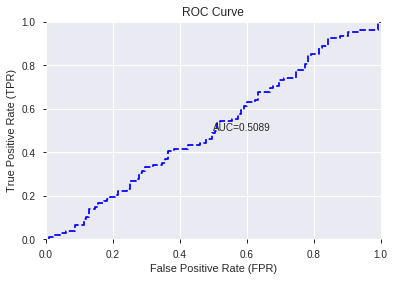

This function is available for GLM models only


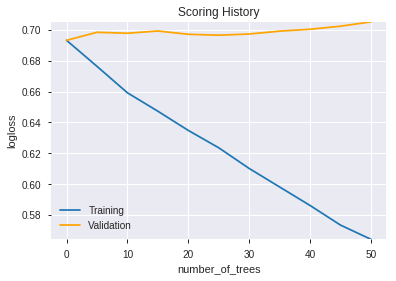

--2019-08-26 18:06:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.49.130
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.49.130|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedT

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_180634_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_180634_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['DIV',
 'HT_PHASOR_quadrature',
 'ADX_14',
 'BOP',
 'STDDEV_8',
 'ADX_8',
 'PLUS_DM_12',
 'STOCH_slowk',
 'BETA_12',
 'MFI_8',
 'ULTOSC',
 'WILLR_8',
 'ADX_24',
 'DX_8',
 'BETA_24',
 'ADX_20',
 'BETA_20',
 'DX_12',
 'CORREL_24',
 'day',
 'STOCHRSI_fastd',
 'ROC_30',
 'NATR_24',
 'DX_14',
 'MINUS_DI_30',
 'ATR_20',
 'aroondown_24',
 'CORREL_14',
 'hour',
 'ROCR_20',
 'MINUS_DM_8',
 'DX_30',
 'MINUS_DI_20',
 'MACDFIX_signal_8',
 'aroonup_24',
 'AROONOSC_20',
 'aroondown_12',
 'DX_24',
 'AROONOSC_24',
 'weekofyear',
 'STOCHRSI_fastk',
 'CORREL_20',
 'dayofweek',
 'aroondown_14',
 'aroonup_8',
 'STOCHF_fastd',
 'weekday',
 'HT_TRENDMODE',
 'days_in_month',
 'quarter']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 919] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_180656_model_4  0.577778  1.546030              0.500000  0.666496  0.444217
1  DeepLearning_grid_1_AutoML_20190826_180656_model_6  0.500000  0.692707              0.500000  0.499780  0.249780
2  DeepLearning_grid_1_AutoML_20190826_180656_model_7  0.500000  0.692979              0.500000  0.499916  0.249916
3  DeepLearning_grid_1_AutoML_20190826_180656_model_8  0.500000  0.692820              0.500000  0.499836  0.249836
4  DeepLearning_grid_1_AutoML_20190826_180656_model_9  0.500000  0.692777              0.500000  0.499815  0.249815
5  DeepLearning_grid_1_AutoML_20190826_180656_model_5  0.500000  0.692741              0.500000  0.499797  0.249797
6               DeepLearning_1_AutoML_20190826_180656  0.480596  0.715714              0.495652  0.510875  0.260993
7  DeepLearning_grid_1_AutoML_20190826_180656_model_2  0.473994  0.802582              0.487238  0.540723  0.292382
8  DeepLearning_grid_1_AutoML_20190826_180656_model_3  0.454026  0.790112              0.500000  0.536659  0.288003
9  DeepLearning_grid_1_AutoML_20190826_180656_model_1  0.444122  3.883625              0.500000  0.690788  0.477188

variable  relative_importance  scaled_importance  percentage
0          CDLCONCEALBABYSWALL             1.000000           1.000000    0.002971
1              CDLHOMINGPIGEON             0.999073           0.999073    0.002968
2          CDLRISEFALL3METHODS             0.996819           0.996819    0.002961
3                 CDLTASUKIGAP             0.992876           0.992876    0.002950
4           CDLMORNINGDOJISTAR             0.977858           0.977858    0.002905
...                        ...                  ...                ...         ...
1034    BBANDS_upperband_8_6_2             0.280793           0.280793    0.000834
1035                    TSF_20             0.280264           0.280264    0.000833
1036  BBANDS_middleband_30_7_2             0.279250           0.279250    0.000830
1037   BBANDS_upperband_24_5_5             0.278891           0.278891    0.000829
1038  BBANDS_middleband_20_2_5             0.277167           0.277167    0.000823

[1039 rows x 4 columns]

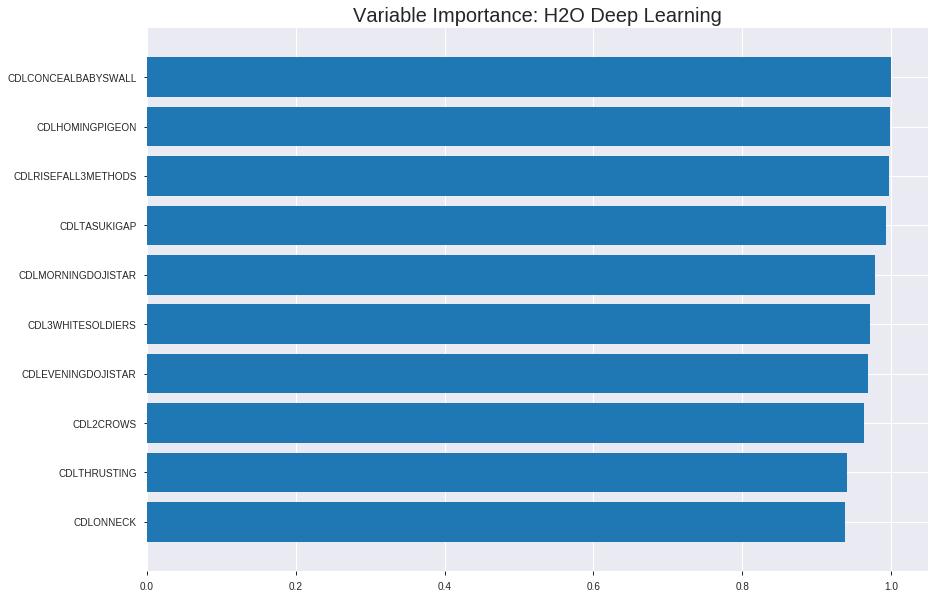

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_180656_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.19816561711020447
RMSE: 0.4451579687147075
LogLoss: 0.6065123329625887
Mean Per-Class Error: 0.27730577310729987
AUC: 0.7947680182413007
pr_auc: 0.8122748916025431
Gini: 0.5895360364826014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2055050284100135: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      455  331  0.4211   (331.0/786.0)
1      140  630  0.1818   (140.0/770.0)
Total  595  961  0.3027   (471.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.205505     0.727903  288
max f2                       0.0335124    0.842659  377
max f0point5                 0.610586     0.740592  133
max accuracy                 0.348134     0.723008  228
max precision                0.999675     1         0
max recall                   0.00223571   1         397
max specificity              0.999675     1         0
max absolute_mcc             0.40663      0.449353  206
max min_per_class_accuracy   0.319811     0.718182  243
max mean_per_class_accuracy  0.343827     0.722694  230

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 38.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.992862           2.02078   2.02078            1                0.995842   1                           0.995842            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.987281           2.02078   2.02078            1                0.989877   1                           0.992859            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.980668           2.02078   2.02078            1                0.984607   1                           0.990226            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.970744           1.89448   1.9887             0.9375           0.976005   0.984127                    0.986614            0.0194805       0.0805195                  89.4481   98.8703
    5        0.0501285                   0.962488           2.02078   1.99487            1                0.967475   0.987179                    0.982933            0.0194805       0.1                        102.078   99.4872
    6        0.100257                    0.899606           1.96896   1.98192            0.974359         0.935461   0.980769                    0.959197            0.0987013       0.198701                   96.8964   98.1918
    7        0.150386                    0.823358           1.7617    1.90851            0.871795         0.865288   0.944444                    0.927894            0.0883117       0.287013                   76.1705   90.8514
    8        0.200514                    0.716258           1.63217   1.83943            0.807692         0.766589   0.910256                    0.887568            0.0818182       0.368831                   63.2168   83.9427
    9        0.300129                    0.576527           1.35588   1.67893            0.670968         0.647343   0.830835                    0.807836            0.135065        0.503896                   35.5878   67.8934
    10       0.400386                    0.426446           1.15288   1.54721            0.570513         0.504694   0.76565                     0.731929            0.115584        0.619481                   15.288    54.721
    11       0.5                         0.312342           1.00387   1.43896            0.496774         0.366741   0.712082                    0.659173            0.1             0.719481                   0.387097  43.8961
    12       0.600257                    0.21633            0.764269  1.32627            0.378205         0.261783   0.656317                    0.592799            0.0766234       0.796104                   -23.5731  32.6272
    13       0.699871                    0.130903           0.690976  1.23585            0.341935         0.171566   0.61157                     0.532844            0.0688312       0.864935                   -30.9024  23.5848
    14       0.800129                    0.0700594          0.582917  1.15404            0.288462         0.100531   0.571084                    0.478675            0.0584416       0.923377                   -41.7083  15.4035
    15       0.899743                    0.0289948          0.573641  1.08978            0.283871         0.0485231  0.539286                    0.431051            0.0571429       0.980519                   -42.6359  8.97774
    16       1                           0.000146489        0.194306  1                  0.0961538        0.0128925  0.494859                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3338039698586103
RMSE: 0.5777577086102879
LogLoss: 0.975940346102983
Mean Per-Class Error: 0.45996639404000317
AUC: 0.5071058385294356
pr_auc: 0.5077874597462052
Gini: 0.014211677058871164
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0484951093104847: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    229  0.9828   (229.0/233.0)
1      0    212  0        (0.0/212.0)
Total  4    441  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0484951    0.649311  395
max f2                       0.0484951    0.822343  395
max f0point5                 0.0571953    0.537169  392
max accuracy                 0.920933     0.555056  52
max precision                0.998846     1         0
max recall                   0.0484951    1         395
max specificity              0.998846     1         0
max absolute_mcc             0.920933     0.109961  52
max min_per_class_accuracy   0.506279     0.497854  201
max mean_per_class_accuracy  0.894508     0.540034  68

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 54.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.99246            1.67925   1.67925            0.8              0.996148  0.8                         0.996148            0.0188679       0.0188679                  67.9245   67.9245
    2        0.0202247                   0.987609           1.57429   1.6326             0.75             0.989815  0.777778                    0.993333            0.0141509       0.0330189                  57.4292   63.26
    3        0.0314607                   0.982431           0.419811  1.19946            0.2              0.985321  0.571429                    0.990472            0.00471698      0.0377358                  -58.0189  19.9461
    4        0.0404494                   0.978095           1.57429   1.28276            0.75             0.979553  0.611111                    0.988045            0.0141509       0.0518868                  57.4292   28.2757
    5        0.0516854                   0.974145           1.67925   1.36895            0.8              0.976335  0.652174                    0.9855              0.0188679       0.0707547                  67.9245   36.895
    6        0.101124                    0.946731           1.04953   1.21279            0.5              0.960436  0.577778                    0.973246            0.0518868       0.122642                   4.95283   21.2788
    7        0.150562                    0.916969           1.24035   1.22184            0.590909         0.931021  0.58209                     0.959381            0.0613208       0.183962                   24.0352   22.1839
    8        0.2                         0.878477           0.954117  1.15566            0.454545         0.896472  0.550562                    0.943831            0.0471698       0.231132                   -4.58834  15.566
    9        0.301124                    0.767928           0.792977  1.03386            0.377778         0.828071  0.492537                    0.904956            0.0801887       0.311321                   -20.7023  3.38637
    10       0.4                         0.650923           1.04953   1.03774            0.5              0.70414   0.494382                    0.855316            0.103774        0.415094                   4.95283   3.77358
    11       0.501124                    0.506279           0.839623  0.997758           0.4              0.591249  0.475336                    0.802029            0.0849057       0.5                        -16.0377  -0.224215
    12       0.6                         0.39523            1.00182   0.998428           0.477273         0.444482  0.475655                    0.743107            0.0990566       0.599057                   0.182247  -0.157233
    13       0.698876                    0.308147           1.00182   0.998908           0.477273         0.353783  0.475884                    0.688026            0.0990566       0.698113                   0.182247  -0.109203
    14       0.8                         0.24933            0.746331  0.966981           0.355556         0.276871  0.460674                    0.636054            0.0754717       0.773585                   -25.3669  -3.30189
    15       0.898876                    0.193007           1.24035   0.997052           0.590909         0.225627  0.475                       0.590907            0.122642        0.896226                   24.0352   -0.294811
    16       1                           0.0136501          1.02621   1                  0.488889         0.124847  0.476404                    0.543778    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:14:00  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:14:05  7.737 sec         137 obs/sec       0.406812  1             633        0.678489         5.02442             -0.841587      0.539753        0.397678           1.13669          0.505141                         0.723573           12.9271               -1.09891         0.500577          0.0932609            1.30286            0.507865
    2019-08-26 18:14:34  37.227 sec        145 obs/sec       2.92995   7             4559       0.640071         2.08761             -0.638937      0.558618        0.515785           1.51558          0.486504                         0.709689           3.71934               -1.01913         0.498785          0.463573             1.25943            0.519101
    2019-08-26 18:15:06  1 min  8.483 sec  154 obs/sec       5.93059   14            9228       0.578358         1.43558             -0.338135      0.585619        0.594791           1.64188          0.505141                         0.652277           3.04377               -0.705659        0.51987           0.495134             0.419811           0.523596
    2019-08-26 18:15:34  1 min 37.453 sec  161 obs/sec       8.8946    21            13840      0.58496          1.73022             -0.36886       0.610722        0.60308            1.64188          0.505141                         0.609399           1.16254               -0.488783        0.521328          0.512054             1.67925            0.510112
    2019-08-26 18:16:04  2 min  6.762 sec  164 obs/sec       11.8824   28            18489      0.508604         0.822651            -0.0348207     0.696693        0.688535           1.76818          0.401028                         0.636827           1.38874               -0.625816        0.476253          0.477708             1.25943            0.516854
    2019-08-26 18:16:34  2 min 36.993 sec  169 obs/sec       15.2648   36            23752      0.545861         0.949936            -0.191984      0.718121        0.728883           1.76818          0.382391                         0.657538           1.97999               -0.733286        0.514029          0.506014             1.25943            0.521348
    2019-08-26 18:17:03  3 min  6.008 sec  174 obs/sec       18.588    44            28923      0.507819         0.893024            -0.0316304     0.693537        0.700799           2.02078          0.423522                         0.572187           1.04289               -0.312514        0.527705          0.488702             0.839623           0.51236
    2019-08-26 18:17:32  3 min 34.592 sec  178 obs/sec       21.9512   52            34156      0.477018         0.718773            0.0897206      0.744082        0.749001           2.02078          0.342545                         0.629236           1.32967               -0.587286        0.53395           0.521901             1.67925            0.514607
    2019-08-26 18:18:00 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLCONCEALBABYSWALL       1.0                    1.0                  0.002970902861652162
CDLHOMINGPIGEON           0.999073326587677      0.999073326587677    0.0029681498049596747
CDLRISEFALL3METHODS       0.996819257736206      0.996819257736206    0.0029614531853584787
CDLTASUKIGAP              0.9928756952285767     0.9928756952285767   0.0029497372442194585
CDLMORNINGDOJISTAR        0.9778579473495483     0.9778579473495483   0.0029051209740700826
---                       ---                    ---                  ---
BBANDS_upperband_8_6_2    0.2807927429676056     0.2807927429676056   0.0008342079636136195
TSF_20                    0.2802640497684479     0.2802640497684479   0.0008326372674753058
BBANDS_middleband_30_7_2  0.2792498767375946     0.2792498767375946   0.0008296242579157333
BBANDS_upperband_24_5_5   0.27889135479927063    0.27889135479927063  0.0008285591240632015
BBANDS_middleband_20_2_5  0.2771669626235962     0.2771669626235962   0.0008234361224138798


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6233183856502242)

('F1', 0.6525679758308157)

('auc', 0.5777777777777777)

('logloss', 1.5460304894412886)

('mean_per_class_error', 0.37902576489533013)

('rmse', 0.6664957310188222)

('mse', 0.44421655946631416)

deeplearning prediction progress: |███████████████████████████████████████| 100%


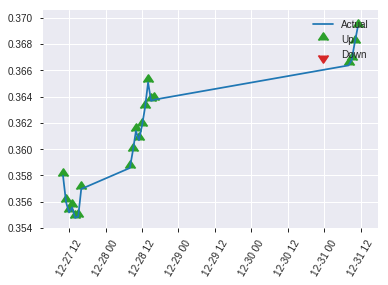


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.44421655946631416
RMSE: 0.6664957310188222
LogLoss: 1.5460304894412886
Mean Per-Class Error: 0.37902576489533013
AUC: 0.5777777777777777
pr_auc: 0.5706381576009162
Gini: 0.15555555555555545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3850728363456887: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    108  0        (0.0/108.0)
Total  0    223  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.385073     0.652568  222
max f2                       0.385073     0.824427  222
max f0point5                 0.953774     0.609504  93
max accuracy                 0.953774     0.623318  93
max precision                0.99977      1         0
max recall                   0.385073     1         222
max specificity              0.99977      1         0
max absolute_mcc             0.953774     0.244864  93
max min_per_class_accuracy   0.942758     0.6       110
max mean_per_class_accuracy  0.953774     0.620974  93

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 91.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.998851           1.37654   1.37654            0.666667         0.999391  0.666667                    0.999391            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.998159           2.06481   1.65185            1                0.998411  0.8                         0.998999            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.997987           2.06481   1.76984            1                0.998068  0.857143                    0.998733            0.0185185       0.0555556                  106.481   76.9841
    4        0.0403587                   0.997008           1.03241   1.60597            0.5              0.997631  0.777778                    0.998488            0.00925926      0.0648148                  3.24074   60.5967
    5        0.0538117                   0.996774           0.688272  1.37654            0.333333         0.996912  0.666667                    0.998094            0.00925926      0.0740741                  -31.1728  37.6543
    6        0.103139                    0.989992           0.938552  1.16707            0.454545         0.992576  0.565217                    0.995455            0.0462963       0.12037                    -6.14478  16.7069
    7        0.152466                    0.985643           1.8771    1.39679            0.909091         0.987561  0.676471                    0.992901            0.0925926       0.212963                   87.7104   39.6786
    8        0.201794                    0.981981           1.31397   1.37654            0.636364         0.983345  0.666667                    0.990565            0.0648148       0.277778                   31.3973   37.6543
    9        0.300448                    0.969088           1.03241   1.26354            0.5              0.976078  0.61194                     0.985808            0.101852        0.37963                    3.24074   26.3543
    10       0.399103                    0.957597           1.31397   1.27601            0.636364         0.962628  0.617978                    0.980078            0.12963         0.509259                   31.3973   27.6009
    11       0.502242                    0.94274            0.897746  1.19833            0.434783         0.950292  0.580357                    0.973961            0.0925926       0.601852                   -10.2254  19.833
    12       0.600897                    0.928411           0.469276  1.07863            0.227273         0.934992  0.522388                    0.967563            0.0462963       0.648148                   -53.0724  7.86346
    13       0.699552                    0.902838           0.656987  1.01917            0.318182         0.916013  0.49359                     0.960293            0.0648148       0.712963                   -34.3013  1.91714
    14       0.798206                    0.878581           0.844697  0.997607           0.409091         0.892411  0.483146                    0.951904            0.0833333       0.796296                   -15.5303  -0.239284
    15       0.896861                    0.806302           0.656987  0.960139           0.318182         0.84954   0.465                       0.940644            0.0648148       0.861111                   -34.3013  -3.98611
    16       1                           0.385073           1.34662   1                  0.652174         0.673945  0.484305                    0.913137       

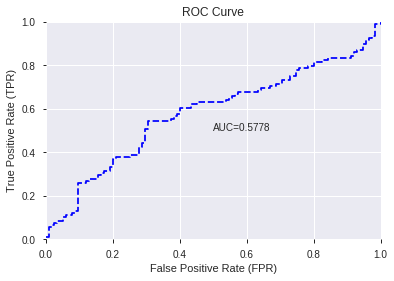

This function is available for GLM models only


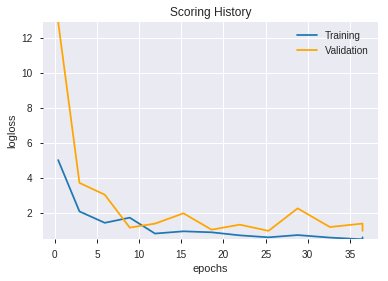

--2019-08-26 18:42:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_180656_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_180656_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCONCEALBABYSWALL',
 'CDLHOMINGPIGEON',
 'CDLRISEFALL3METHODS',
 'CDLTASUKIGAP',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDL2CROWS',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLHIKKAKEMOD',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'CDLPIERCING',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLIDENTICAL3CROWS',
 'CDLMORNINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'CDLADVANCEBLOCK',
 'CDL3INSIDE',
 'CDLXSIDEGAP3METHODS',
 'CDLINVERTEDHAMMER',
 'CDLSEPARATINGLINES',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'is_month_start',
 'CDLHANGINGMAN',
 'CDLDRAGONFLYDOJI',
 'is_month_end',
 'CDLTAKURI',
 'CDLHAMMER',
 'BOP',
 'CORREL_30',
 'hour',
 'Volume',
 'HT_TRENDMODE',
 'CORREL_8',
 'aroondown_8',
 'SUB',
 'weekday_name',
 'CDLRICKSHAWMAN',
 'dayofweek',
 'weekday',
 'CDLDOJISTAR',
 'CORREL_24',
 'VAR_8',
 'STOCH_slowd',
 'CDLDOJI',
 'HT_PHASOR_inphase',
 'DIV',
 'VAR_14',
 'TRANGE',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'BETA_12',
 'BETA

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190826_184206_model_1  0.555233  0.710673               0.48752  0.508596  0.25867

variable  relative_importance  scaled_importance    percentage
0           CDLIDENTICAL3CROWS         3.506675e-02           1.000000  1.763872e-02
1            CDLSTALLEDPATTERN         3.333405e-02           0.950588  1.676717e-02
2                    CDLHAMMER         2.947637e-02           0.840579  1.482674e-02
3                   CDLHIKKAKE         2.861997e-02           0.816157  1.439596e-02
4           CDLEVENINGDOJISTAR         2.578554e-02           0.735327  1.297024e-02
...                        ...                  ...                ...           ...
1034  BBANDS_middleband_20_7_3         2.368640e-06           0.000068  1.191436e-06
1035                    T3_8_5         1.599048e-06           0.000046  8.043280e-07
1036  BBANDS_middleband_30_7_5         1.113420e-06           0.000032  5.600552e-07
1037  BBANDS_middleband_30_7_4         5.747471e-07           0.000016  2.891002e-07
1038                   MA_20_2         2.250327e-07           0.000006  1.131924e-07

[1039 rows x 4 columns]

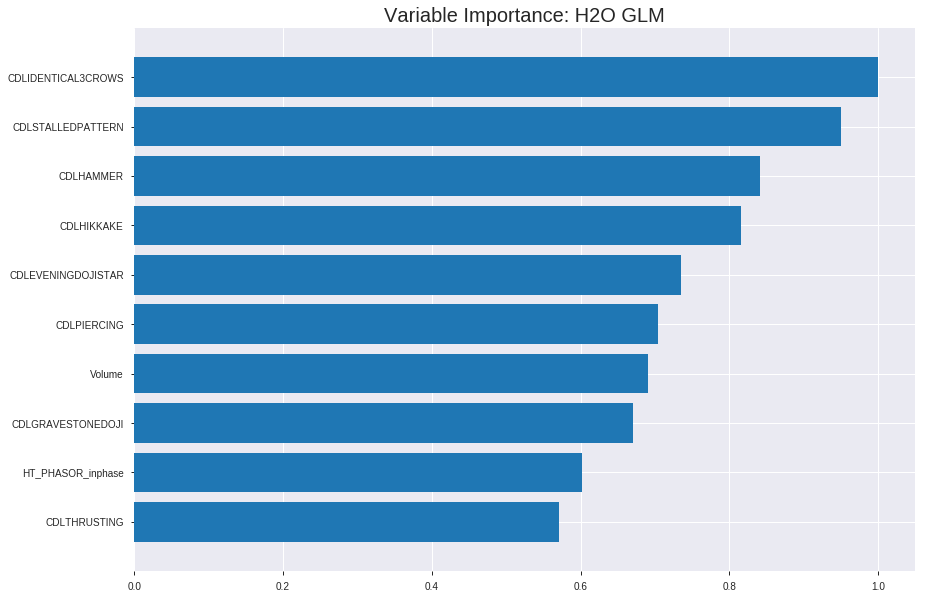

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_184206_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24228983596301473
RMSE: 0.49222945458699924
LogLoss: 0.677557738214748
Null degrees of freedom: 1555
Residual degrees of freedom: 516
Null deviance: 2156.909498581488
Residual deviance: 2108.559681324295
AIC: 4188.5596813242955
AUC: 0.618539539341066
pr_auc: 0.6238651608736349
Gini: 0.23707907868213196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39642597126278767: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      28   758   0.9644   (758.0/786.0)
1      4    766   0.0052   (4.0/770.0)
Total  32   1524  0.4897   (762.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396426     0.667829  375
max f2                       0.396426     0.831885  375
max f0point5                 0.514883     0.584871  140
max accuracy                 0.514883     0.6009    140
max precision                0.667576     1         0
max recall                   0.355141     1         394
max specificity              0.667576     1         0
max absolute_mcc             0.514883     0.213669  140
max min_per_class_accuracy   0.497762     0.572727  190
max mean_per_class_accuracy  0.514883     0.598974  140

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.612425           2.02078   2.02078            1                0.637538  1                           0.637538            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.583922           1.51558   1.76818            0.75             0.597557  0.875                       0.617547            0.0155844       0.0363636                  51.5584   76.8182
    3        0.0302057                   0.572712           1.4819    1.67682            0.733333         0.577853  0.829787                    0.604879            0.0142857       0.0506494                  48.1905   67.6817
    4        0.0404884                   0.565849           1.38929   1.60379            0.6875           0.569125  0.793651                    0.595799            0.0142857       0.0649351                  38.9286   60.3793
    5        0.0501285                   0.561118           1.4819    1.58035            0.733333         0.563331  0.782051                    0.589555            0.0142857       0.0792208                  48.1905   58.0353
    6        0.100257                    0.544926           1.34719   1.46377            0.666667         0.552305  0.724359                    0.57093             0.0675325       0.146753                   34.7186   46.377
    7        0.150386                    0.53452            1.29537   1.40764            0.641026         0.538911  0.696581                    0.560257            0.0649351       0.211688                   29.5371   40.7637
    8        0.200514                    0.5275             1.21765   1.36014            0.602564         0.530883  0.673077                    0.552914            0.061039        0.272727                   21.7649   36.014
    9        0.300129                    0.516264           1.23854   1.31978            0.612903         0.521945  0.653105                    0.542635            0.123377        0.396104                   23.8542   31.9781
    10       0.400386                    0.506011           0.893806  1.21312            0.442308         0.510923  0.600321                    0.534694            0.0896104       0.485714                   -10.6194  21.3116
    11       0.5                         0.49746            0.899573  1.15065            0.445161         0.501761  0.569409                    0.528133            0.0896104       0.575325                   -10.0427  15.0649
    12       0.600257                    0.487649           0.945621  1.1164             0.467949         0.492594  0.552463                    0.522197            0.0948052       0.67013                    -5.4379   11.6405
    13       0.699871                    0.476009           0.925647  1.08925            0.458065         0.482095  0.539027                    0.516489            0.0922078       0.762338                   -7.43527  8.92538
    14       0.800129                    0.460814           0.932667  1.06963            0.461538         0.468764  0.529317                    0.510509            0.0935065       0.855844                   -6.73327  6.96333
    15       0.899743                    0.441213           0.795274  1.03926            0.393548         0.451075  0.514286                    0.503929            0.0792208       0.935065                   -20.4726  3.92579
    16       1                           0.315832           0.647686  1                  0.320513         0.413458  0.494859                    0.494859           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25227412690250395
RMSE: 0.5022689786384422
LogLoss: 0.6977564044572496
Null degrees of freedom: 444
Residual degrees of freedom: -595
Null deviance: 616.5161536496719
Residual deviance: 621.0031999669521
AIC: 2701.0031999669523
AUC: 0.5254069155397199
pr_auc: 0.48501397511812
Gini: 0.05081383107943971
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3929202984479937: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    233  1        (233.0/233.0)
1      0    212  0        (0.0/212.0)
Total  0    445  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39292      0.645358  399
max f2                       0.39292      0.819799  399
max f0point5                 0.513036     0.55      266
max accuracy                 0.513183     0.548315  264
max precision                0.708791     1         0
max recall                   0.39292      1         399
max specificity              0.708791     1         0
max absolute_mcc             0.513036     0.119451  266
max min_per_class_accuracy   0.53089      0.515021  201
max mean_per_class_accuracy  0.513036     0.556341  266

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 53.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.617648           0.839623  0.839623           0.4              0.645942  0.4                         0.645942            0.00943396      0.00943396                 -16.0377  -16.0377
    2        0.0202247                   0.609258           1.04953   0.932914           0.5              0.613904  0.444444                    0.631703            0.00943396      0.0188679                  4.95283   -6.7086
    3        0.0314607                   0.601674           1.25943   1.04953            0.6              0.606624  0.5                         0.622746            0.0141509       0.0330189                  25.9434   4.95283
    4        0.0404494                   0.59681            1.57429   1.16614            0.75             0.599588  0.555556                    0.6176              0.0141509       0.0471698                  57.4292   16.6143
    5        0.0516854                   0.592315           0.419811  1.0039             0.2              0.59447   0.478261                    0.612572            0.00471698      0.0518868                  -58.0189  0.389664
    6        0.101124                    0.577484           0.954117  0.97956            0.454545         0.58269   0.466667                    0.597963            0.0471698       0.0990566                  -4.58834  -2.04403
    7        0.150562                    0.569398           1.14494   1.03386            0.545455         0.572418  0.492537                    0.589575            0.0566038       0.15566                    14.494    3.38637
    8        0.2                         0.564492           1.14494   1.06132            0.545455         0.566401  0.505618                    0.583846            0.0566038       0.212264                   14.494    6.13208
    9        0.301124                    0.554223           0.932914  1.0182             0.444444         0.558927  0.485075                    0.575478            0.0943396       0.306604                   -6.7086   1.81991
    10       0.4                         0.541172           1.00182   1.01415            0.477273         0.547825  0.483146                    0.568643            0.0990566       0.40566                    0.182247  1.41509
    11       0.501124                    0.53089            1.1195    1.03541            0.533333         0.535644  0.493274                    0.561984            0.113208        0.518868                   11.9497   3.54091
    12       0.6                         0.519899           1.14494   1.05346            0.545455         0.525896  0.501873                    0.556037            0.113208        0.632075                   14.494    5.34591
    13       0.698876                    0.507836           1.14494   1.0664             0.545455         0.51484   0.508039                    0.550208            0.113208        0.745283                   14.494    6.64017
    14       0.8                         0.498493           0.65304   1.01415            0.311111         0.503128  0.483146                    0.544257            0.0660377       0.811321                   -34.696   1.41509
    15       0.898876                    0.486006           1.09723   1.02329            0.522727         0.492983  0.4875                      0.538617            0.108491        0.919811                   9.72341   2.32901
    16       1                           0.39292            0.792977  1                  0.377778         0.465819  0.476404                    0.531255      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 18:42:09  0.000 sec   2            3.1       1034          1.37469           1.39845
    2019-08-26 18:42:11  1.844 sec   4            2.2       1036          1.37189           1.3978
    2019-08-26 18:42:13  3.677 sec   6            1.6       1036          1.36855           1.39704
    2019-08-26 18:42:15  5.502 sec   8            1.2       1039          1.36463           1.39631
    2019-08-26 18:42:17  7.331 sec   10           0.86      1039          1.36013           1.39574
    2019-08-26 18:42:19  9.252 sec   12           0.63      1040          1.35512           1.39551
    2019-08-26 18:42:20  11.134 sec  14           0.46      1040          1.34967           1.39578
    2019-08-26 18:42:22  13.003 sec  16           0.33      1040          1.34391           1.39672
    2019-08-26 18:42:24  14.987 sec  18           0.24      1040          1.33794           1.39841
    2019-08-26 18:42:26  16.841 sec  20           0.18      1040          1.33188           1.40094
    2019-08-26 18:42:28  18.708 sec  22           0.13      1040          1.32581           1.40438

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5874439461883408)

('F1', 0.654320987654321)

('auc', 0.5552334943639292)

('logloss', 0.7106734652763449)

('mean_per_class_error', 0.412962962962963)

('rmse', 0.5085958119332666)

('mse', 0.2586696999160587)

glm prediction progress: |████████████████████████████████████████████████| 100%


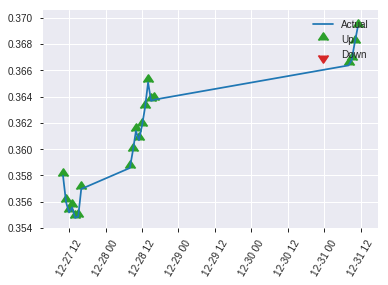


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2586696999160587
RMSE: 0.5085958119332666
LogLoss: 0.7106734652763449
Null degrees of freedom: 222
Residual degrees of freedom: -817
Null deviance: 309.02325884747086
Residual deviance: 316.9603655132499
AIC: 2396.96036551325
AUC: 0.5552334943639292
pr_auc: 0.5390289775259526
Gini: 0.11046698872785843
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5168766668959309: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    110  0.9565   (110.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  7    216  0.5022   (112.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516877     0.654321  215
max f2                       0.371788     0.824427  222
max f0point5                 0.591461     0.574074  107
max accuracy                 0.592185     0.587444  103
max precision                0.757819     1         0
max recall                   0.371788     1         222
max specificity              0.757819     1         0
max absolute_mcc             0.591461     0.174074  107
max min_per_class_accuracy   0.591461     0.574074  107
max mean_per_class_accuracy  0.591461     0.587037  107

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 58.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.686963           1.37654   1.37654            0.666667         0.735874  0.666667                    0.735874            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.661977           1.03241   1.23889            0.5              0.662226  0.6                         0.706415            0.00925926      0.0277778                  3.24074   23.8889
    3        0.0313901                   0.656832           1.03241   1.17989            0.5              0.659773  0.571429                    0.693089            0.00925926      0.037037                   3.24074   17.9894
    4        0.0403587                   0.653902           2.06481   1.37654            1                0.656159  0.666667                    0.684882            0.0185185       0.0555556                  106.481   37.6543
    5        0.0538117                   0.652241           0.688272  1.20448            0.333333         0.652992  0.583333                    0.676909            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.640943           1.31397   1.25684            0.636364         0.644218  0.608696                    0.661274            0.0648148       0.12963                    31.3973   25.6844
    7        0.152466                    0.628145           1.31397   1.27533            0.636364         0.633007  0.617647                    0.652129            0.0648148       0.194444                   31.3973   27.5327
    8        0.201794                    0.621035           0.938552  1.193              0.454545         0.625173  0.577778                    0.64554             0.0462963       0.240741                   -6.14478  19.3004
    9        0.300448                    0.607339           1.03241   1.14027            0.5              0.61277   0.552239                    0.63478             0.101852        0.342593                   3.24074   14.0271
    10       0.399103                    0.597231           1.22012   1.16001            0.590909         0.601882  0.561798                    0.626647            0.12037         0.462963                   22.0118   16.0008
    11       0.502242                    0.589757           1.16707   1.16146            0.565217         0.593199  0.5625                      0.619778            0.12037         0.583333                   16.7069   16.1458
    12       0.600897                    0.582024           0.375421  1.03241            0.181818         0.586015  0.5                         0.614235            0.037037        0.62037                    -62.4579  3.24074
    13       0.699552                    0.570596           0.656987  0.979463           0.318182         0.575345  0.474359                    0.608751            0.0648148       0.685185                   -34.3013  -2.05366
    14       0.798206                    0.556214           1.22012   1.00921            0.590909         0.565027  0.488764                    0.603347            0.12037         0.805556                   22.0118   0.920724
    15       0.896861                    0.534201           0.938552  1.00144            0.454545         0.545723  0.485                       0.597008            0.0925926       0.898148                   -6.14478  0.143519
    16       1                           0.371788           0.98752   1                  0.478261         0.508752  0.484305                    0.587906      

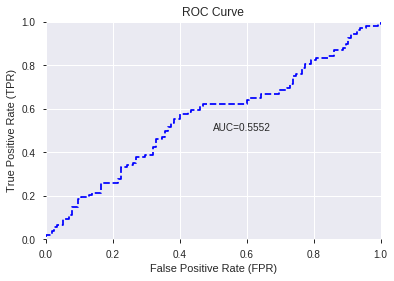

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


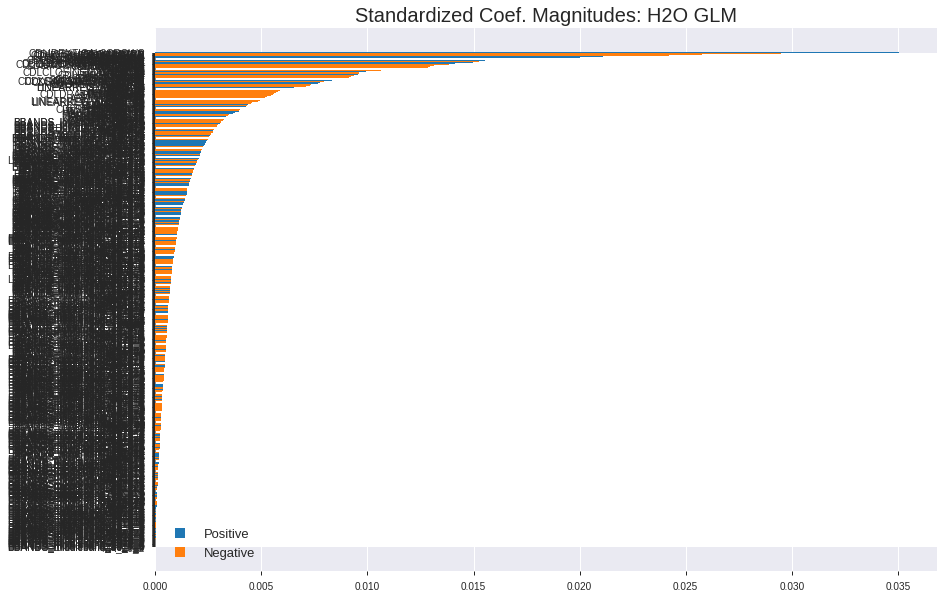

'log_likelihood'
--2019-08-26 18:42:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.134.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.134.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_184206_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_184206_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN',
 'CDLHAMMER',
 'CDLHIKKAKE',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'Volume',
 'CDLGRAVESTONEDOJI',
 'HT_PHASOR_inphase',
 'CDLTHRUSTING',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'is_month_start',
 'CDLENGULFING',
 'CDLDARKCLOUDCOVER',
 'HT_PHASOR_quadrature',
 'CDLHARAMI',
 'CDL2CROWS',
 'CDLSHORTLINE',
 'CDLTASUKIGAP',
 'CDLHOMINGPIGEON',
 'CDLRISEFALL3METHODS',
 'CDL3WHITESOLDIERS',
 'CDLCONCEALBABYSWALL',
 'CDLMORNINGDOJISTAR',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroonup_8',
 'CDLHIGHWAVE',
 'dayofyear',
 'weekofyear',
 'week',
 'DX_14',
 'DX_8',
 'VAR_14',
 'month',
 'DX_12',
 'ADX_24',
 'STOCH_slowd',
 'DX_20',
 'CDLCLOSINGMARUBOZU',
 'ROC_24',
 'ROCR_24',
 'MFI_24',
 'ROCP_24',
 'ROCR100_24',
 'CDLHIKKAKEMOD',
 'aroondown_8',
 'MOM_24',
 'MFI_8',
 'DIV',
 'MFI_30',
 'SUB',
 'CDLBELTHOLD',
 'CDLHANGINGMAN',
 'CCI_30',
 'CCI_8',
 'CDLMATCHINGLOW',
 'CDLGAPSIDESIDEWHITE',
 'CDLXSIDEGAP3METHODS',
 'CDLSEPARATINGLINES',
 'DX_24',
 'CORREL_24

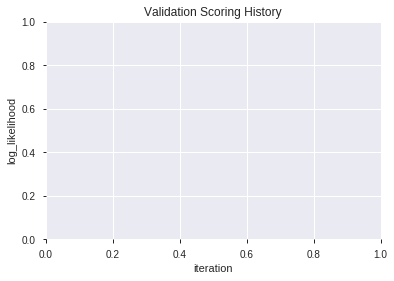

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190826_184254  0.513043  0.730532              0.495652  0.517489  0.267795
1  XGBoost_grid_1_AutoML_20190826_184254_model_5  0.506039  0.896955              0.495652  0.576302  0.332124
2               XGBoost_3_AutoML_20190826_184254  0.500403  0.755612              0.495652  0.528752  0.279579
3  XGBoost_grid_1_AutoML_20190826_184254_model_7  0.499195  0.788598              0.495652  0.541308  0.293015
4  XGBoost_grid_1_AutoML_20190826_184254_model_2  0.467713  0.712906              0.500000  0.509714  0.259808
5  XGBoost_grid_1_AutoML_20190826_184254_model_6  0.460709  0.822832              0.500000  0.554433  0.307395
6  XGBoost_grid_1_AutoML_20190826_184254_model_1  0.457971  0.929466              0.500000  0.588103  0.345865
7               XGBoost_2_AutoML_20190826_184254  0.446135  0.720488              0.500000  0.512967  0.263135
8  XGBoost_grid_1_AutoML_20190826_184254_model_3  0.433736  0.815550              0.495652  0.551899  0.304592
9  XGBoost_grid_1_AutoML_20190826_184254_model_4  0.399678  0.723463              0.495652  0.514717  0.264933

variable  relative_importance  scaled_importance  percentage
0                     Volume           140.883911           1.000000    0.017976
1          HT_PHASOR_inphase           136.130066           0.966257    0.017370
2                  STDDEV_12           118.528305           0.841319    0.015124
3                    WILLR_8           108.779686           0.772123    0.013880
4                        BOP           104.305954           0.740368    0.013309
..                       ...                  ...                ...         ...
419   BBANDS_upperband_8_0_2             0.611863           0.004343    0.000078
420   BBANDS_upperband_8_4_2             0.581083           0.004125    0.000074
421                 MAVP_8_0             0.261496           0.001856    0.000033
422             HT_TRENDMODE             0.101139           0.000718    0.000013
423  BBANDS_upperband_24_5_5             0.084528           0.000600    0.000011

[424 rows x 4 columns]

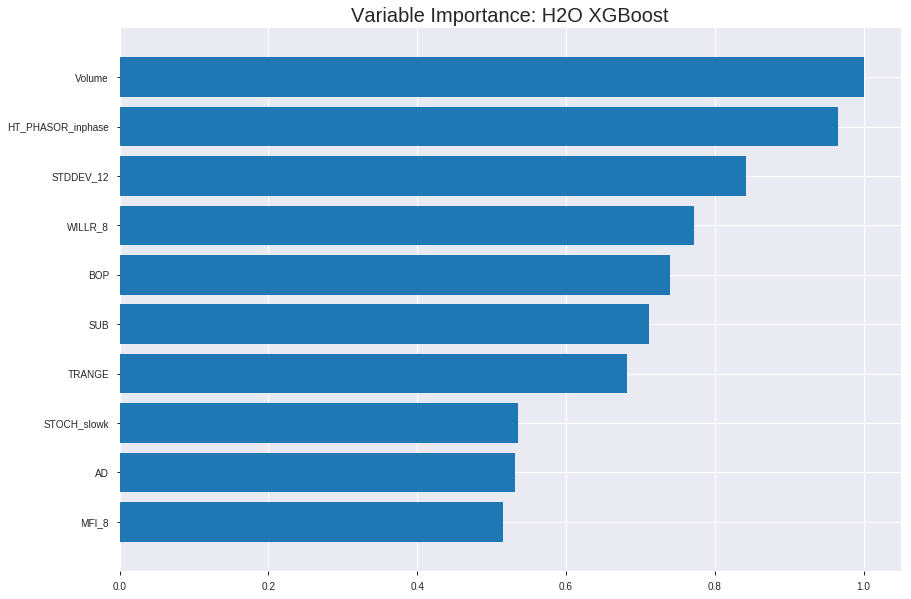

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190826_184254


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13934849692684628
RMSE: 0.3732941158481423
LogLoss: 0.46143922472942744
Mean Per-Class Error: 0.05785995175308156
AUC: 0.9850442814183272
pr_auc: 0.9831476628155864
Gini: 0.9700885628366545
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49498798946539563: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      742  44   0.056    (44.0/786.0)
1      46   724  0.0597   (46.0/770.0)
Total  788  768  0.0578   (90.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494988     0.941482  200
max f2                       0.457944     0.956522  220
max f0point5                 0.530741     0.951503  179
max accuracy                 0.497266     0.942159  198
max precision                0.863626     1         0
max recall                   0.367343     1         288
max specificity              0.863626     1         0
max absolute_mcc             0.497266     0.884393  198
max min_per_class_accuracy   0.49378      0.941476  201
max mean_per_class_accuracy  0.494988     0.94214   200

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.781062           2.02078    2.02078            1                0.803459  1                           0.803459            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.770867           2.02078    2.02078            1                0.776419  1                           0.789939            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.760682           2.02078    2.02078            1                0.765292  1                           0.782073            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.750675           2.02078    2.02078            1                0.755584  1                           0.775346            0.0207792       0.0818182                  102.078   102.078
    5        0.0501285                   0.739485           2.02078    2.02078            1                0.744754  1                           0.769462            0.0194805       0.101299                   102.078   102.078
    6        0.100257                    0.705946           2.02078    2.02078            1                0.722756  1                           0.746109            0.101299        0.202597                   102.078   102.078
    7        0.150386                    0.679115           2.02078    2.02078            1                0.692499  1                           0.728239            0.101299        0.303896                   102.078   102.078
    8        0.200514                    0.660944           1.99487    2.0143             0.987179         0.670331  0.996795                    0.713762            0.1             0.403896                   99.4872   101.43
    9        0.300129                    0.613213           1.98167    2.00347            0.980645         0.637328  0.991435                    0.688393            0.197403        0.601299                   98.1667   100.347
    10       0.400386                    0.555073           1.95601    1.99159            0.967949         0.58497   0.985554                    0.662496            0.196104        0.797403                   95.6011   99.1587
    11       0.5                         0.48857            1.44714    1.88312            0.716129         0.523441  0.931877                    0.634792            0.144156        0.941558                   44.7139   88.3117
    12       0.600257                    0.417927           0.492241   1.65081            0.24359          0.448988  0.816916                    0.603758            0.0493506       0.990909                   -50.7759  65.0808
    13       0.699871                    0.375141           0.0521491  1.42327            0.0258065        0.3957    0.704316                    0.574145            0.00519481      0.996104                   -94.7851  42.3267
    14       0.800129                    0.333825           0.0388611  1.2498             0.0192308        0.353682  0.618474                    0.546521            0.0038961       1                          -96.1139  24.9799
    15       0.899743                    0.286668           0          1.11143            0                0.309479  0.55                        0.520277            0               1                          -100      11.1429
    16       1                           0.159589           0          1                  0                0.254136  0.494859                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2654987590994101
RMSE: 0.5152657169843634
LogLoss: 0.7263453939065535
Mean Per-Class Error: 0.47172848003886947
AUC: 0.5073993845655519
pr_auc: 0.48127325608596766
Gini: 0.014798769131103784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3615250587463379: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   219  0.9399   (219.0/233.0)
1      5    207  0.0236   (5.0/212.0)
Total  19   426  0.5034   (224.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.361525     0.648903   380
max f2                       0.235611     0.819799   399
max f0point5                 0.361525     0.540188   380
max accuracy                 0.667752     0.537079   63
max precision                0.779441     1          0
max recall                   0.235611     1          399
max specificity              0.779441     1          0
max absolute_mcc             0.361525     0.0901713  380
max min_per_class_accuracy   0.568077     0.509434   194
max mean_per_class_accuracy  0.54223      0.528272   235

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 56.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.760793           0.839623  0.839623           0.4              0.772328  0.4                         0.772328            0.00943396      0.00943396                 -16.0377  -16.0377
    2        0.0202247                   0.74183            0.524764  0.699686           0.25             0.747126  0.333333                    0.761127            0.00471698      0.0141509                  -47.5236  -30.0314
    3        0.0314607                   0.740067           1.67925   1.04953            0.8              0.741114  0.5                         0.75398             0.0188679       0.0330189                  67.9245   4.95283
    4        0.0404494                   0.723952           1.04953   1.04953            0.5              0.733035  0.5                         0.749325            0.00943396      0.0424528                  4.95283   4.95283
    5        0.0516854                   0.71708            0.839623  1.0039             0.4              0.720429  0.478261                    0.743044            0.00943396      0.0518868                  -16.0377  0.389664
    6        0.101124                    0.687339           1.04953   1.02621            0.5              0.702351  0.488889                    0.72315             0.0518868       0.103774                   4.95283   2.62055
    7        0.150562                    0.667843           1.33576   1.12785            0.636364         0.675606  0.537313                    0.707538            0.0660377       0.169811                   33.5763   12.7851
    8        0.2                         0.653605           0.954117  1.08491            0.454545         0.661677  0.516854                    0.696202            0.0471698       0.216981                   -4.58834  8.49057
    9        0.301124                    0.620567           0.746331  0.971205           0.355556         0.636469  0.462687                    0.676142            0.0754717       0.292453                   -25.3669  -2.87947
    10       0.4                         0.594497           0.954117  0.966981           0.454545         0.60752   0.460674                    0.65918             0.0943396       0.386792                   -4.58834  -3.30189
    11       0.501124                    0.567671           1.21279   1.01658            0.577778         0.580899  0.484305                    0.643383            0.122642        0.509434                   21.2788   1.65835
    12       0.6                         0.541104           1.19265   1.0456             0.568182         0.553691  0.498127                    0.628602            0.117925        0.627358                   19.2646   4.55975
    13       0.698876                    0.514336           0.858705  1.01916            0.409091         0.526978  0.485531                    0.614225            0.0849057       0.712264                   -14.1295  1.91561
    14       0.8                         0.471629           0.746331  0.98467            0.355556         0.494225  0.469101                    0.599056            0.0754717       0.787736                   -25.3669  -1.53302
    15       0.898876                    0.422961           1.19265   1.00755            0.568182         0.452351  0.48                        0.582918            0.117925        0.90566                    19.2646   0.754717
    16       1                           0.235611           0.932914  1                  0.444444         0.357243  0.476404                    0.560097  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:42:54  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.505141                         0.5                0.693147              0.5               0                    1                  0.523596
    2019-08-26 18:42:55  0.794 sec   5                  0.481875         0.657441            0.834416        0.830936           2.02078          0.246144                         0.499777           0.692698              0.503148          0.486461             0.839623           0.507865
    2019-08-26 18:42:55  1.018 sec   10                 0.466671         0.628241            0.894671        0.889376           2.02078          0.177378                         0.501583           0.696327              0.512106          0.493111             0.839623           0.516854
    2019-08-26 18:42:56  1.248 sec   15                 0.452961         0.602451            0.924014        0.923304           2.02078          0.162596                         0.505281           0.703919              0.496589          0.466573             0.839623           0.505618
    2019-08-26 18:42:56  1.490 sec   20                 0.438752         0.57627             0.949509        0.9467             2.02078          0.123393                         0.50567            0.704787              0.508705          0.487465             1.25943            0.51236
    2019-08-26 18:42:56  1.723 sec   25                 0.424445         0.550244            0.95675         0.95402            2.02078          0.12018                          0.506609           0.7067                0.497429          0.476157             0.839623           0.510112
    2019-08-26 18:42:56  1.935 sec   30                 0.413477         0.530669            0.965231        0.96088            2.02078          0.090617                         0.507391           0.708467              0.505962          0.483763             1.25943            0.510112
    2019-08-26 18:42:57  2.164 sec   35                 0.402483         0.511254            0.970741        0.968232           2.02078          0.0886889                        0.509857           0.713805              0.495151          0.471648             1.25943            0.510112
    2019-08-26 18:42:57  2.387 sec   40                 0.392887         0.494549            0.974657        0.972037           2.02078          0.0803342                        0.513364           0.721576              0.499261          0.474531             0.839623           0.516854
    2019-08-26 18:42:57  2.629 sec   45                 0.382818         0.477379            0.979987        0.977621           2.02078          0.0687661                        0.513853           0.722959              0.503917          0.477928             0.839623           0.503371
    2019-08-26 18:42:57  2.854 sec   50                 0.373294         0.461439            0.985044        0.983148           2.02078          0.0578406                        0.515266           0.726345              0.507399          0.481273             0.839623           0.503371

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
Volume                   140.8839111328125      1.0                    0.017976237565834233
HT_PHASOR_inphase        136.13006591796875     0.9662570042482548     0.017369665458017925
STDDEV_12                118.52830505371094     0.8413189561579765     0.015123749424535461
WILLR_8                  108.7796859741211      0.7721228428388358     0.013879863652878202
BOP                      104.30595397949219     0.7403681026512818     0.013309032899425388
---                      ---                    ---                    ---
BBANDS_upperband_8_0_2   0.6118631362915039     0.00434303059427911    7.80713497184475e-05
BBANDS_upperband_8_4_2   0.5810832977294922     0.004124553989573017   7.414396236967393e-05
MAVP_8_0                 0.26149559020996094    0.0018561068336855494  3.336581738989981e-05
HT_TRENDMODE             0.10113906860351562    0.0007178894154079165  1.2904950677370567e-05
BBANDS_upperband_24_5_5  0.08452796936035156    0.0005999831256861282  1.078543920282562e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6545454545454547)

('auc', 0.5130434782608696)

('logloss', 0.7305316774708493)

('mean_per_class_error', 0.4449677938808374)

('rmse', 0.5174888370007388)

('mse', 0.2677946964203772)

xgboost prediction progress: |████████████████████████████████████████████| 100%


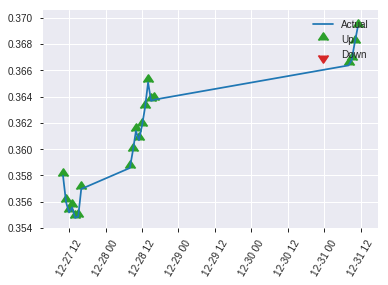


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2677946964203772
RMSE: 0.5174888370007388
LogLoss: 0.7305316774708493
Mean Per-Class Error: 0.4449677938808374
AUC: 0.5130434782608696
pr_auc: 0.5062872163781348
Gini: 0.026086956521739202
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46331238746643066: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    114  0.9913   (114.0/115.0)
1      0    108  0        (0.0/108.0)
Total  1    222  0.5112   (114.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.463312     0.654545  221
max f2                       0.463312     0.825688  221
max f0point5                 0.492111     0.545551  208
max accuracy                 0.634283     0.560538  71
max precision                0.686333     0.64      24
max recall                   0.463312     1         221
max specificity              0.785147     0.991304  0
max absolute_mcc             0.555328     0.126889  176
max min_per_class_accuracy   0.610388     0.537037  109
max mean_per_class_accuracy  0.634283     0.555032  71

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 60.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.739892           0         0                  0                0.758218  0                           0.758218            0               0                          -100      -100
    2        0.0224215                   0.722782           2.06481   0.825926           1                0.730322  0.4                         0.74706             0.0185185       0.0185185                  106.481   -17.4074
    3        0.0313901                   0.716133           1.03241   0.884921           0.5              0.718101  0.428571                    0.738786            0.00925926      0.0277778                  3.24074   -11.5079
    4        0.0403587                   0.714477           2.06481   1.14712            1                0.715819  0.555556                    0.733682            0.0185185       0.0462963                  106.481   14.7119
    5        0.0538117                   0.712672           0.688272  1.03241            0.333333         0.713805  0.5                         0.728713            0.00925926      0.0555556                  -31.1728  3.24074
    6        0.103139                    0.688114           1.50168   1.25684            0.727273         0.697626  0.608696                    0.713845            0.0740741       0.12963                    50.1684   25.6844
    7        0.152466                    0.66919            1.12626   1.2146             0.545455         0.677148  0.588235                    0.701972            0.0555556       0.185185                   12.6263   21.4597
    8        0.201794                    0.651608           0.563131  1.05535            0.272727         0.660054  0.511111                    0.691726            0.0277778       0.212963                   -43.6869  5.53498
    9        0.300448                    0.638498           1.22012   1.10945            0.590909         0.64529   0.537313                    0.676478            0.12037         0.333333                   22.0118   10.9453
    10       0.399103                    0.624357           1.12626   1.11361            0.545455         0.631299  0.539326                    0.66531             0.111111        0.444444                   12.6263   11.3608
    11       0.502242                    0.609793           0.897746  1.06928            0.434783         0.617743  0.517857                    0.655542            0.0925926       0.537037                   -10.2254  6.92791
    12       0.600897                    0.591629           0.563131  0.98618            0.272727         0.598607  0.477612                    0.646194            0.0555556       0.592593                   -43.6869  -1.38198
    13       0.699552                    0.576899           0.844697  0.966227           0.409091         0.58317   0.467949                    0.637306            0.0833333       0.675926                   -15.5303  -3.37726
    14       0.798206                    0.554263           0.750842  0.939607           0.363636         0.566505  0.455056                    0.628555            0.0740741       0.75                       -24.9158  -6.03933
    15       0.896861                    0.500811           1.40783   0.991111           0.681818         0.533139  0.48                        0.61806             0.138889        0.888889                   40.7828   -0.888889
    16       1                           0.442515           1.07729   1                  0.521739         0.48425   0.484305                    0.604259     

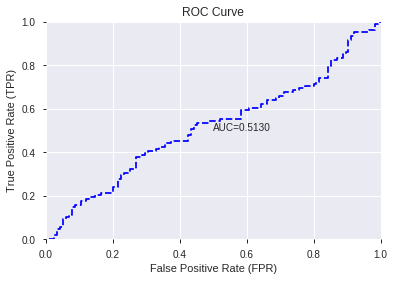

This function is available for GLM models only


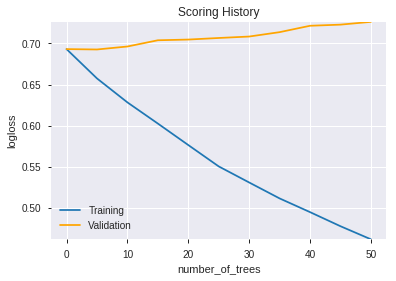

--2019-08-26 18:43:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190826_184254',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190826_184254',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_a50a',
   'type

['Volume',
 'HT_PHASOR_inphase',
 'STDDEV_12',
 'WILLR_8',
 'BOP',
 'SUB',
 'TRANGE',
 'STOCH_slowk',
 'AD',
 'MFI_8',
 'STDDEV_8',
 'CCI_8',
 'DIV',
 'BETA_24',
 'HT_PHASOR_quadrature',
 'HT_DCPERIOD',
 'ULTOSC',
 'BETA_8',
 'DX_12',
 'ADX_20',
 'BETA_20',
 'ADXR_14',
 'CCI_14',
 'aroonup_30',
 'ROC_20',
 'ADXR_8',
 'PLUS_DM_14',
 'BBANDS_upperband_14_0_5',
 'MACDEXT_hist',
 'PLUS_DM_8',
 'PLUS_DI_8',
 'BETA_12',
 'DX_20',
 'TRIX_8',
 'ADX_24',
 'MINUS_DI_8',
 'ADX_12',
 'MOM_14',
 'BBANDS_upperband_8_7_5',
 'ADXR_12',
 'MACDFIX_signal_20',
 'PLUS_DM_30',
 'STOCH_slowd',
 'hour',
 'DX_30',
 'STOCHF_fastk',
 'CCI_20',
 'DX_8',
 'STOCHRSI_fastd',
 'WILLR_12',
 'CORREL_30',
 'LINEARREG_ANGLE_8',
 'ATR_30',
 'BETA_30',
 'MOM_8',
 'WILLR_20',
 'STDDEV_24',
 'ADX_8',
 'CCI_24',
 'OBV',
 'weekday_name',
 'ATR_8',
 'AROONOSC_14',
 'CCI_12',
 'BBANDS_lowerband_8_4_5',
 'BETA_14',
 'MACDFIX_hist_8',
 'MFI_12',
 'MINUS_DM_30',
 'MACDFIX_hist_20',
 'CORREL_20',
 'CMO_8',
 'BBANDS_upperband_12_1_5

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

702

['BBANDS_lowerband_12_0_2',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_3',
 'BBANDS_lowerband_12_0_3',
 'BBANDS_upperband_12_0_4',
 'BBANDS_middleband_12_0_4',
 'BBANDS_lowerband_12_0_4',
 'BBANDS_upperband_12_0_5',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_0_5',
 'MA_12_1',
 'MAVP_12_1',
 'BBANDS_upperband_12_1_2',
 'BBANDS_middleband_12_1_2',
 'BBANDS_lowerband_12_1_2',
 'BBANDS_upperband_12_1_3',
 'BBANDS_middleband_12_1_3',
 'BBANDS_lowerband_12_1_3',
 'BBANDS_upperband_12_1_4',
 'BBANDS_middleband_12_1_4',
 'BBANDS_lowerband_12_1_4',
 'BBANDS_upperband_12_1_5',
 'BBANDS_middleband_12_1_5',
 'BBANDS_lowerband_12_1_5',
 'MA_12_2',
 'MAVP_12_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_middleband_12_2_2',
 'BBANDS_lowerband_12_2_2',
 'BBANDS_upperband_12_2_3',
 'BBANDS_middleband_12_2_3',
 'BBANDS_lowerband_12_2_3',
 'BBANDS_upperband_12_2_4',
 'BBANDS_middleband_12_2_4',
 'BBANDS_lowerband_12_2_4',
 'BBANDS_upperband_12_2_5',
 'BBANDS_middleband_12_2_5',
 'BBANDS_lowe

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_184450_model_6  0.500000  0.692683              0.500000  0.499768  0.249768
1  DeepLearning_grid_1_AutoML_20190826_184450_model_8  0.500000  0.692776              0.500000  0.499814  0.249814
2  DeepLearning_grid_1_AutoML_20190826_184450_model_5  0.500000  0.693159              0.500000  0.500005  0.250005
3               DeepLearning_1_AutoML_20190826_184450  0.500000  0.692769              0.500000  0.499811  0.249811
4  DeepLearning_grid_1_AutoML_20190826_184450_model_1  0.491828  7.970496              0.491304  0.718078  0.515636
5  DeepLearning_grid_1_AutoML_20190826_184450_model_7  0.482327  0.701212              0.500000  0.503992  0.254008
6  DeepLearning_grid_1_AutoML_20190826_184450_model_4  0.481965  0.842965              0.500000  0.550326  0.302858
7  DeepLearning_grid_1_AutoML_20190826_184450_model_2  0.477697  0.807650              0.500000  0.540312  0.291937
8  DeepLearning_grid_1_AutoML_20190826_184450_model_3  0.435668  0.778858              0.500000  0.537210  0.288595
9  DeepLearning_grid_1_AutoML_20190826_184450_model_9  0.408696  0.698254              0.500000  0.502520  0.252526

variable  relative_importance  scaled_importance  percentage
0                   BOP             1.000000           1.000000    0.002163
1        STOCHRSI_fastk             0.988324           0.988324    0.002138
2        STOCHRSI_fastd             0.948802           0.948802    0.002052
3          HT_TRENDMODE             0.937898           0.937898    0.002029
4             CORREL_24             0.937750           0.937750    0.002028
..                  ...                  ...                ...         ...
696        CDLTASUKIGAP             0.529000           0.529000    0.001144
697  CDLSEPARATINGLINES             0.526953           0.526953    0.001140
698          CDL3INSIDE             0.523820           0.523820    0.001133
699         CDL3OUTSIDE             0.522194           0.522194    0.001130
700      CDLHARAMICROSS             0.510671           0.510671    0.001105

[701 rows x 4 columns]

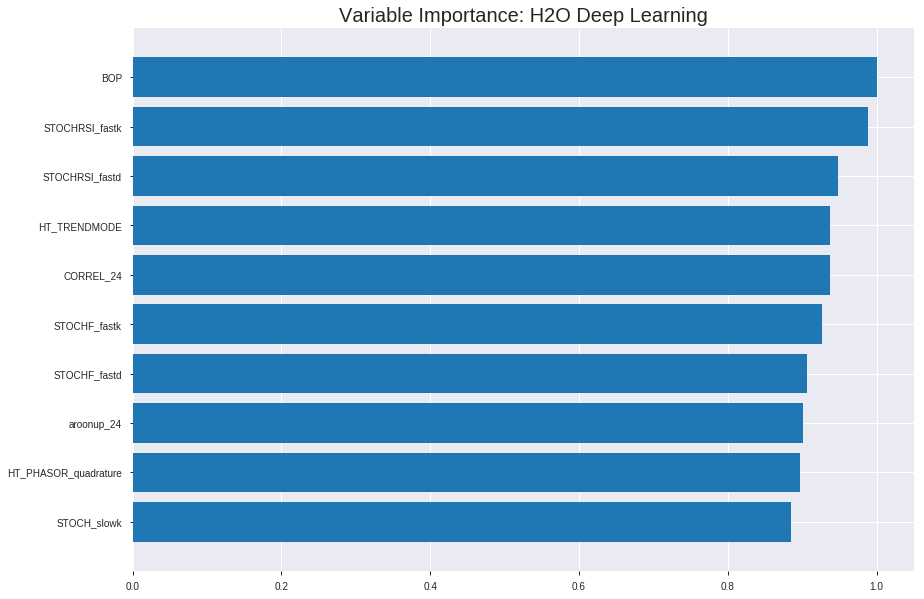

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_184450_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.237793777340856
RMSE: 0.4876410332825325
LogLoss: 0.6659834778700711
Mean Per-Class Error: 0.43516076798519543
AUC: 0.5996802815505106
pr_auc: 0.6386965470156123
Gini: 0.19936056310102113
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44483251013124236: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      60   726   0.9237   (726.0/786.0)
1      13   757   0.0169   (13.0/770.0)
Total  73   1483  0.4749   (739.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444833     0.671993  329
max f2                       0.331363     0.833695  369
max f0point5                 0.481242     0.570609  259
max accuracy                 0.488436     0.568123  211
max precision                0.968574     1         0
max recall                   0.24988      1         386
max specificity              0.968574     1         0
max absolute_mcc             0.54478      0.218339  109
max min_per_class_accuracy   0.488073     0.344784  212
max mean_per_class_accuracy  0.488436     0.564839  211

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.857742           2.02078   2.02078            1                0.918179  1                           0.918179            0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.774783           1.64188   1.83133            0.8125           0.8125    0.90625                     0.865339            0.0168831       0.0376623                  64.1883   83.1331
    3        0.0302057                   0.703687           1.88606   1.8488             0.933333         0.744774  0.914894                    0.826861            0.0181818       0.0558442                  88.6061   84.8798
    4        0.0404884                   0.639094           1.76818   1.82832            0.875            0.668945  0.904762                    0.786755            0.0181818       0.074026                   76.8182   82.8324
    5        0.0501285                   0.595455           1.75134   1.81352            0.866667         0.612566  0.897436                    0.753257            0.0168831       0.0909091                  75.1342   81.352
    6        0.100257                    0.512879           1.29537   1.55445            0.641026         0.545     0.769231                    0.649129            0.0649351       0.155844                   29.5371   55.4446
    7        0.150386                    0.495741           1.08811   1.399              0.538462         0.502305  0.692308                    0.600188            0.0545455       0.21039                    8.81119   39.9001
    8        0.701157                    0.488073           0.980915  1.07059            0.485414         0.488283  0.529789                    0.512285            0.54026         0.750649                   -1.9085   7.0587
    9        0.800129                    0.486542           0.984146  1.05989            0.487013         0.487346  0.524498                    0.5092              0.0974026       0.848052                   -1.58543  5.98946
    10       0.899743                    0.477984           0.925647  1.04503            0.458065         0.484161  0.517143                    0.506428            0.0922078       0.94026                    -7.43527  4.50315
    11       1                           0.00709835         0.595871  1                  0.294872         0.404051  0.494859                    0.496164            0.0597403       1                          -40.4129  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2494188254723829
RMSE: 0.4994184873153805
LogLoss: 0.6919844093816736
Mean Per-Class Error: 0.48306543039922256
AUC: 0.5051218722163737
pr_auc: 0.5755917357698305
Gini: 0.010243744432747448
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.479563131922545: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    229  0.9828   (229.0/233.0)
1      0    212  0        (0.0/212.0)
Total  4    441  0.5146   (229.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479563     0.649311  82
max f2                       0.479563     0.822343  82
max f0point5                 0.485545     0.53681   77
max accuracy                 0.492464     0.539326  10
max precision                0.492464     0.818182  10
max recall                   0.479563     1         82
max specificity              0.509016     0.995708  0
max absolute_mcc             0.492464     0.108945  10
max min_per_class_accuracy   0.488073     0.154506  14
max mean_per_class_accuracy  0.492464     0.516935  10

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 48.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.496036           1.25943   1.25943            0.6              0.504352  0.6                         0.504352            0.0141509       0.0141509                  25.9434   25.9434
    2        0.0202247                   0.493051           2.09906   1.6326             1                0.493802  0.777778                    0.499663            0.0188679       0.0330189                  109.906   63.26
    3        0.0314607                   0.488379           1.25943   1.49933            0.6              0.491412  0.714286                    0.496716            0.0141509       0.0471698                  25.9434   49.9326
    4        0.838202                    0.488073           0.970594  0.99044            0.462396         0.488073  0.47185                     0.488398            0.783019        0.830189                   -2.94056  -0.956042
    5        0.898876                    0.487136           0.855171  0.981309           0.407407         0.487646  0.4675                      0.488347            0.0518868       0.882075                   -14.4829  -1.8691
    6        1                           0.47121            1.16614   1                  0.555556         0.485173  0.476404                    0.488026            0.117925        1                          16.6143   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 18:55:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 18:55:07  5 min 20.539 sec  389 obs/sec       0.531491  1             827        0.677321         3.18397             -0.835249      0.527303        0.498802           1.51558          0.505141                         0.720634           4.94644               -1.08189         0.508027          0.508647             1.67925            0.521348
    2019-08-26 18:55:29  5 min 41.750 sec  556 obs/sec       7.63432   14            11879      0.503649         0.700687            -0.014758      0.534743        0.527688           1.51558          0.498715                         0.536745           0.776545              -0.154952        0.496518          0.49698              1.67925            0.507865
    2019-08-26 18:55:49  6 min  2.517 sec  613 obs/sec       15.8123   29            24604      0.498534         0.690081            0.00575043     0.538841        0.547245           1.64188          0.492931                         0.502039           0.697345              -0.0104238       0.491092          0.473129             1.25943            0.523596
    2019-08-26 18:56:10  6 min 23.182 sec  648 obs/sec       24.5238   45            38159      0.495878         0.684553            0.0163157      0.570181        0.581835           1.89448          0.49036                          0.500356           0.693859              -0.00365972      0.501539          0.497446             1.67925            0.521348
    2019-08-26 18:56:31  6 min 43.708 sec  669 obs/sec       33.2841   61            51790      0.493992         0.680016            0.023785       0.592244        0.596295           1.89448          0.476221                         0.499578           0.692305              -0.000540796     0.483723          0.474626             1.25943            0.521348
    2019-08-26 18:56:51  7 min  3.932 sec  693 obs/sec       42.5668   78            66234      0.489193         0.669433            0.0426613      0.603669        0.623329           1.89448          0.48072                          0.500382           0.693911              -0.00376285      0.516125          0.488228             1.25943            0.519101
    2019-08-26 18:57:11  7 min 23.952 sec  710 obs/sec       51.8747   95            80717      0.487641         0.665983            0.0487243      0.59968         0.638697           2.02078          0.474936                         0.499418           0.691984              9.79246e-05      0.505122          0.575592             1.25943            0.514607
    2019-08-26 18:57:32  7 min 44.871 sec  724 obs/sec       61.741    113           96069      0.486213         0.662758            0.0542877      0.616038        0.642043           2.02078          0.470437                         0.500279           0.693699              -0.00335244      0.482448          0.469608             1.25943            0.519101
    2019-08-26 18:57:34

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  ---------------------
BOP                 1.0                    1.0                  0.002163001039886138
STOCHRSI_fastk      0.9883241057395935     0.9883241057395935   0.002137746068459278
STOCHRSI_fastd      0.9488015174865723     0.9488015174865723   0.0020522586689690017
HT_TRENDMODE        0.9378975629806519     0.9378975629806519   0.0020286734040338246
CORREL_24           0.9377501606941223     0.9377501606941223   0.0020283545727347793
---                 ---                    ---                  ---
CDLTASUKIGAP        0.5290003418922424     0.5290003418922424   0.001144228289613043
CDLSEPARATINGLINES  0.5269531607627869     0.5269531607627869   0.0011398002347011952
CDL3INSIDE          0.5238198637962341     0.5238198637962341   0.0011330229101042695
CDL3OUTSIDE         0.5221940875053406     0.5221940875053406   0.0011295063542964446
CDLHARAMICROSS      0.5106713771820068     0.5106713771820068   0.001104582719884767


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.484304932735426)

('F1', 0.6525679758308157)

('auc', 0.5)

('logloss', 0.692682852868156)

('mean_per_class_error', 0.5)

('rmse', 0.49976781278907273)

('mse', 0.24976786669997367)

deeplearning prediction progress: |███████████████████████████████████████| 100%


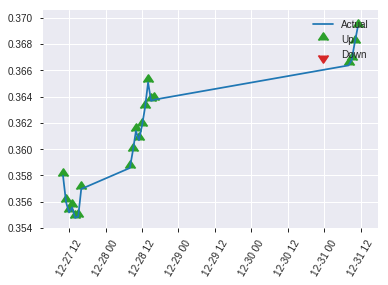


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24976786669997367
RMSE: 0.49976781278907273
LogLoss: 0.692682852868156
Mean Per-Class Error: 0.5
AUC: 0.5
pr_auc: 0.0
Gini: 0.0
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48807346513067174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    108  0        (0.0/108.0)
Total  0    223  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488073     0.652568  0
max f2                       0.488073     0.824427  0
max f0point5                 0.488073     0.54      0
max accuracy                 0.488073     0.484305  0
max precision                0.488073     0.484305  0
max recall                   0.488073     1         0
max specificity              0.488073     0         0
max absolute_mcc             0.488073     0         0
max min_per_class_accuracy   0.488073     0         0
max mean_per_class_accuracy  0.488073     0.5       0

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 48.81 %



group    cumulative_data_fraction    lower_threshold    lift    cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain    cumulative_gain
--  -------  --------------------------  -----------------  ------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ------  -----------------
    1        1                           0.488073           1       1                  0.484305         0.488073  0.484305                    0.488073            1               1                          0       0

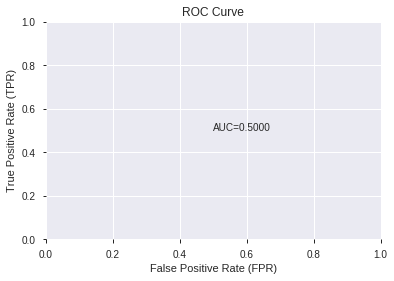

This function is available for GLM models only


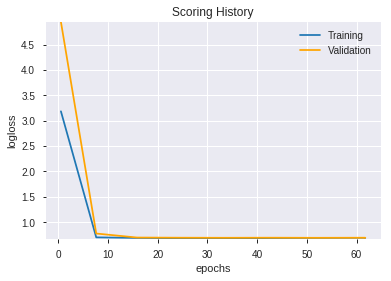

--2019-08-26 19:09:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.95.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.95.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_184450_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_184450_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'HT_TRENDMODE',
 'CORREL_24',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'aroonup_24',
 'HT_PHASOR_quadrature',
 'STOCH_slowk',
 'aroonup_8',
 'aroondown_8',
 'HT_PHASOR_inphase',
 'aroonup_30',
 'CDLLONGLEGGEDDOJI',
 'aroondown_20',
 'AD',
 'BETA_14',
 'CCI_8',
 'HT_DCPERIOD',
 'OBV',
 'TRANGE',
 'STOCH_slowd',
 'CORREL_20',
 'AROONOSC_24',
 'aroondown_14',
 'STDDEV_8',
 'BETA_12',
 'DX_12',
 'MFI_24',
 'ADXR_8',
 'aroondown_30',
 'BETA_30',
 'AROONOSC_20',
 'AROONOSC_8',
 'CDLDOJI',
 'DX_8',
 'DX_14',
 'LINEARREG_ANGLE_8',
 'MFI_8',
 'aroondown_12',
 'WILLR_8',
 'aroondown_24',
 'CORREL_14',
 'MACDEXT_signal',
 'aroonup_12',
 'aroonup_20',
 'AROONOSC_14',
 'aroonup_14',
 'DX_30',
 'DX_20',
 'NATR_30',
 'CORREL_12',
 'BETA_8',
 'STDDEV_20',
 'WILLR_12',
 'ADX_8',
 'PLUS_DM_24',
 'ADX_20',
 'LINEARREG_SLOPE_8',
 'VAR_8',
 'DX_24',
 'CDLRICKSHAWMAN',
 'BETA_24',
 'ADX_12',
 'ADXR_14',
 'ADXR_12',
 'AROONOSC_12',
 'CCI_14',
 'PLUS_DM_30',
 'CORREL_8

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_190915_model_1  0.550081  0.713739              0.470129  0.510035  0.260135

variable  relative_importance  scaled_importance  percentage
0         CDLIDENTICAL3CROWS             0.021059           1.000000    0.020220
1          CDLSTALLEDPATTERN             0.020174           0.957991    0.019371
2                  CDLHAMMER             0.017833           0.846809    0.017123
3                 CDLHIKKAKE             0.017593           0.835442    0.016893
4                CDLPIERCING             0.015475           0.734861    0.014859
..                       ...                  ...                ...         ...
696  BBANDS_lowerband_12_4_3             0.000006           0.000296    0.000006
697                  MA_12_7             0.000005           0.000226    0.000005
698                  MA_30_7             0.000005           0.000224    0.000005
699  BBANDS_lowerband_12_3_2             0.000003           0.000141    0.000003
700                MAVP_30_7             0.000002           0.000078    0.000002

[701 rows x 4 columns]

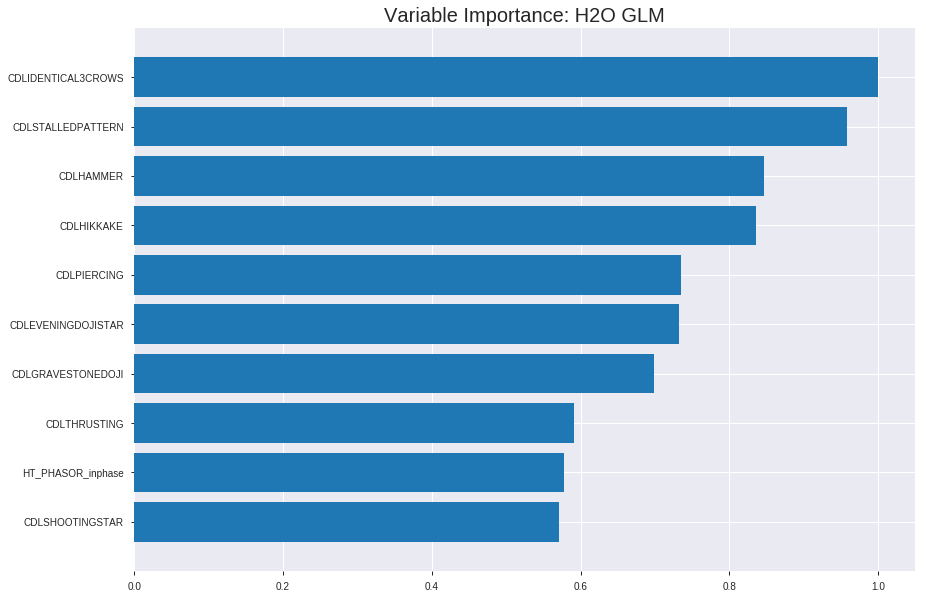

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_190915_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24534188757136624
RMSE: 0.49531998503125857
LogLoss: 0.6837821606587882
Null degrees of freedom: 1555
Residual degrees of freedom: 854
Null deviance: 2156.909498581488
Residual deviance: 2127.9300839701486
AIC: 3531.9300839701486
AUC: 0.5980469911767622
pr_auc: 0.5979082008620137
Gini: 0.19609398235352438
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4252770137389256: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      22   764   0.972    (764.0/786.0)
1      3    767   0.0039   (3.0/770.0)
Total  25   1531  0.4929   (767.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425277     0.666667  382
max f2                       0.413233     0.832073  391
max f0point5                 0.497186     0.568939  190
max accuracy                 0.508938     0.580334  142
max precision                0.614404     1         0
max recall                   0.413233     1         391
max specificity              0.614404     1         0
max absolute_mcc             0.518697     0.166774  107
max min_per_class_accuracy   0.497374     0.569975  189
max mean_per_class_accuracy  0.508783     0.578684  143

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102828                   0.569862           1.76818   1.76818            0.875            0.586212  0.875                       0.586212            0.0181818       0.0181818                  76.8182    76.8182
    2        0.0205656                   0.558809           1.13669   1.45244            0.5625           0.563911  0.71875                     0.575061            0.0116883       0.0298701                  13.6688    45.2435
    3        0.0302057                   0.547793           1.61662   1.50484            0.8              0.551255  0.744681                    0.567464            0.0155844       0.0454545                  61.6623    50.4836
    4        0.0404884                   0.544313           1.26299   1.44341            0.625            0.545973  0.714286                    0.562006            0.012987        0.0584416                  26.2987    44.3414
    5        0.0501285                   0.541656           1.61662   1.47672            0.8              0.542873  0.730769                    0.558326            0.0155844       0.074026                   61.6623    47.6723
    6        0.100257                    0.530677           1.21765   1.34719            0.602564         0.534871  0.666667                    0.546599            0.061039        0.135065                   21.7649    34.7186
    7        0.150386                    0.525066           1.399     1.36446            0.692308         0.527657  0.675214                    0.540285            0.0701299       0.205195                   39.9001    36.4458
    8        0.200514                    0.519614           1.24356   1.33423            0.615385         0.52219   0.660256                    0.535761            0.0623377       0.267532                   24.3556    33.4232
    9        0.300129                    0.511191           1.08209   1.25055            0.535484         0.515211  0.618844                    0.528941            0.107792        0.375325                   8.20947    25.0546
    10       0.400386                    0.504333           0.971528  1.18068            0.480769         0.507883  0.58427                     0.523668            0.0974026       0.472727                   -2.84715   18.068
    11       0.5                         0.497305           0.990834  1.14286            0.490323         0.500735  0.565553                    0.519099            0.0987013       0.571429                   -0.916632  14.2857
    12       0.600257                    0.489528           0.816084  1.08828            0.403846         0.493216  0.538544                    0.514776            0.0818182       0.653247                   -18.3916   8.82783
    13       0.699871                    0.481317           0.899573  1.06142            0.445161         0.485383  0.525253                    0.510592            0.0896104       0.742857                   -10.0427   6.14194
    14       0.800129                    0.469756           0.958575  1.04853            0.474359         0.475246  0.518876                    0.506163            0.0961039       0.838961                   -4.14252   4.85328
    15       0.899743                    0.454278           0.938685  1.03637            0.464516         0.461946  0.512857                    0.501268            0.0935065       0.932468                   -6.13155   3.63711
    16       1                           0.376722           0.673593  1                  0.333333         0.43734   0.494859                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2535898545285714
RMSE: 0.5035770591762212
LogLoss: 0.7003819262011285
Null degrees of freedom: 444
Residual degrees of freedom: -257
Null deviance: 616.5161536496719
Residual deviance: 623.3399143190044
AIC: 2027.3399143190045
AUC: 0.5223196210219451
pr_auc: 0.4957927589864943
Gini: 0.04463924204389014
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45569277669447034: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    233  1        (233.0/233.0)
1      0    212  0        (0.0/212.0)
Total  0    445  0.5236   (233.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.455693     0.645358   399
max f2                       0.455693     0.819799   399
max f0point5                 0.505966     0.537257   364
max accuracy                 0.569733     0.546067   76
max precision                0.581326     0.6        34
max recall                   0.455693     1          399
max specificity              0.614032     0.995708   0
max absolute_mcc             0.569733     0.0807036  76
max min_per_class_accuracy   0.542616     0.515021   195
max mean_per_class_accuracy  0.569733     0.531025   76

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 54.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.603705           0.419811  0.419811           0.2              0.608397  0.2                         0.608397            0.00471698      0.00471698                 -58.0189  -58.0189
    2        0.0202247                   0.597037           1.57429   0.932914           0.75             0.599807  0.444444                    0.604579            0.0141509       0.0188679                  57.4292   -6.7086
    3        0.0314607                   0.592177           0.839623  0.899596           0.4              0.593891  0.428571                    0.600762            0.00943396      0.0283019                  -16.0377  -10.0404
    4        0.0404494                   0.589141           2.09906   1.16614            1                0.590383  0.555556                    0.598456            0.0188679       0.0471698                  109.906   16.6143
    5        0.0516854                   0.585329           0.839623  1.09516            0.4              0.587073  0.521739                    0.595981            0.00943396      0.0566038                  -16.0377  9.516
    6        0.101124                    0.577278           1.33576   1.21279            0.636364         0.581118  0.577778                    0.588715            0.0660377       0.122642                   33.5763   21.2788
    7        0.150562                    0.571709           0.954117  1.12785            0.454545         0.574094  0.537313                    0.583914            0.0471698       0.169811                   -4.58834  12.7851
    8        0.2                         0.567914           1.04953   1.10849            0.5              0.570111  0.52809                     0.580502            0.0518868       0.221698                   4.95283   10.8491
    9        0.301124                    0.560337           0.97956   1.06519            0.466667         0.564176  0.507463                    0.575019            0.0990566       0.320755                   -2.04403  6.51929
    10       0.4                         0.551664           0.954117  1.03774            0.454545         0.555913  0.494382                    0.570296            0.0943396       0.415094                   -4.58834  3.77358
    11       0.501124                    0.542614           1.02621   1.03541            0.488889         0.547179  0.493274                    0.565631            0.103774        0.518868                   2.62055   3.54091
    12       0.6                         0.535291           0.810999  0.998428           0.386364         0.538697  0.475655                    0.561193            0.0801887       0.599057                   -18.9001  -0.157233
    13       0.698876                    0.526632           1.19265   1.02591            0.568182         0.53068   0.488746                    0.556876            0.117925        0.716981                   19.2646   2.59055
    14       0.8                         0.518074           0.886268  1.00825            0.422222         0.522667  0.480337                    0.552552            0.0896226       0.806604                   -11.3732  0.825472
    15       0.898876                    0.508094           1.04953   1.01279            0.5              0.513335  0.4825                      0.548238            0.103774        0.910377                   4.95283   1.27948
    16       1                           0.455693           0.886268  1                  0.422222         0.496512  0.476404                    0.543007      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 19:09:16  0.000 sec   2            3.1       702           1.37631           1.40117
    2019-08-26 19:09:17  0.938 sec   4            2.2       702           1.37389           1.40099
    2019-08-26 19:09:18  1.853 sec   6            1.6       702           1.37099           1.40082
    2019-08-26 19:09:19  2.757 sec   8            1.2       702           1.36756           1.40076
    2019-08-26 19:09:20  3.694 sec   10           0.86      702           1.36363           1.40076
    2019-08-26 19:09:21  4.637 sec   12           0.63      702           1.35924           1.40102
    2019-08-26 19:09:22  5.563 sec   14           0.46      702           1.3545            1.40165
    2019-08-26 19:09:23  6.468 sec   16           0.33      702           1.3495            1.40274
    2019-08-26 19:09:24  7.368 sec   18           0.24      702           1.34437           1.40445

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.6625000000000001)

('auc', 0.5500805152979066)

('logloss', 0.7137392256644621)

('mean_per_class_error', 0.4296698872785829)

('rmse', 0.5100345988154811)

('mse', 0.2601352919888687)

glm prediction progress: |████████████████████████████████████████████████| 100%


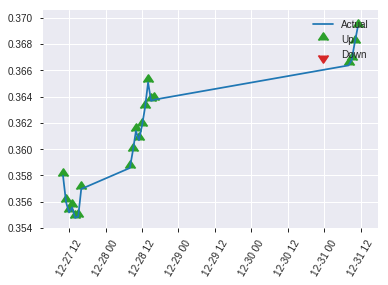


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2601352919888687
RMSE: 0.5100345988154811
LogLoss: 0.7137392256644621
Null degrees of freedom: 222
Residual degrees of freedom: -479
Null deviance: 309.02325884747086
Residual deviance: 318.3276946463501
AIC: 1722.3276946463502
AUC: 0.5500805152979066
pr_auc: 0.5303025419269672
Gini: 0.10016103059581316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5507437003825204: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    106  0.9217   (106.0/115.0)
1      2    106  0.0185   (2.0/108.0)
Total  11   212  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.550744     0.6625    211
max f2                       0.454857     0.824427  222
max f0point5                 0.550744     0.554393  211
max accuracy                 0.600952     0.573991  84
max precision                0.699446     1         0
max recall                   0.454857     1         222
max specificity              0.699446     1         0
max absolute_mcc             0.600952     0.144738  84
max min_per_class_accuracy   0.59543      0.518519  106
max mean_per_class_accuracy  0.600952     0.57033   84

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 59.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.656536           1.37654   1.37654            0.666667         0.673584  0.666667                    0.673584            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.64952            2.06481   1.65185            1                0.652224  0.8                         0.66504             0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.646476           1.03241   1.47487            0.5              0.647346  0.714286                    0.659985            0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.640905           1.03241   1.37654            0.5              0.644544  0.666667                    0.656553            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.637202           0.688272  1.20448            0.333333         0.639131  0.583333                    0.652198            0.00925926      0.0648148                  -31.1728  20.4475
    6        0.103139                    0.627587           1.31397   1.25684            0.636364         0.630644  0.608696                    0.64189             0.0648148       0.12963                    31.3973   25.6844
    7        0.152466                    0.617297           0.750842  1.09314            0.363636         0.622084  0.529412                    0.635482            0.037037        0.166667                   -24.9158  9.31373
    8        0.201794                    0.612507           0.750842  1.00947            0.363636         0.614927  0.488889                    0.630457            0.037037        0.203704                   -24.9158  0.946502
    9        0.300448                    0.605468           1.50168   1.17109            0.727273         0.608901  0.567164                    0.623379            0.148148        0.351852                   50.1684   17.1089
    10       0.399103                    0.599883           1.03241   1.13681            0.5              0.602583  0.550562                    0.618238            0.101852        0.453704                   3.24074   13.6808
    11       0.502242                    0.5944             0.628422  1.03241            0.304348         0.596911  0.5                         0.613859            0.0648148       0.518519                   -37.1578  3.24074
    12       0.600897                    0.589178           1.22012   1.06323            0.590909         0.591952  0.514925                    0.610262            0.12037         0.638889                   22.0118   6.32255
    13       0.699552                    0.580868           0.938552  1.04564            0.454545         0.585063  0.50641                     0.606708            0.0925926       0.731481                   -6.14478  4.56434
    14       0.798206                    0.572283           0.563131  0.986007           0.272727         0.576694  0.477528                    0.602999            0.0555556       0.787037                   -43.6869  -1.39929
    15       0.896861                    0.558778           1.31397   1.02208            0.636364         0.565496  0.495                       0.598873            0.12963         0.916667                   31.3973   2.20833
    16       1                           0.454857           0.807971  1                  0.391304         0.543369  0.484305                    0.593149       

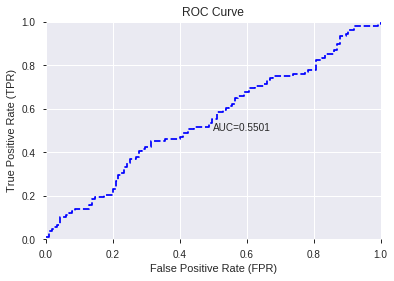

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


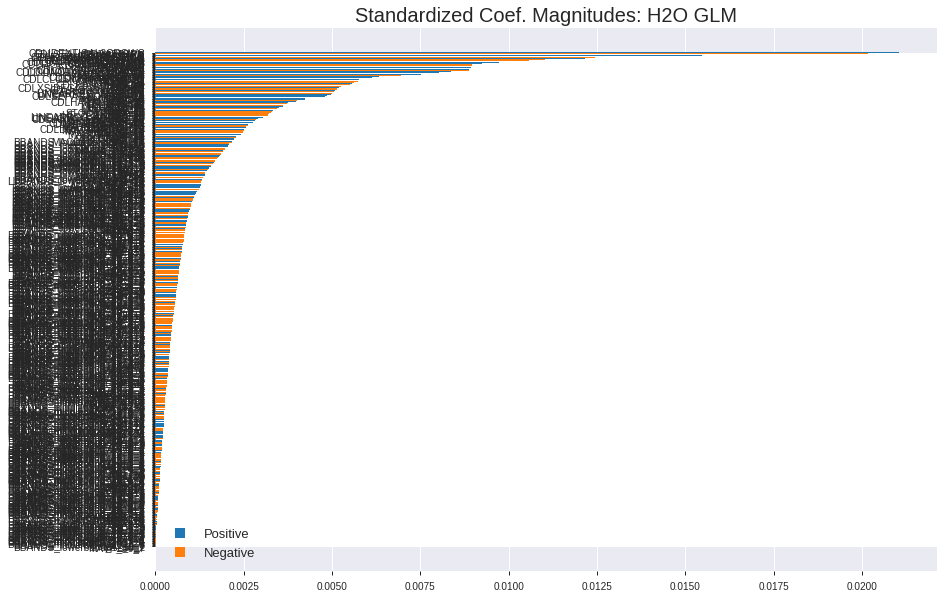

'log_likelihood'
--2019-08-26 19:09:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_190915_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_190915_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLIDENTICAL3CROWS',
 'CDLSTALLEDPATTERN',
 'CDLHAMMER',
 'CDLHIKKAKE',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLGRAVESTONEDOJI',
 'CDLTHRUSTING',
 'HT_PHASOR_inphase',
 'CDLSHOOTINGSTAR',
 'CDLENGULFING',
 'HT_PHASOR_quadrature',
 'CDLDARKCLOUDCOVER',
 'DX_8',
 'CDLSHORTLINE',
 'CDLRISEFALL3METHODS',
 'CDLTASUKIGAP',
 'aroonup_8',
 'STOCHF_fastd',
 'TRANGE',
 'CDLHARAMI',
 'CDL2CROWS',
 'DX_14',
 'STOCH_slowk',
 'CDL3WHITESOLDIERS',
 'DX_12',
 'CDLMORNINGDOJISTAR',
 'CDLCONCEALBABYSWALL',
 'ADX_24',
 'CDLHIGHWAVE',
 'STOCH_slowd',
 'VAR_14',
 'DX_20',
 'aroondown_8',
 'CDLMATCHINGLOW',
 'CDLHIKKAKEMOD',
 'CDLCLOSINGMARUBOZU',
 'ROCR_24',
 'CDLBELTHOLD',
 'ROCP_24',
 'ROCR100_24',
 'ROC_24',
 'MFI_24',
 'MOM_24',
 'MFI_8',
 'CDLHANGINGMAN',
 'DX_24',
 'STDDEV_8',
 'MFI_30',
 'CDLXSIDEGAP3METHODS',
 'AD',
 'aroondown_12',
 'CDLMORNINGSTAR',
 'ADX_20',
 'ADXR_14',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'CCI_8',
 'ADOSC',
 'MFI_14',
 'CDLSEPARATINGLINES',
 'CORREL_24',
 'CCI_30

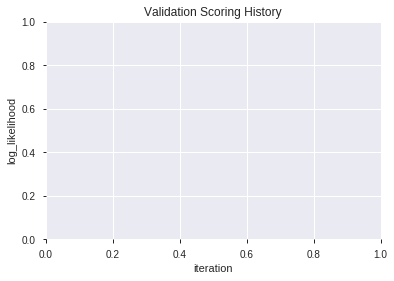

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_190944_model_6  0.491224  0.820480              0.500000  0.553664  0.306544
1  XGBoost_grid_1_AutoML_20190826_190944_model_5  0.478261  0.916448              0.491304  0.579874  0.336254
2               XGBoost_1_AutoML_20190826_190944  0.472947  0.757196              0.500000  0.529029  0.279871
3  XGBoost_grid_1_AutoML_20190826_190944_model_2  0.467391  0.715902              0.500000  0.511002  0.261123
4               XGBoost_3_AutoML_20190826_190944  0.464734  0.805647              0.500000  0.548095  0.300408
5  XGBoost_grid_1_AutoML_20190826_190944_model_1  0.458132  0.904603              0.500000  0.581313  0.337925
6               XGBoost_2_AutoML_20190826_190944  0.448873  0.739560              0.500000  0.521754  0.272227
7  XGBoost_grid_1_AutoML_20190826_190944_model_3  0.440902  0.812943              0.500000  0.550262  0.302788
8  XGBoost_grid_1_AutoML_20190826_190944_model_7  0.438406  0.815705              0.500000  0.551809  0.304494
9  XGBoost_grid_1_AutoML_20190826_190944_model_4  0.421498  0.719138              0.491304  0.512650  0.262810

variable  relative_importance  scaled_importance  percentage
0                     TRANGE           156.030930           1.000000    0.024245
1                    ADXR_12           126.394020           0.810057    0.019640
2                  STDDEV_12           113.608536           0.728115    0.017653
3                        BOP           105.933464           0.678926    0.016461
4                    WILLR_8            99.042686           0.634763    0.015390
..                       ...                  ...                ...         ...
302  BBANDS_lowerband_30_1_5             2.098266           0.013448    0.000326
303  BBANDS_upperband_12_5_4             1.614142           0.010345    0.000251
304  BBANDS_upperband_12_2_5             1.235905           0.007921    0.000192
305  BBANDS_upperband_12_1_2             1.087853           0.006972    0.000169
306  BBANDS_lowerband_12_0_5             0.929408           0.005957    0.000144

[307 rows x 4 columns]

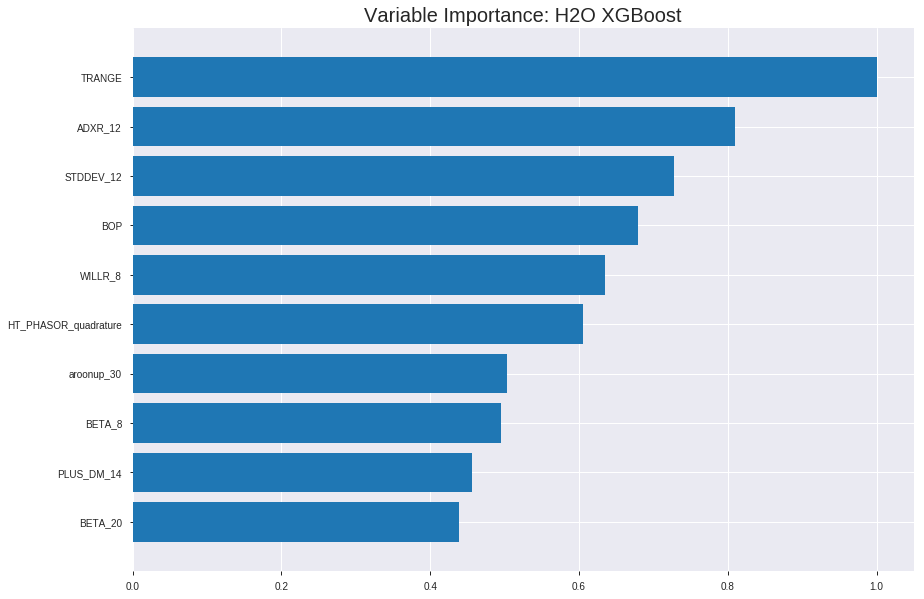

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_190944_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17824105974284427
RMSE: 0.42218604873070387
LogLoss: 0.5455570408542388
Mean Per-Class Error: 0.12405571527708936
AUC: 0.9489483163147285
pr_auc: 0.9461664547199697
Gini: 0.8978966326294571
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4915732741355896: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      670  116  0.1476   (116.0/786.0)
1      78   692  0.1013   (78.0/770.0)
Total  748  808  0.1247   (194.0/1556.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491573     0.87706   201
max f2                       0.450642     0.919794  241
max f0point5                 0.520877     0.895415  172
max accuracy                 0.501443     0.875964  192
max precision                0.764462     1         0
max recall                   0.374961     1         311
max specificity              0.764462     1         0
max absolute_mcc             0.501443     0.751899  192
max min_per_class_accuracy   0.50041      0.874046  193
max mean_per_class_accuracy  0.501443     0.875944  192

Gains/Lift Table: Avg response rate: 49.49 %, avg score: 49.55 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102828                   0.727139           2.02078    2.02078            1                0.74073   1                           0.74073             0.0207792       0.0207792                  102.078   102.078
    2        0.0205656                   0.704358           2.02078    2.02078            1                0.712954  1                           0.726842            0.0207792       0.0415584                  102.078   102.078
    3        0.0302057                   0.687631           2.02078    2.02078            1                0.693997  1                           0.716359            0.0194805       0.061039                   102.078   102.078
    4        0.0404884                   0.671283           2.02078    2.02078            1                0.681078  1                           0.707399            0.0207792       0.0818182                  102.078   102.078
    5        0.0501285                   0.663492           2.02078    2.02078            1                0.667104  1                           0.69965             0.0194805       0.101299                   102.078   102.078
    6        0.100257                    0.637185           1.96896    1.99487            0.974359         0.649636  0.987179                    0.674643            0.0987013       0.2                        96.8964   99.4872
    7        0.150386                    0.621112           1.99487    1.99487            0.987179         0.628245  0.987179                    0.659177            0.1             0.3                        99.4872   99.4872
    8        0.200514                    0.60248            1.99487    1.99487            0.987179         0.611586  0.987179                    0.647279            0.1             0.4                        99.4872   99.4872
    9        0.300129                    0.563755           1.85129    1.94722            0.916129         0.582554  0.963597                    0.625796            0.184416        0.584416                   85.1295   94.7218
    10       0.400386                    0.53361            1.72284    1.89103            0.852564         0.548651  0.935795                    0.606479            0.172727        0.757143                   72.2844   89.1034
    11       0.5                         0.49894            1.21247    1.75584            0.6              0.516146  0.868895                    0.588482            0.120779        0.877922                   21.2468   75.5844
    12       0.600257                    0.463399           0.6995     1.57941            0.346154         0.48032   0.781585                    0.570417            0.0701299       0.948052                   -30.05    57.941
    13       0.699871                    0.431123           0.365044   1.40657            0.180645         0.446646  0.696051                    0.5528              0.0363636       0.984416                   -63.4956  40.6566
    14       0.800129                    0.389187           0.10363    1.24331            0.0512821        0.410231  0.615261                    0.534936            0.0103896       0.994805                   -89.637   24.3307
    15       0.899743                    0.346768           0.0521491  1.11143            0.0258065        0.371172  0.55                        0.516805            0.00519481      1                          -94.7851  11.1429
    16       1                           0.188039           0          1                  0                0.304029  0.494859                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2847610344171731
RMSE: 0.5336300538923694
LogLoss: 0.7697955834721982
Mean Per-Class Error: 0.45546198072718436
AUC: 0.5032492509514941
pr_auc: 0.4987996418276438
Gini: 0.006498501902988174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39644455909729004: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   223  0.9571   (223.0/233.0)
1      3    209  0.0142   (3.0/212.0)
Total  13   432  0.5079   (226.0/445.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.396445     0.649068  386
max f2                       0.326586     0.821069  397
max f0point5                 0.396445     0.53866   386
max accuracy                 0.729712     0.559551  74
max precision                0.849956     1         0
max recall                   0.326586     1         397
max specificity              0.849956     1         0
max absolute_mcc             0.729712     0.115855  74
max min_per_class_accuracy   0.660962     0.497854  193
max mean_per_class_accuracy  0.729712     0.544538  74

Gains/Lift Table: Avg response rate: 47.64 %, avg score: 62.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011236                    0.821957           1.25943   1.25943            0.6              0.837069  0.6                         0.837069            0.0141509       0.0141509                  25.9434   25.9434
    2        0.0202247                   0.79389            1.04953   1.16614            0.5              0.807617  0.555556                    0.823979            0.00943396      0.0235849                  4.95283   16.6143
    3        0.0314607                   0.786798           1.67925   1.34939            0.8              0.790679  0.642857                    0.812086            0.0188679       0.0424528                  67.9245   34.9394
    4        0.0404494                   0.783595           1.04953   1.28276            0.5              0.785634  0.611111                    0.806208            0.00943396      0.0518868                  4.95283   28.2757
    5        0.0516854                   0.775841           0.839623  1.18642            0.4              0.779197  0.565217                    0.800336            0.00943396      0.0613208                  -16.0377  18.6423
    6        0.101124                    0.758442           1.14494   1.16614            0.545455         0.767616  0.555556                    0.78434             0.0566038       0.117925                   14.494    16.6143
    7        0.150562                    0.738853           1.43117   1.25317            0.681818         0.74832   0.597015                    0.772512            0.0707547       0.188679                   43.1175   25.3168
    8        0.2                         0.72418            0.763293  1.13208            0.363636         0.731137  0.539326                    0.762285            0.0377358       0.226415                   -23.6707  13.2075
    9        0.301124                    0.702057           0.65304   0.971205           0.311111         0.712808  0.462687                    0.745669            0.0660377       0.292453                   -34.696   -2.87947
    10       0.4                         0.680867           1.04953   0.990566           0.5              0.692353  0.47191                     0.73249             0.103774        0.396226                   4.95283   -0.943396
    11       0.501124                    0.660962           1.02621   0.997758           0.488889         0.671476  0.475336                    0.720178            0.103774        0.5                        2.62055   -0.224215
    12       0.6                         0.623026           0.810999  0.966981           0.386364         0.642929  0.460674                    0.707448            0.0801887       0.580189                   -18.9001  -3.30189
    13       0.698876                    0.576795           1.00182   0.97191            0.477273         0.60229   0.463023                    0.69257             0.0990566       0.679245                   0.182247  -2.80895
    14       0.8                         0.520905           1.21279   1.00236            0.577778         0.548881  0.477528                    0.674407            0.122642        0.801887                   21.2788   0.235849
    15       0.898876                    0.458806           1.04953   1.00755            0.5              0.492492  0.48                        0.654397            0.103774        0.90566                    4.95283   0.754717
    16       1                           0.29872            0.932914  1                  0.444444         0.409626  0.476404                    0.629644


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 19:10:11  15.931 sec  0                  0.5              0.693147            0.5             0                  1                0.505141                         0.5                0.693147              0.5               0                    1                  0.523596
    2019-08-26 19:10:11  16.335 sec  5                  0.489667         0.67265             0.76424         0.747965           2.02078          0.312982                         0.501754           0.696672              0.510659          0.479085             1.25943            0.519101
    2019-08-26 19:10:11  16.454 sec  10                 0.480545         0.654802            0.823712        0.811152           2.02078          0.253213                         0.504143           0.7015                0.537139          0.538529             1.67925            0.523596
    2019-08-26 19:10:11  16.593 sec  15                 0.472852         0.639949            0.85672         0.843875           2.02078          0.217866                         0.509956           0.713634              0.522401          0.512851             1.67925            0.523596
    2019-08-26 19:10:11  16.722 sec  20                 0.463285         0.62171             0.888483        0.879735           2.02078          0.195373                         0.512265           0.718582              0.529608          0.526644             1.67925            0.523596
    2019-08-26 19:10:12  16.848 sec  25                 0.457502         0.610744            0.900047        0.893081           2.02078          0.187018                         0.518871           0.733157              0.520528          0.520441             1.67925            0.523596
    2019-08-26 19:10:12  16.976 sec  30                 0.449867         0.596387            0.913303        0.908792           2.02078          0.174807                         0.519381           0.734299              0.51077           0.508266             1.25943            0.510112
    2019-08-26 19:10:12  17.102 sec  35                 0.443798         0.585068            0.921804        0.918061           2.02078          0.166452                         0.524647           0.746903              0.508047          0.499107             1.25943            0.521348
    2019-08-26 19:10:12  17.232 sec  40                 0.438278         0.574788            0.928092        0.927789           2.02078          0.158098                         0.531996           0.765149              0.501458          0.495823             1.25943            0.519101
    2019-08-26 19:10:12  17.377 sec  45                 0.428397         0.55675             0.940384        0.93592            2.02078          0.136889                         0.532594           0.767                 0.507804          0.501949             1.67925            0.510112
    2019-08-26 19:10:12  17.522 sec  50                 0.422186         0.545557            0.948948        0.946166           2.02078          0.124679                         0.53363            0.769796              0.503249          0.4988               1.25943            0.507865

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
TRANGE                   156.0309295654297      1.0                    0.02424532718114922
ADXR_12                  126.3940200805664      0.8100574702246108     0.019640108401129733
STDDEV_12                113.60853576660156     0.7281154837891368     0.017653398130128374
BOP                      105.93346405029297     0.6789260587329324     0.01646078442578808
WILLR_8                  99.04268646240234      0.6347631635487372     0.015390040582780467
---                      ---                    ---                    ---
BBANDS_lowerband_30_1_5  2.0982656478881836     0.013447754581301147   0.00032604520967544466
BBANDS_upperband_12_5_4  1.6141421794891357     0.010345014183949118   0.00025081825358347576
BBANDS_upperband_12_2_5  1.2359046936035156     0.007920895536838123   0.00019204470385834492
BBANDS_upperband_12_1_2  1.087853193283081      0.006972035584950502   0.00016903928387574
BBANDS_lowerband_12_0_5  0.9294078946113586     0.0059565619278171555  0.0001444187928147039


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5515695067264574)

('F1', 0.6525679758308157)

('auc', 0.49122383252818036)

('logloss', 0.8204800209139056)

('mean_per_class_error', 0.45845410628019323)

('rmse', 0.5536637864032425)

('mse', 0.30654358837437534)

xgboost prediction progress: |████████████████████████████████████████████| 100%


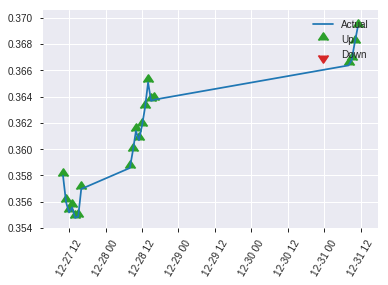


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.30654358837437534
RMSE: 0.5536637864032425
LogLoss: 0.8204800209139056
Mean Per-Class Error: 0.45845410628019323
AUC: 0.49122383252818036
pr_auc: 0.5147590152520776
Gini: -0.01755233494363928
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5314356684684753: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    115  1        (115.0/115.0)
1      0    108  0        (0.0/108.0)
Total  0    223  0.5157   (115.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.531436     0.652568  221
max f2                       0.531436     0.824427  221
max f0point5                 0.531436     0.54      221
max accuracy                 0.774843     0.55157   29
max precision                0.811544     0.833333  5
max recall                   0.531436     1         221
max specificity              0.825523     0.991304  0
max absolute_mcc             0.652665     0.160106  185
max min_per_class_accuracy   0.718684     0.509259  110
max mean_per_class_accuracy  0.764629     0.541546  39

Gains/Lift Table: Avg response rate: 48.43 %, avg score: 71.14 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.820047           1.37654   1.37654            0.666667         0.822663  0.666667                    0.822663            0.0185185       0.0185185                  37.6543   37.6543
    2        0.0224215                   0.815664           2.06481   1.65185            1                0.819435  0.8                         0.821372            0.0185185       0.037037                   106.481   65.1852
    3        0.0313901                   0.810475           1.03241   1.47487            0.5              0.811441  0.714286                    0.818534            0.00925926      0.0462963                  3.24074   47.4868
    4        0.0403587                   0.802593           1.03241   1.37654            0.5              0.806569  0.666667                    0.815875            0.00925926      0.0555556                  3.24074   37.6543
    5        0.0538117                   0.798045           1.37654   1.37654            0.666667         0.800322  0.666667                    0.811987            0.0185185       0.0740741                  37.6543   37.6543
    6        0.103139                    0.779287           1.12626   1.25684            0.545455         0.787759  0.608696                    0.8004              0.0555556       0.12963                    12.6263   25.6844
    7        0.152466                    0.768386           1.31397   1.27533            0.636364         0.774518  0.617647                    0.792026            0.0648148       0.194444                   31.3973   27.5327
    8        0.201794                    0.761409           0.938552  1.193              0.454545         0.764559  0.577778                    0.785312            0.0462963       0.240741                   -6.14478  19.3004
    9        0.300448                    0.74272            0.750842  1.04782            0.363636         0.755546  0.507463                    0.775538            0.0740741       0.314815                   -24.9158  4.78165
    10       0.399103                    0.72957            0.750842  0.974407           0.363636         0.73567   0.47191                     0.765683            0.0740741       0.388889                   -24.9158  -2.5593
    11       0.502242                    0.718487           1.16707   1.01397            0.565217         0.723368  0.491071                    0.756993            0.12037         0.509259                   16.7069   1.39716
    12       0.600897                    0.700582           0.750842  0.970771           0.363636         0.709673  0.470149                    0.749224            0.0740741       0.583333                   -24.9158  -2.92289
    13       0.699552                    0.682858           0.938552  0.966227           0.454545         0.694522  0.467949                    0.74151             0.0925926       0.675926                   -6.14478  -3.37726
    14       0.798206                    0.662391           0.656987  0.928007           0.318182         0.674189  0.449438                    0.733189            0.0648148       0.740741                   -34.3013  -7.19933
    15       0.896861                    0.626225           1.22012   0.960139           0.590909         0.647696  0.465                       0.723785            0.12037         0.861111                   22.0118   -3.98611
    16       1                           0.531436           1.34662   1                  0.652174         0.604109  0.484305                    0.711442     

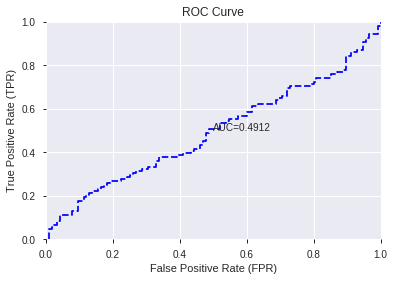

This function is available for GLM models only


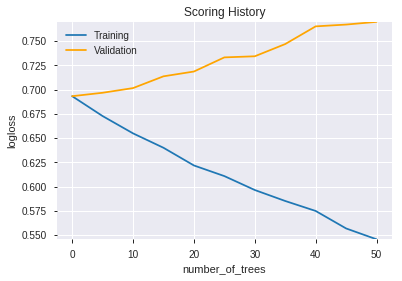

--2019-08-26 19:10:19--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.177.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.177.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_190944_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_190944_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_a50a',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['TRANGE',
 'ADXR_12',
 'STDDEV_12',
 'BOP',
 'WILLR_8',
 'HT_PHASOR_quadrature',
 'aroonup_30',
 'BETA_8',
 'PLUS_DM_14',
 'BETA_20',
 'MFI_30',
 'HT_PHASOR_inphase',
 'HT_DCPERIOD',
 'ADXR_8',
 'ADX_20',
 'AD',
 'STDDEV_8',
 'ATR_30',
 'MFI_20',
 'CCI_20',
 'BETA_14',
 'MACDFIX_hist_20',
 'STOCHF_fastk',
 'ATR_8',
 'MACDFIX_hist_8',
 'DX_8',
 'ROC_30',
 'ADX_12',
 'ROC_12',
 'BBANDS_upperband_14_5_3',
 'ADX_24',
 'STOCH_slowk',
 'MFI_24',
 'ADXR_14',
 'DX_20',
 'LINEARREG_ANGLE_8',
 'BETA_24',
 'ADOSC',
 'PLUS_DM_12',
 'MFI_8',
 'ULTOSC',
 'CORREL_24',
 'DX_24',
 'CCI_8',
 'WILLR_24',
 'BBANDS_upperband_20_0_5',
 'STOCH_slowd',
 'CCI_12',
 'ADX_8',
 'MOM_24',
 'MINUS_DI_14',
 'NATR_12',
 'DX_30',
 'LINEARREG_INTERCEPT_30',
 'ATR_24',
 'aroondown_8',
 'PLUS_DM_8',
 'AROONOSC_14',
 'MFI_14',
 'CCI_30',
 'MINUS_DI_20',
 'STDDEV_20',
 'MFI_12',
 'STDDEV_24',
 'LINEARREG_INTERCEPT_24',
 'WILLR_30',
 'aroonup_8',
 'aroondown_12',
 'OBV',
 'AROONOSC_24',
 'BBANDS_lowerband_20_0_3',
 'MINUS_

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.623
GLM             0.587
XGBoost         0.561
dtype: float64

DeepLearning    GLM  XGBoost
All          0.578  0.587    0.561
DLF          0.547  0.534    0.529
Fwe          0.623  0.587    0.561
RFE          0.484  0.574    0.552
XGBF         0.570  0.534    0.529





F1


DeepLearning    0.669
GLM             0.663
XGBoost         0.656
dtype: float64

DeepLearning    GLM  XGBoost
All          0.669  0.654    0.655
DLF          0.653  0.656    0.656
Fwe          0.653  0.654    0.655
RFE          0.653  0.663    0.653
XGBF         0.656  0.656    0.656





auc


DeepLearning    0.580
GLM             0.555
XGBoost         0.513
dtype: float64

DeepLearning    GLM  XGBoost
All          0.580  0.555    0.513
DLF          0.524  0.495    0.509
Fwe          0.578  0.555    0.513
RFE          0.500  0.550    0.491
XGBF         0.553  0.495    0.509





logloss


DeepLearning    1.546
GLM             0.714
XGBoost         0.820
dtype: float64

DeepLearning    GLM  XGBoost
All          0.693  0.711    0.731
DLF          0.704  0.693    0.701
Fwe          1.546  0.711    0.731
RFE          0.693  0.714    0.820
XGBF         0.822  0.693    0.701





mean_per_class_error


DeepLearning    0.500
GLM             0.475
XGBoost         0.459
dtype: float64

DeepLearning    GLM  XGBoost
All          0.425  0.413    0.445
DLF          0.452  0.475    0.459
Fwe          0.379  0.413    0.445
RFE          0.500  0.430    0.458
XGBF         0.425  0.475    0.459





rmse


DeepLearning    0.666
GLM             0.510
XGBoost         0.554
dtype: float64

DeepLearning    GLM  XGBoost
All          0.500  0.509    0.517
DLF          0.504  0.500    0.504
Fwe          0.666  0.509    0.517
RFE          0.500  0.510    0.554
XGBF         0.545  0.500    0.504





mse


DeepLearning    0.444
GLM             0.260
XGBoost         0.307
dtype: float64

DeepLearning    GLM  XGBoost
All          0.250  0.259    0.268
DLF          0.254  0.250    0.254
Fwe          0.444  0.259    0.268
RFE          0.250  0.260    0.307
XGBF         0.297  0.250    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.669    NaN      NaN
 DLF          0.653    NaN      NaN
 DLF            NaN  0.656      NaN
 DLF            NaN    NaN    0.656
 All            NaN  0.654      NaN
 All            NaN    NaN    0.655
 XGBF         0.656    NaN      NaN
 XGBF           NaN  0.656      NaN
 XGBF           NaN    NaN    0.656
 Fwe          0.653    NaN      NaN
 Fwe            NaN  0.654      NaN
 Fwe            NaN    NaN    0.655
 RFE          0.653    NaN      NaN
 RFE            NaN  0.663      NaN
 RFE            NaN    NaN    0.653,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.578    NaN      NaN
 DLF          0.547    NaN      NaN
 DLF            NaN  0.534      NaN
 DLF            NaN    NaN    0.529
 All            NaN  0.587      NaN
 All            NaN    NaN    0.561
 XGBF         0.570    NaN      NaN
 XGBF           NaN  0.534      NaN
 XGBF           NaN    NaN    0.529
 Fwe          0.623    NaN      NaN
 Fwe     